In [1]:
import rail

import tables_io
import qp
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import pandas as pd

from rail.evaluation.dist_to_dist_evaluator import DistToDistEvaluator
from rail.evaluation.dist_to_point_evaluator import DistToPointEvaluator
from rail.evaluation.point_to_point_evaluator import PointToPointEvaluator
from rail.evaluation.single_evaluator import SingleEvaluator
from rail.core.stage import RailStage
from rail.core.data import QPHandle, TableHandle, QPOrTableHandle

DS = RailStage.data_store
DS.__class__.allow_overwrite = True

# Dist-to-dist

In [220]:
stage_dict = dict(
    metrics=['cvm', 'ks', 'rmse', 'kld', 'ad'],
    _random_state=None,
)

dtd_stage = DistToDistEvaluator.make_stage(name='dist_to_dist', **stage_dict)
#dtd_stage_single = DistToDistEvaluator.make_stage(name='dist_to_dist', force_exact=True, **stage_dict)

In [11]:
# file = h5py.File(pdfs_file, 'r')
# file.keys

<KeysViewHDF5 ['ancil', 'data', 'meta']>

In [276]:
spec_ls = ['BOSS', 'DEEP2', 'GAMA', 'HSC', 'VVDSf02', 'zCOSMOS']
pivot_ls = ["1.0", "1.4", 'control'] 
est_ls = ['TrainZ', 'CMNN', 'GPz', 'PZFlow', 'FZBoost']

ztrue_posts_file = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsstErr_testSet_posts.hdf5"

ztrue_data = DS.read_file(key='data', handle_class=QPHandle, path=ztrue_posts_file)
ztrue_data_2 = DS.read_file('ztrue_data', TableHandle, ztrue_posts_file)


In [467]:
true_point_zs = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error (for posts).pq")

true_point_zs

true_point_zs['redshift']

0       0.520948
1       0.970512
2       1.320268
3       1.035288
4       1.599862
          ...   
9995    1.188424
9996    0.678350
9997    0.364240
9998    0.960942
9999    1.421508
Name: redshift, Length: 10000, dtype: float32

In [164]:
ztrue_posts = h5py.File(ztrue_posts_file, 'r')


## Plots

## Specs

In [327]:
spec_ls = ['BOSS', 'DEEP2', 'GAMA', 'HSC', 'VVDSf02', 'zCOSMOS']
pivot_ls = ["1.0", "1.4", 'control'] 
est_ls = ['TrainZ', 'CMNN', 'GPz', 'PZFlow', 'FZBoost']

def makeSpecFiles(est):
    file_ls = []
    for i in spec_ls:
        file = h5py.File('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_'+est+'/outputs/'+i+'/output_estimate_'+est+'.hdf5', 'r')
        file_ls.append(file)
    return file_ls

def makeInvzFiles(est):
    file_ls = []
    for i in pivot_ls:
        file = h5py.File('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_'+est+'/outputs/'+i+'/output_estimate_'+est+'.hdf5', 'r')
        file_ls.append(file)
    return file_ls

def makePlots(est, type, dim, size):
    if type == 'invz':
        makeFiles = makeInvzFiles
        name_ls = pivot_ls
    elif type == 'spec':
        makeFiles = makeSpecFiles
        name_ls = spec_ls

    control_file = makeInvzFiles(est)[2]

    fig, axes = plt.subplots(nrows = dim, ncols = dim, figsize = (size, (2/3)*size)) 
    ct = 0
    for i in range(0, dim):
        for j in range(0, dim):
            axes[i][j].plot(ztrue_posts['meta']['xvals'][0], ztrue_posts['data']['yvals'][ct], label = "test set pdf") 
            axes[i][j].plot(true_point_zs['redshift'][ct]*np.ones(101), np.linspace(0, 30, 101), color = 'k', label = 'true redshift')

            #max = np.max(ztrue_posts['data']['yvals'][ct])
            #ind = np.where(ztrue_posts['data']['yvals'] == max)
            # axes[i][j].plot( ztrue_posts['meta']['xvals'][0][ind[1][0]] * np.ones(len(ztrue_posts['meta']['xvals'][0])), np.linspace(0, 20, 101) , color = 'k')

            if est == 'CMNN' or est == 'GPz':
                arr = ztrue_posts['meta']['xvals'][0]
                val = 0
                for file in makeFiles(est):
                    axes[i][j].plot(arr, (1. /(file['data']['scale'][ct] * np.sqrt(2*np.pi))) * np.exp((-1/2) * ((arr - file['data']['loc'][ct])/ file['data']['scale'][ct] )**2) , label = name_ls[val])
                    val += 1
                if type != 'invz':
                    axes[i][j].plot(arr, (1. /(control_file['data']['scale'][ct] * np.sqrt(2*np.pi))) * np.exp((-1/2) * ((arr - control_file['data']['loc'][ct])/ control_file['data']['scale'][ct] )**2) , label = 'control')
                axes[0][0].legend()

            if est == 'TrainZ' or est == 'FZBoost':
                val = 0
                for file in makeFiles(est):
                    axes[i][j].plot(file['meta']['xvals'][0], file['data']['yvals'][ct], label = name_ls[val])
                    val += 1
                if type != 'invz':
                    axes[i][j].plot(control_file['meta']['xvals'][0], control_file['data']['yvals'][ct], label = 'control')
                axes[0][0].legend()

            ct += 1
    if type == 'spec':
        fig.suptitle(est+" Estmiates for Spectrascopic Sky Surveys", size = 'xx-large')
    elif type == 'invz':
        fig.suptitle(est+" Estmiates for Inverse Redshift Incompleteness", size = 'xx-large')
    fig.supxlabel("Redshift", size = 'x-large')
    #fig.supylabel("pdf", size = 'x-large')
    axes[0][0].set_ylabel("pdf")

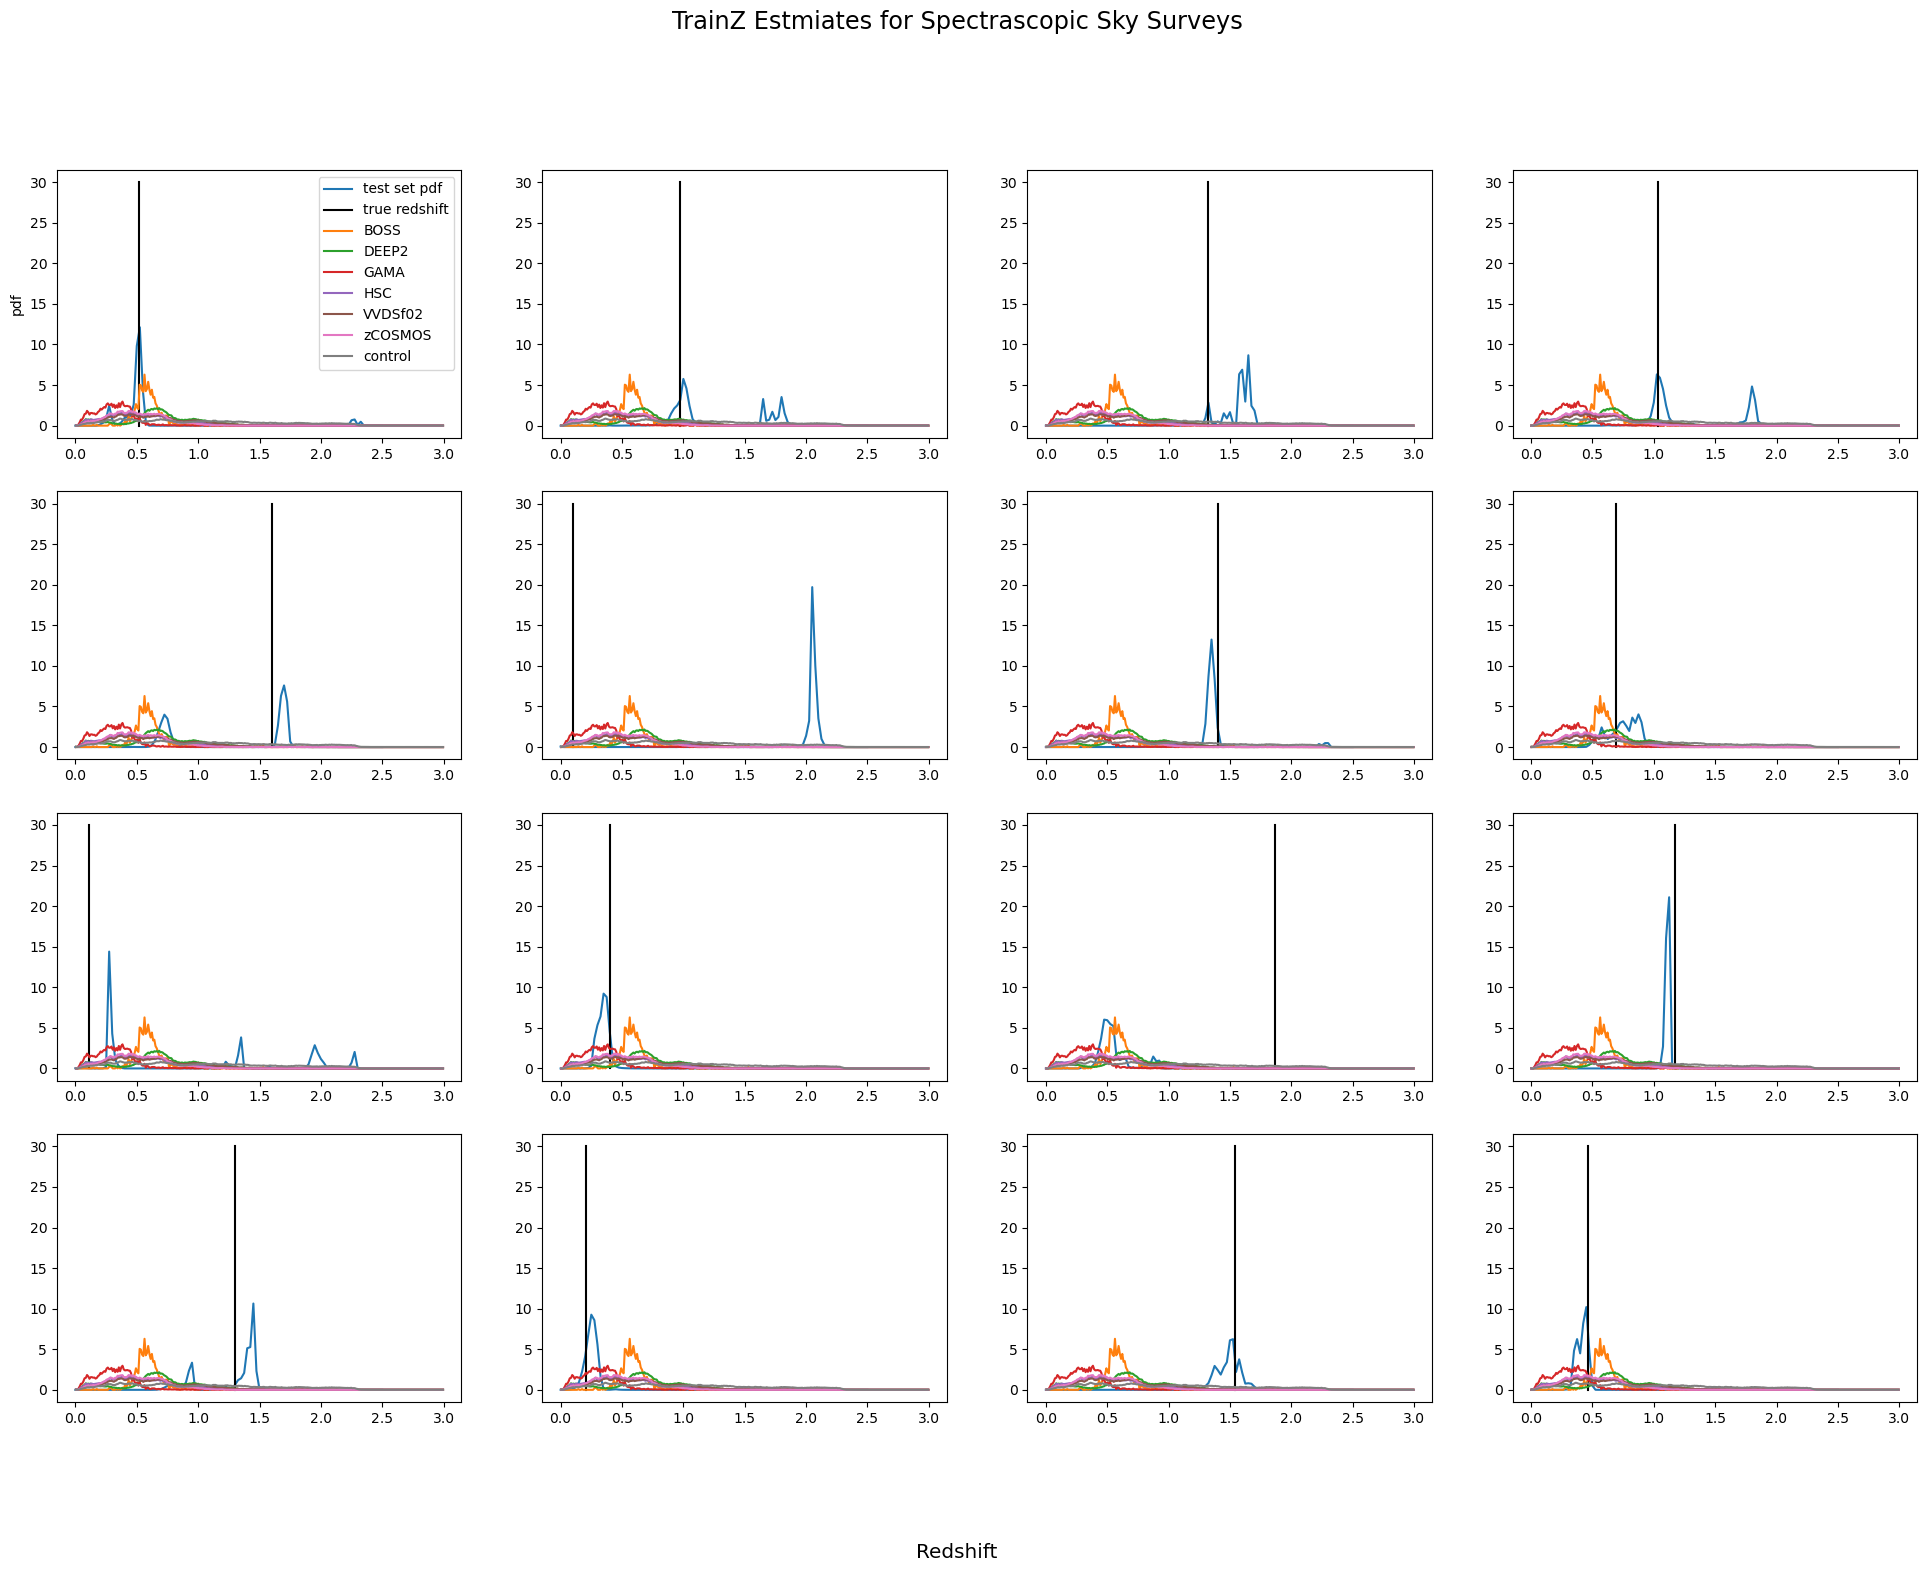

In [319]:
makePlots('TrainZ', 'spec', 4, 24)

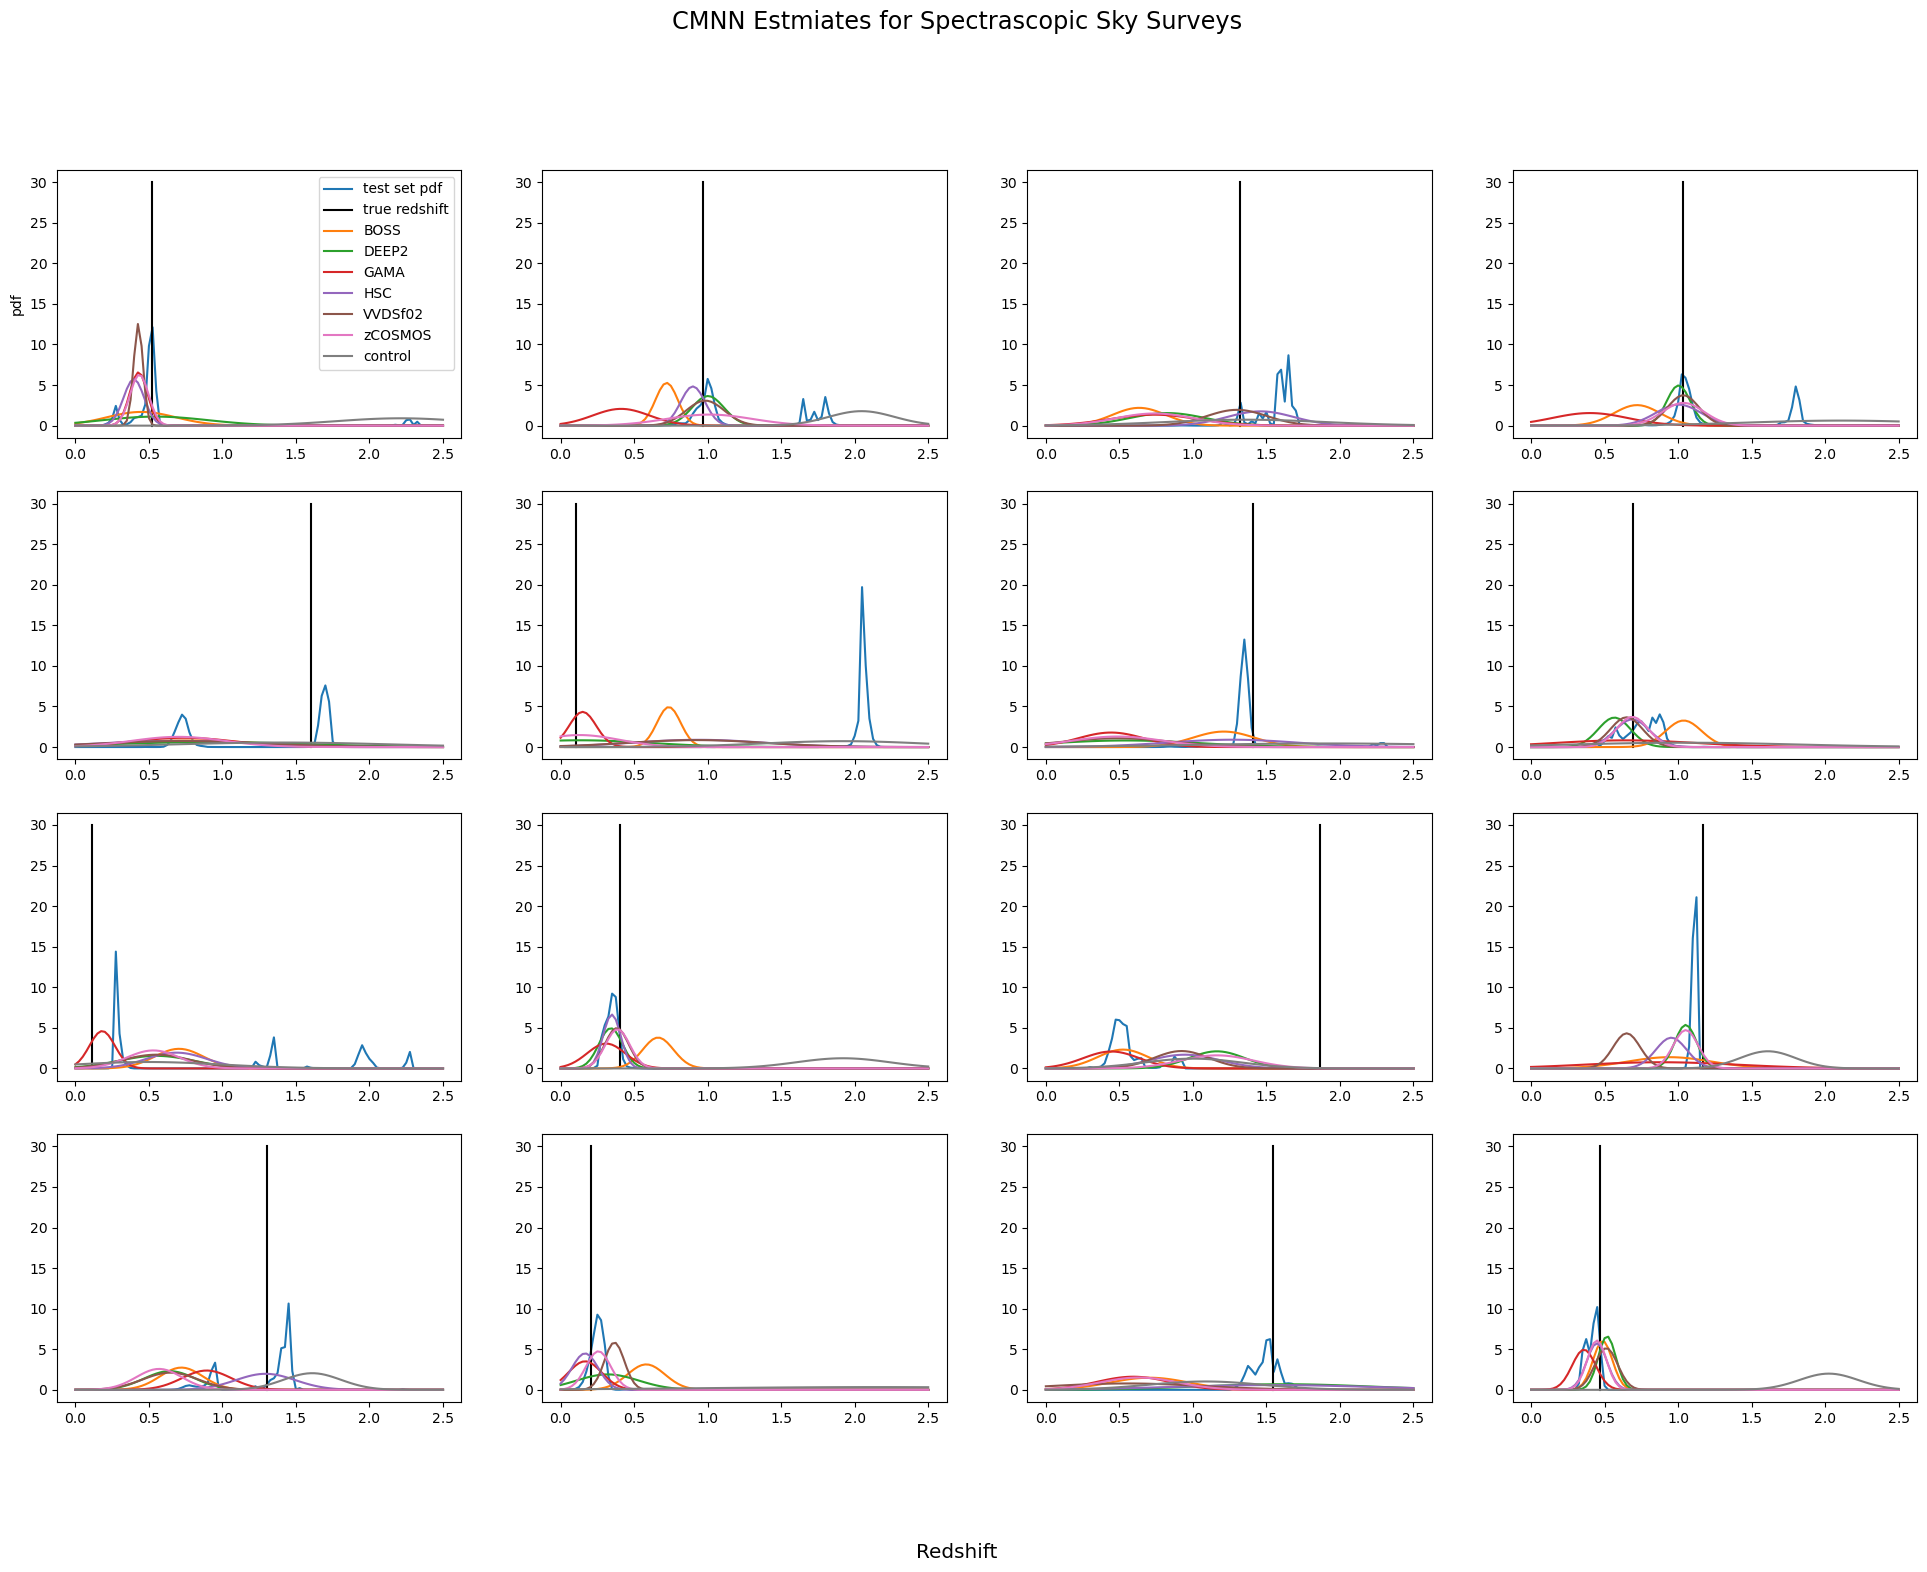

In [320]:
makePlots('CMNN', 'spec', 4, 24)

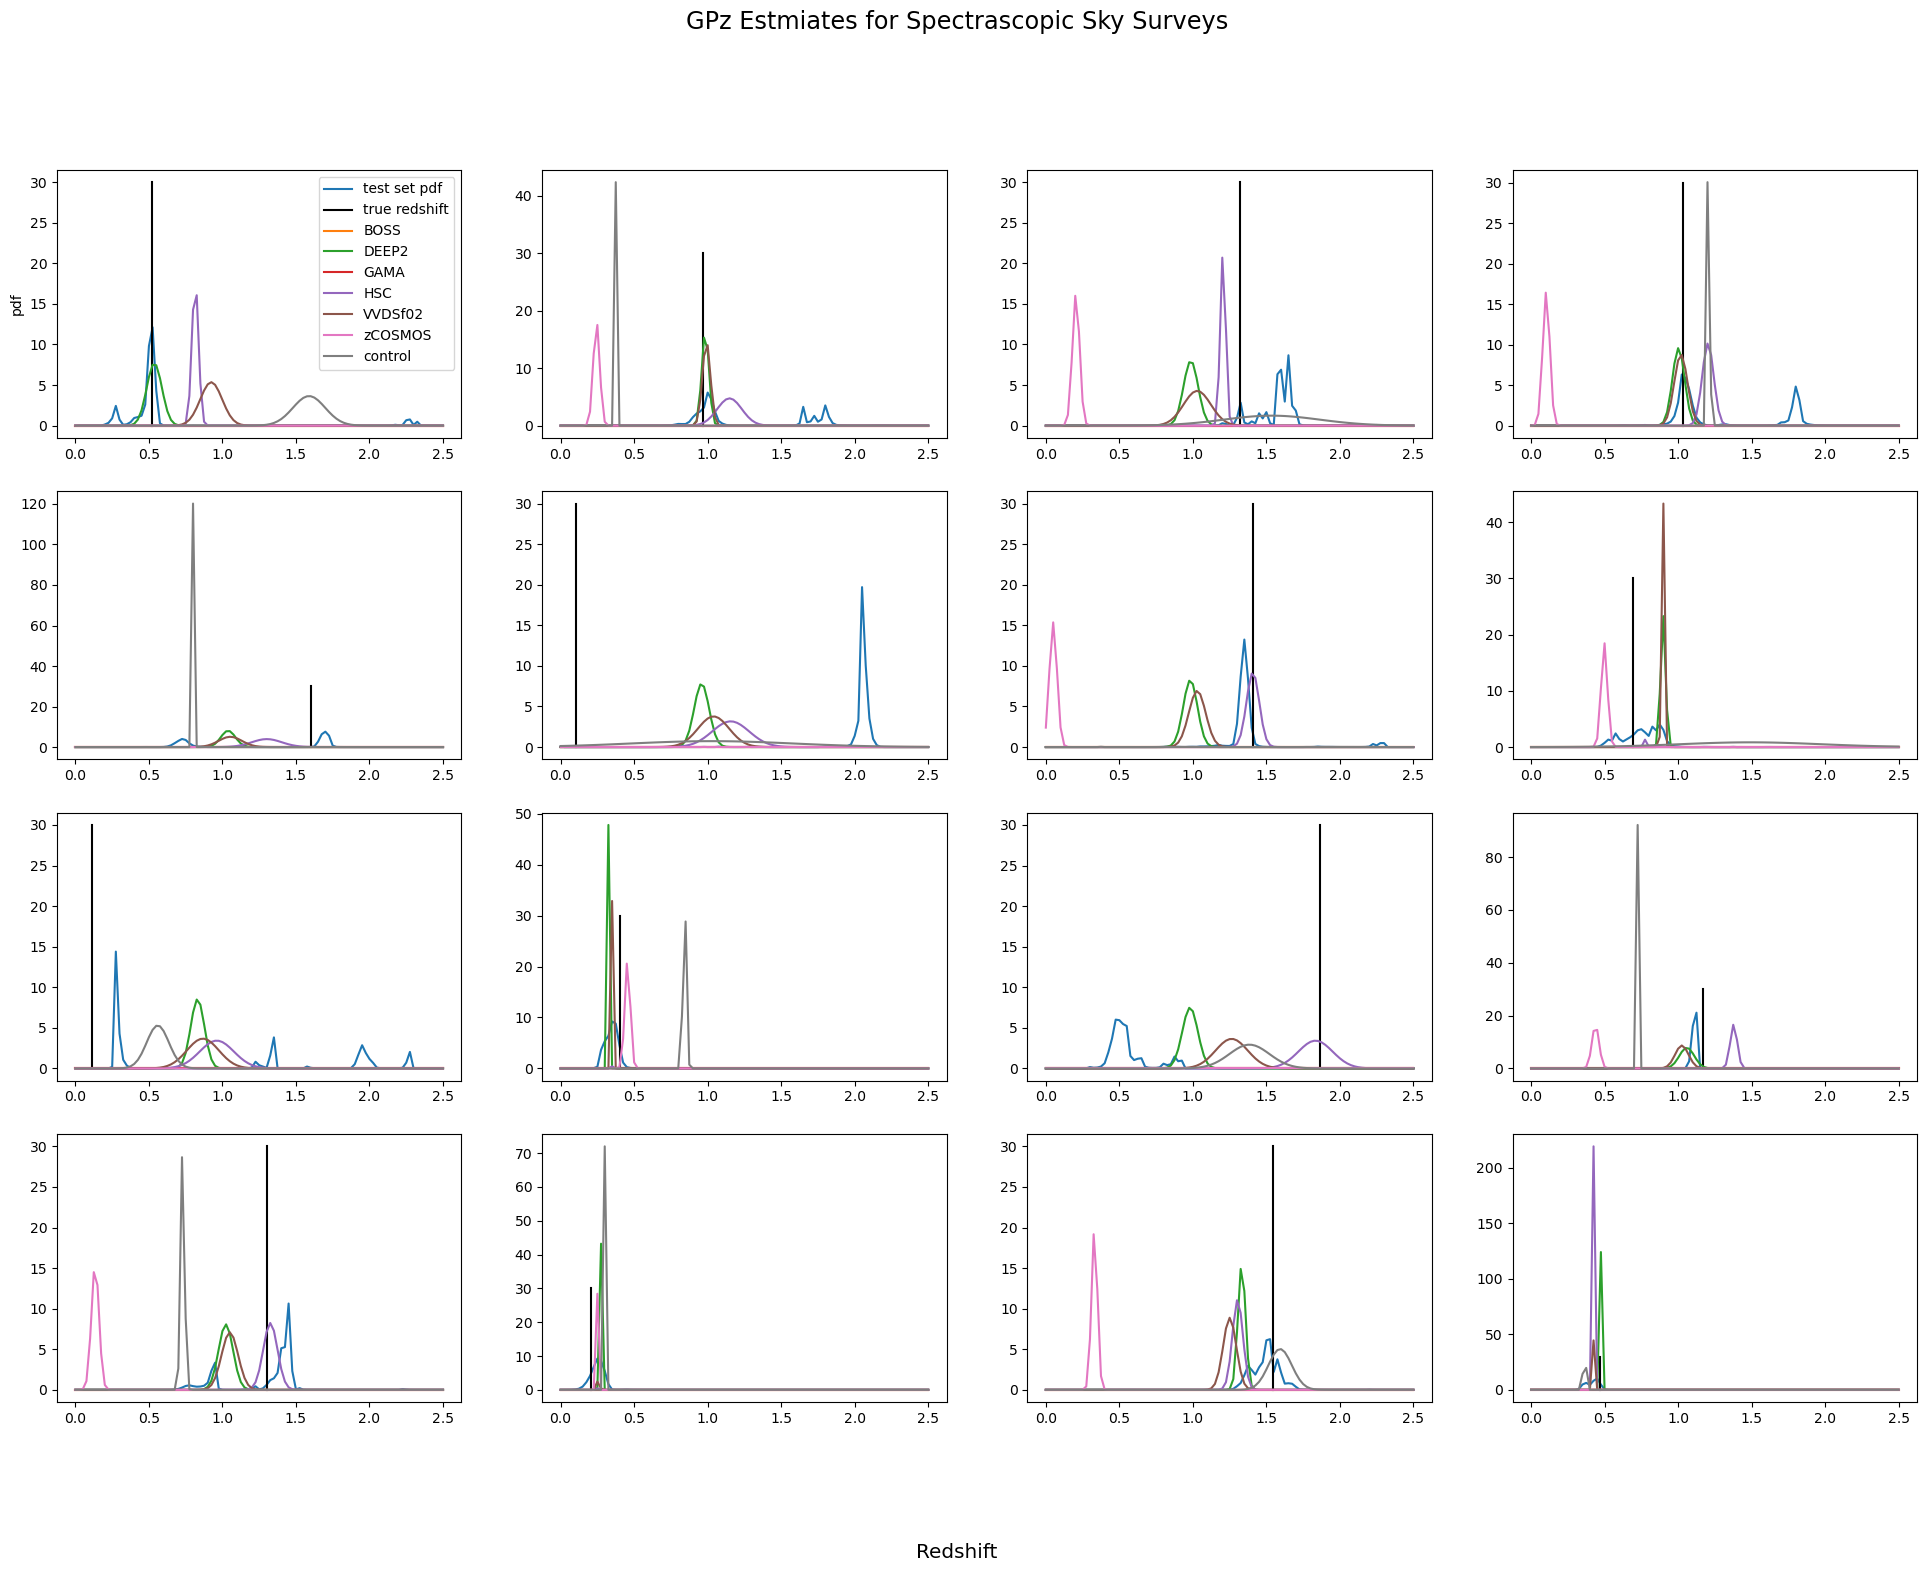

In [321]:
makePlots('GPz','spec', 4, 24)

# file = h5py.File('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs/BOSS/output_estimate_FZBoost.hdf5', 'r')

# file['data']['yvals']

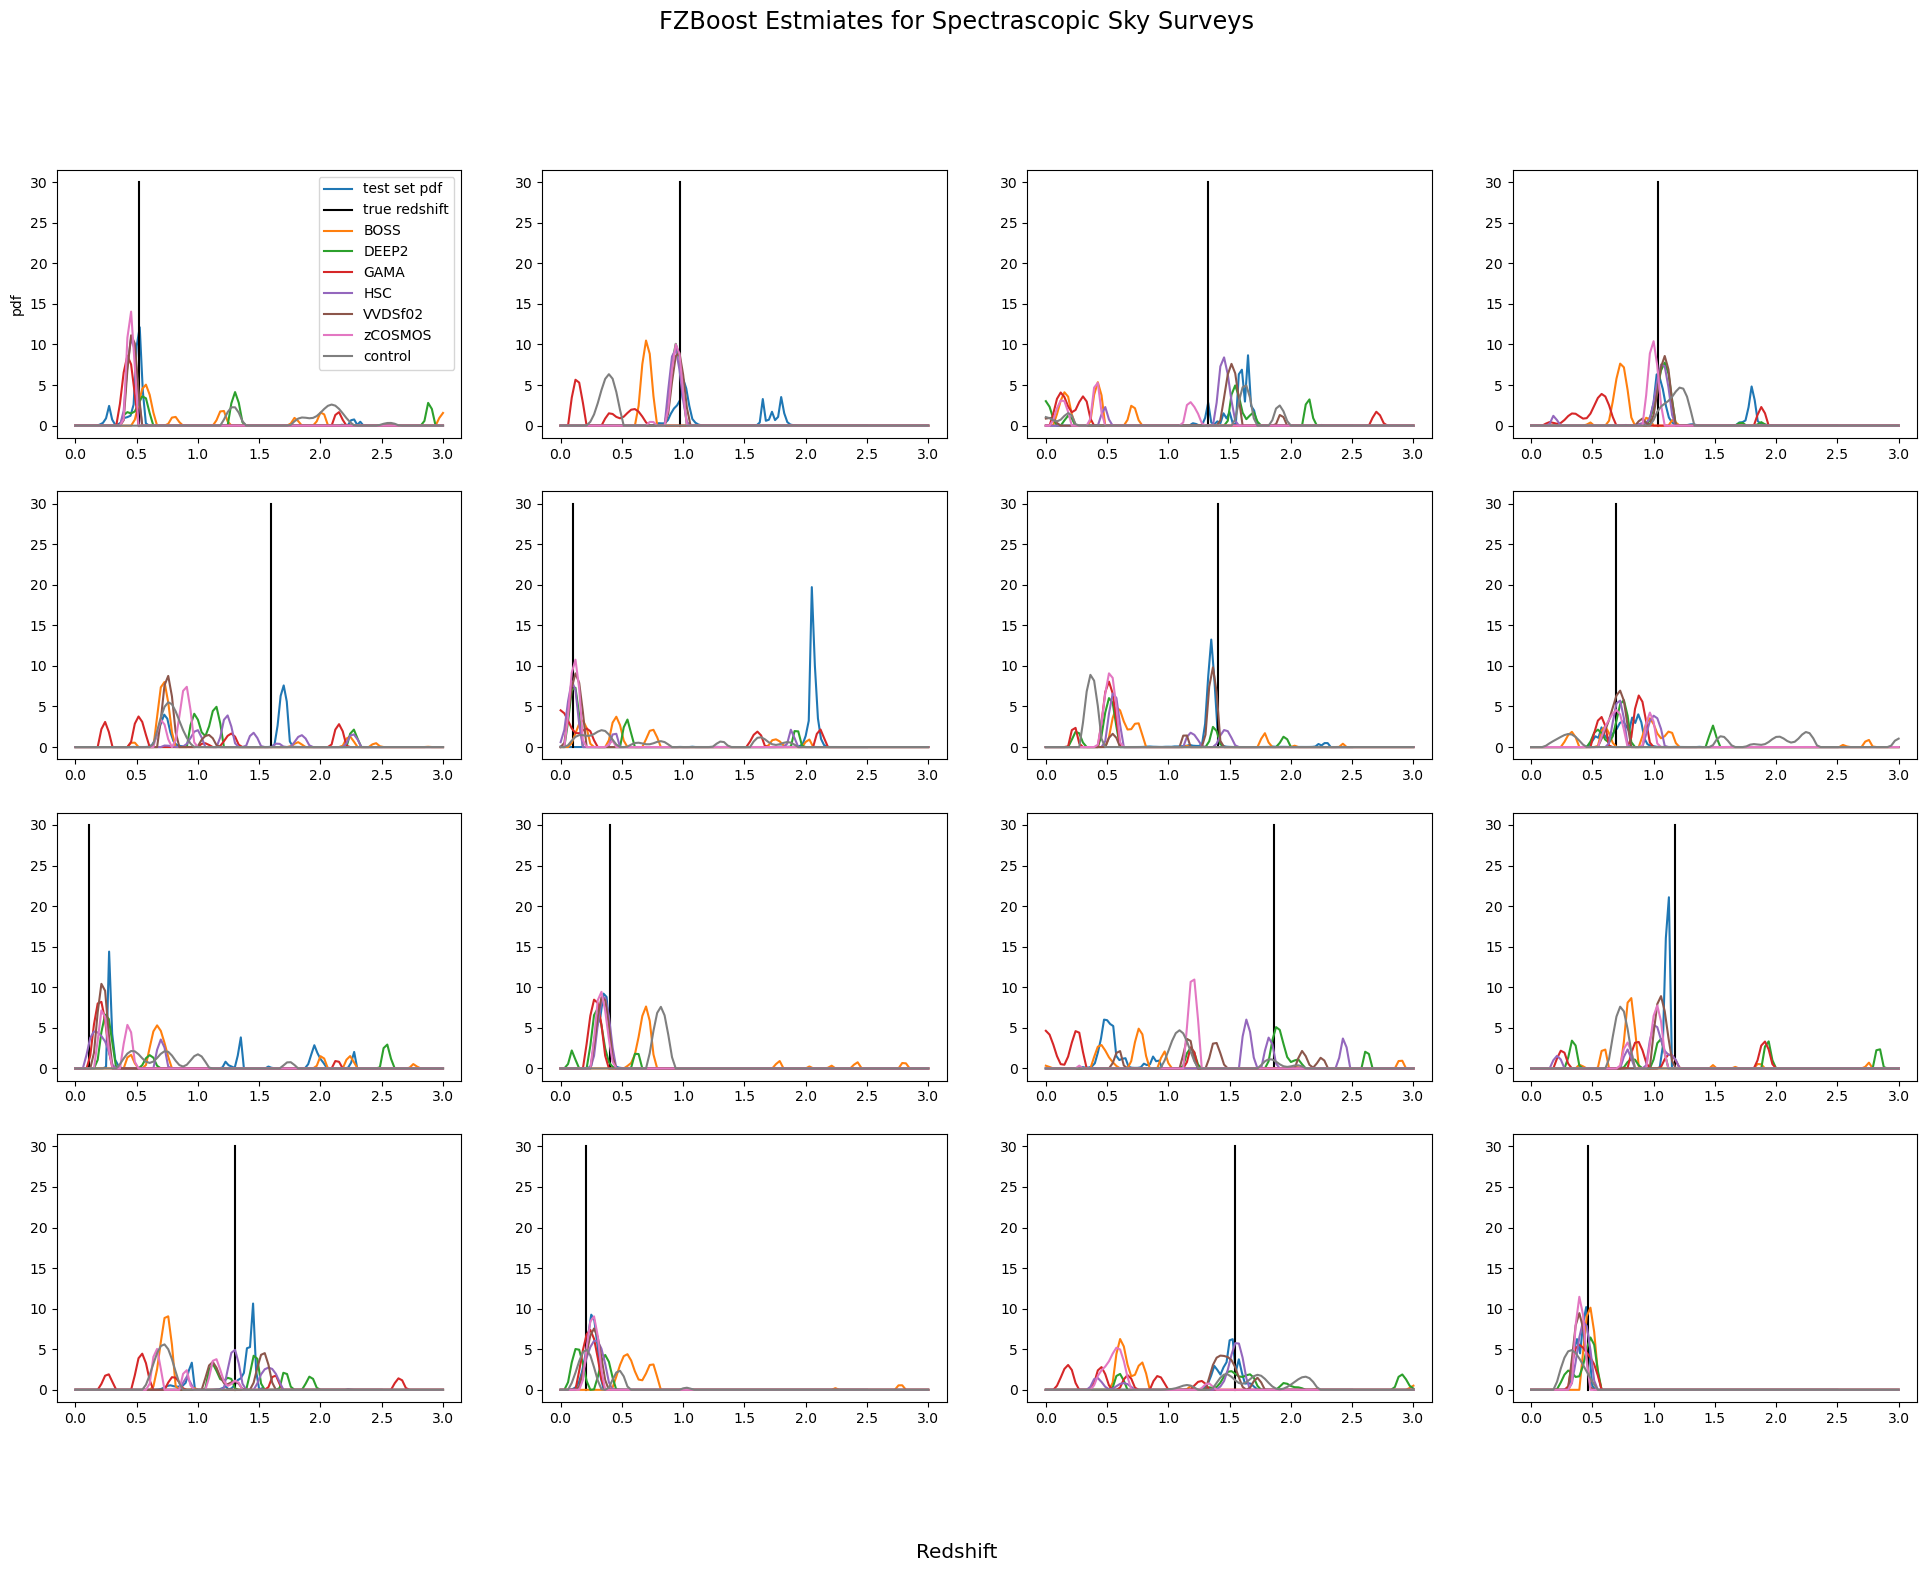

In [322]:
makePlots('FZBoost','spec', 4, 24)

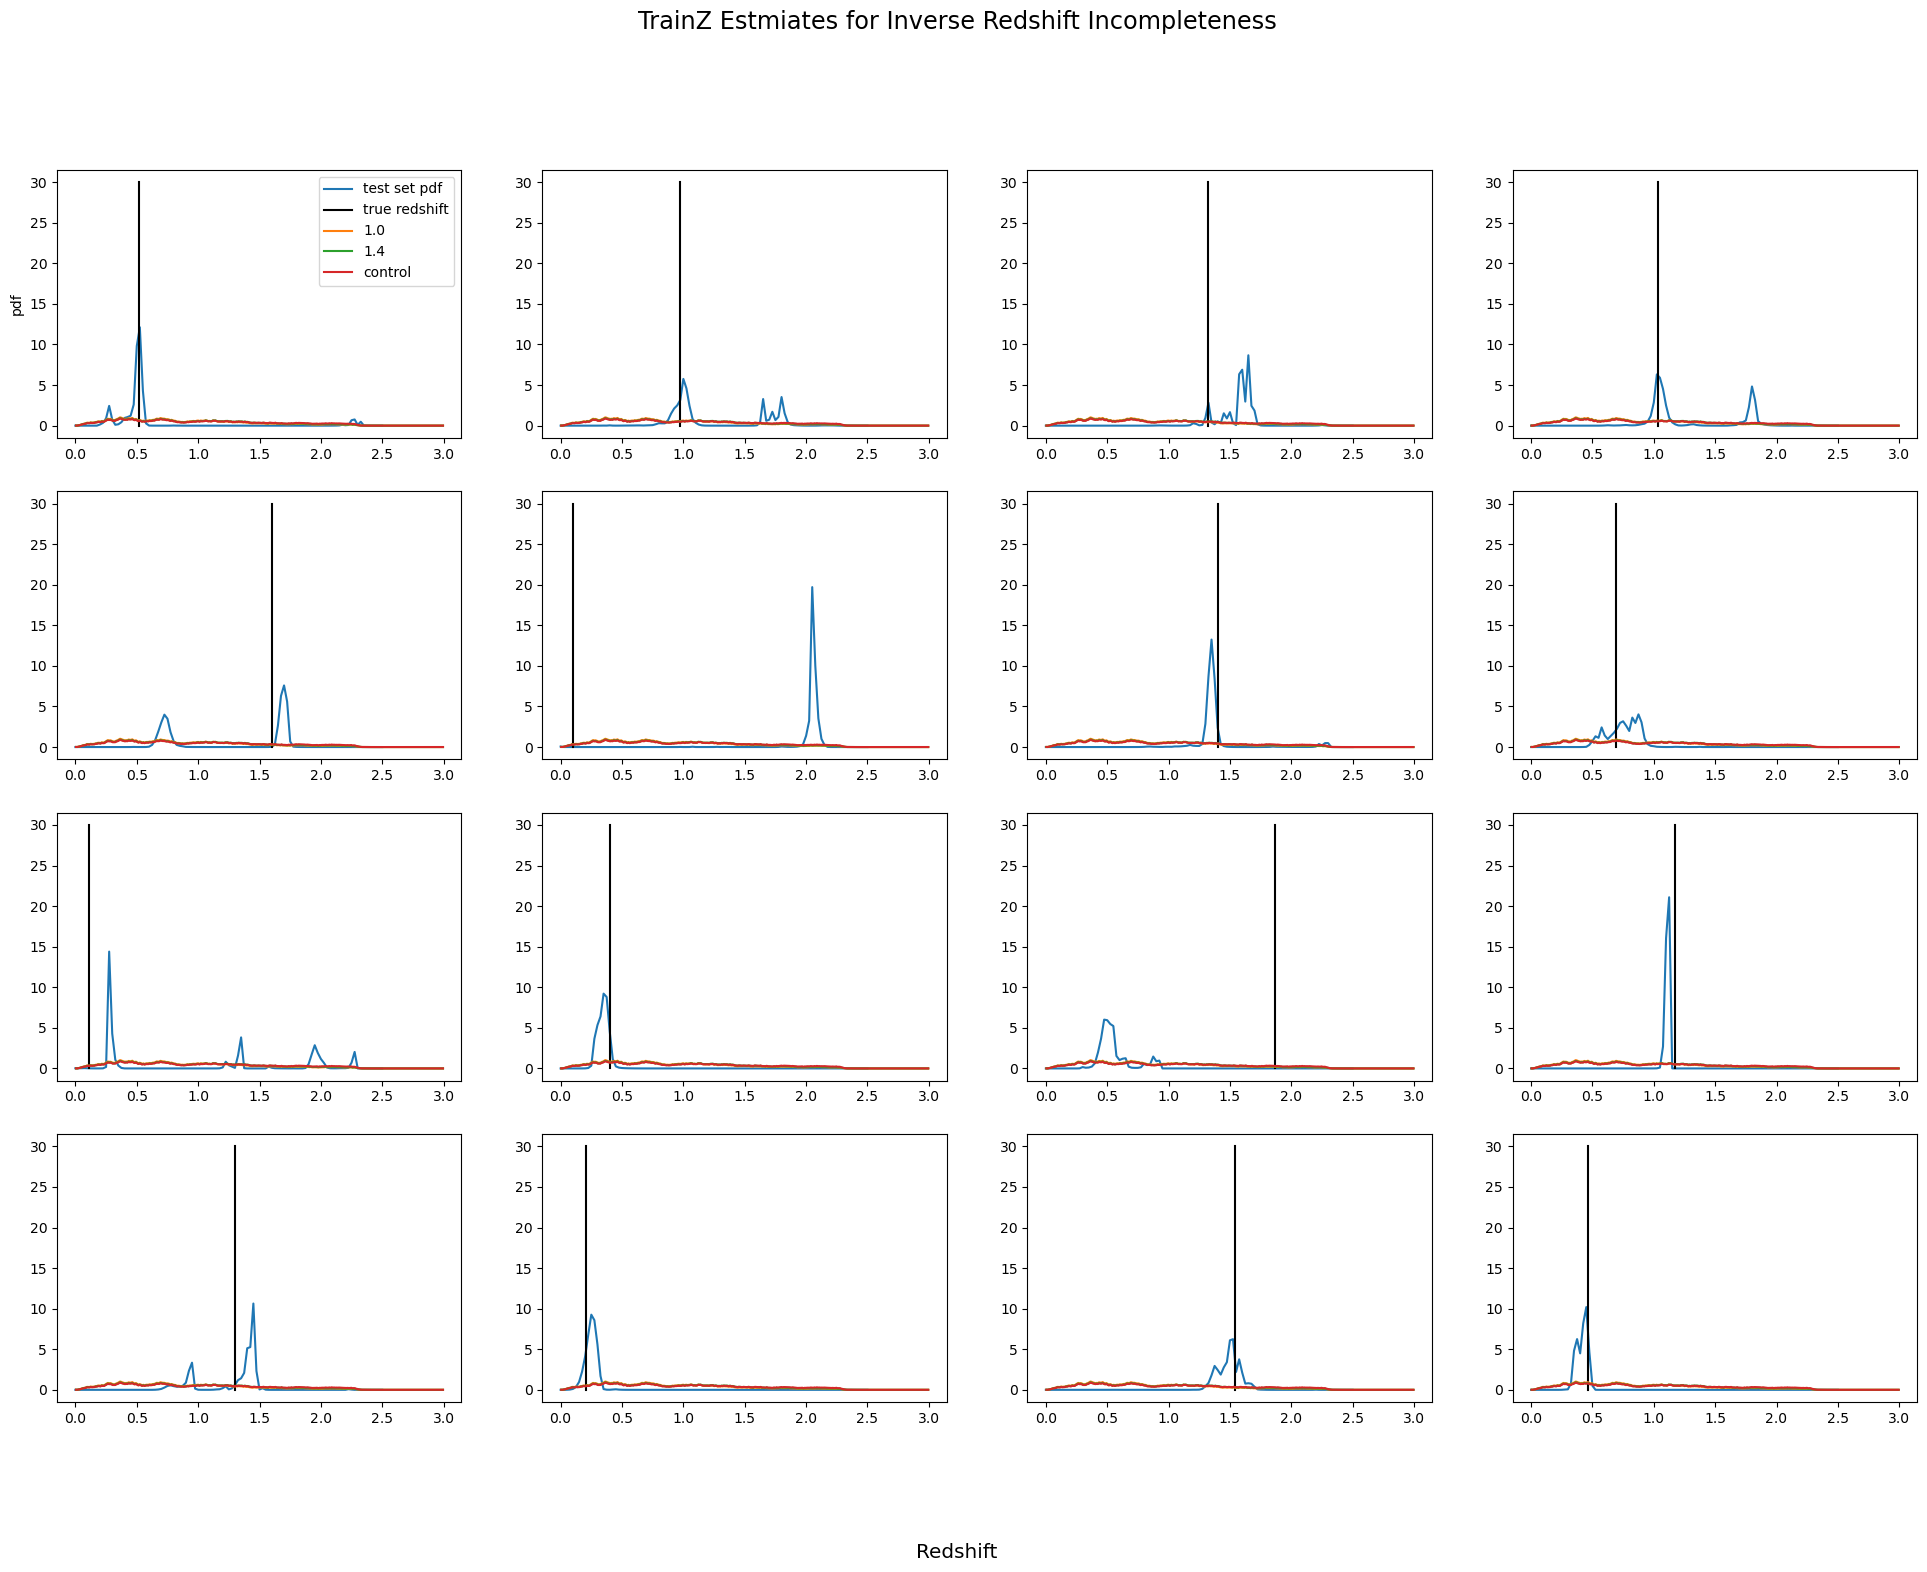

In [328]:
makePlots('TrainZ','invz', 4, 24)

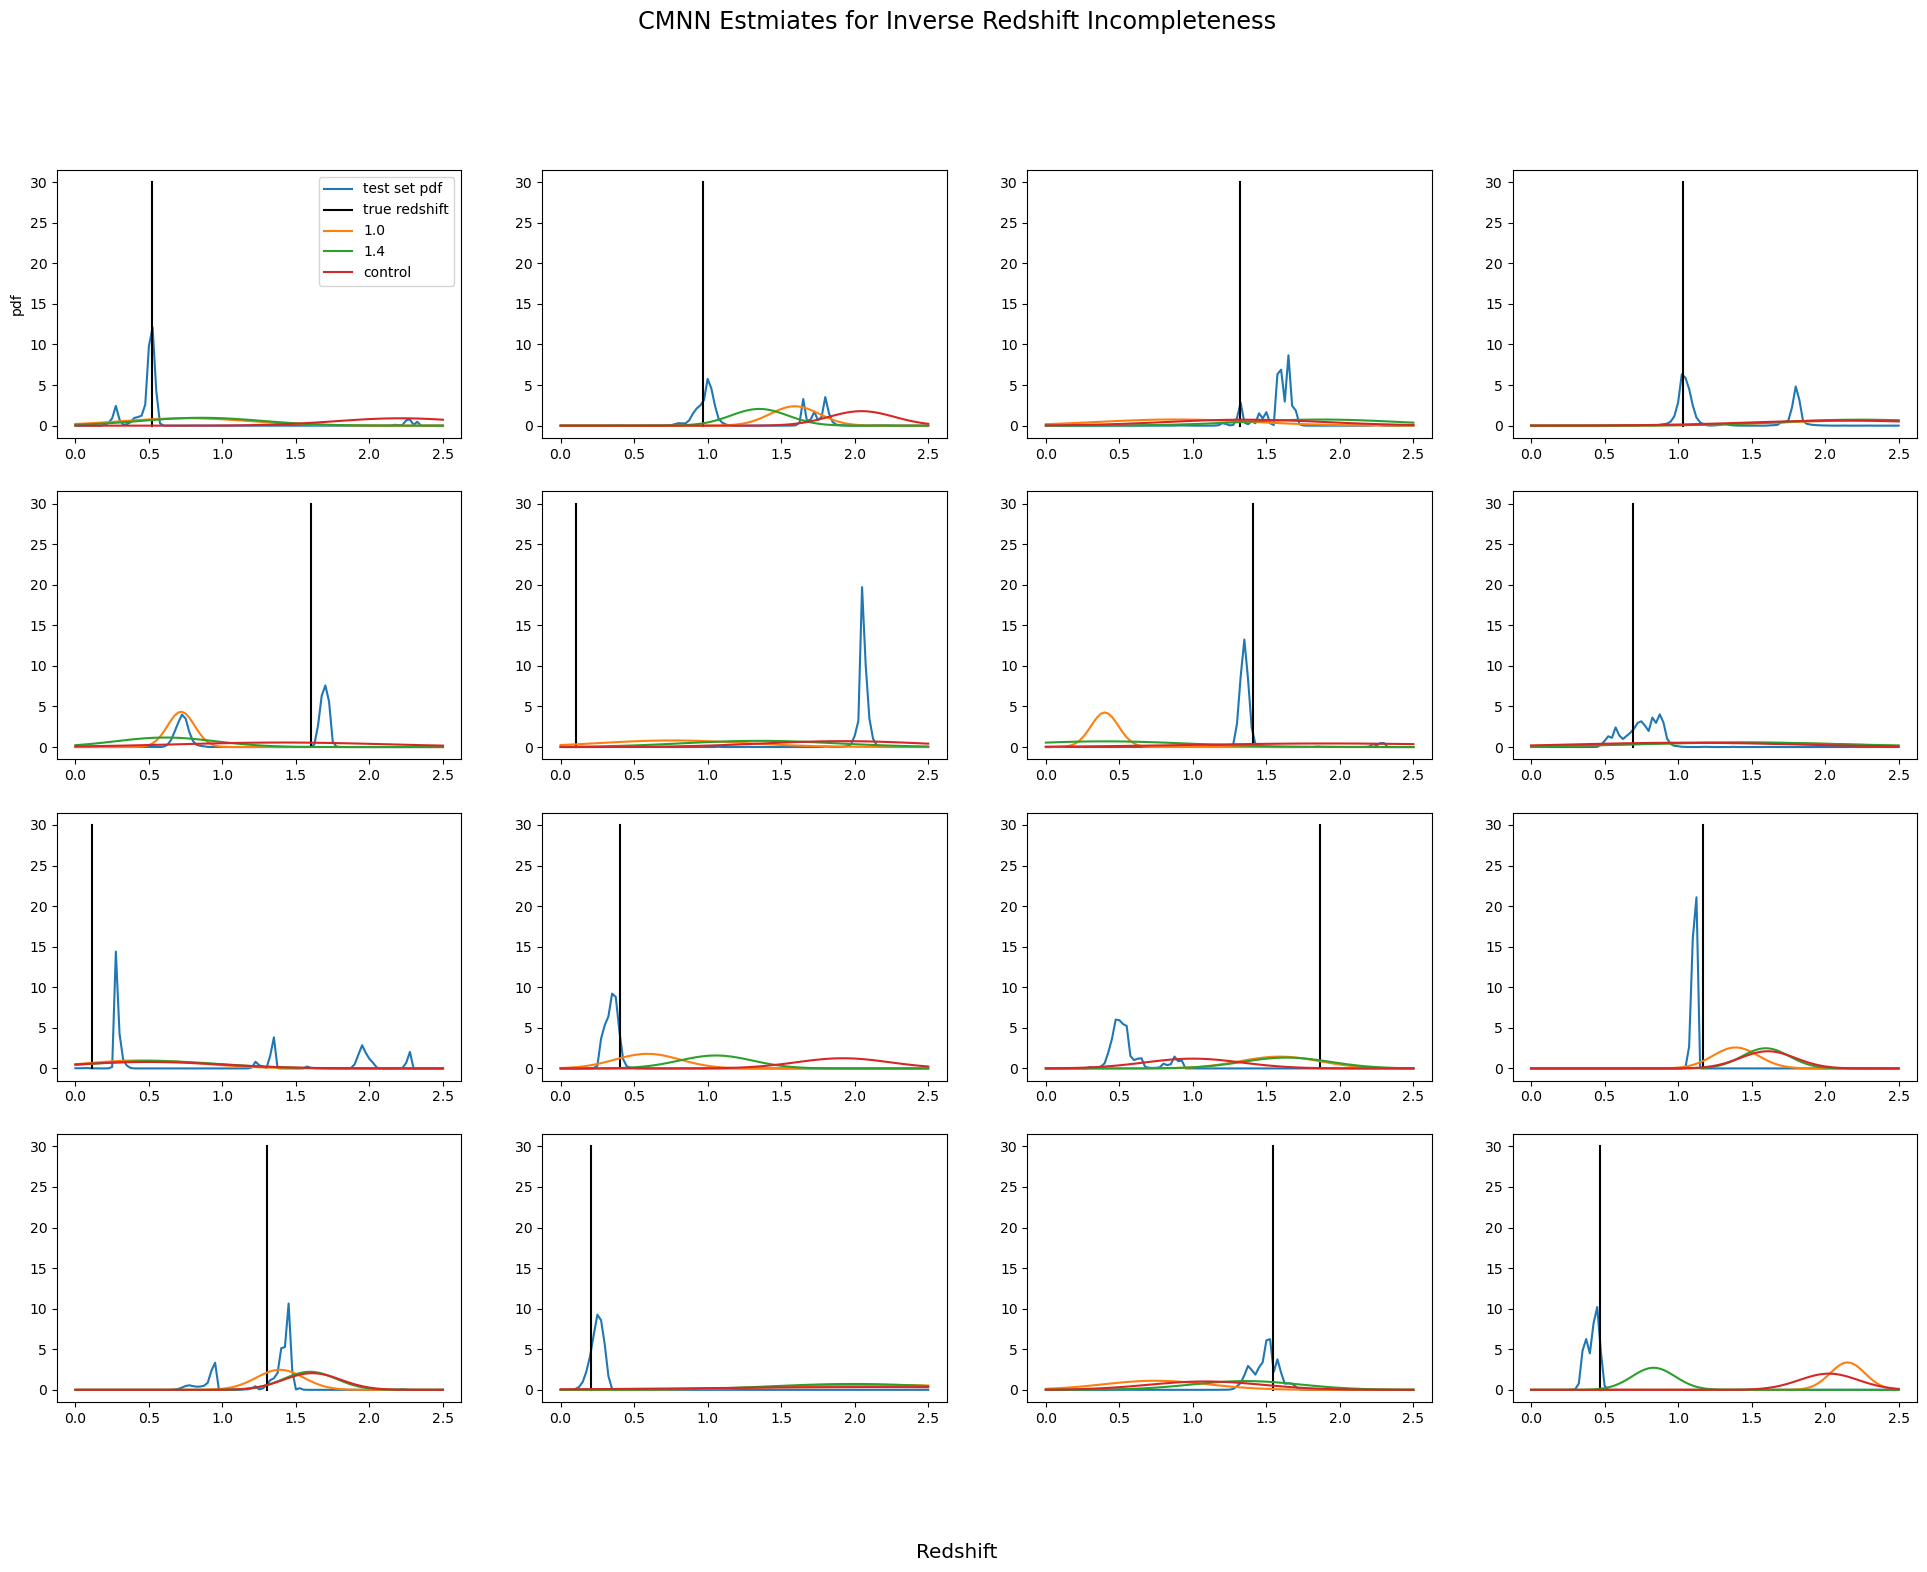

In [329]:
makePlots('CMNN','invz', 4, 24)

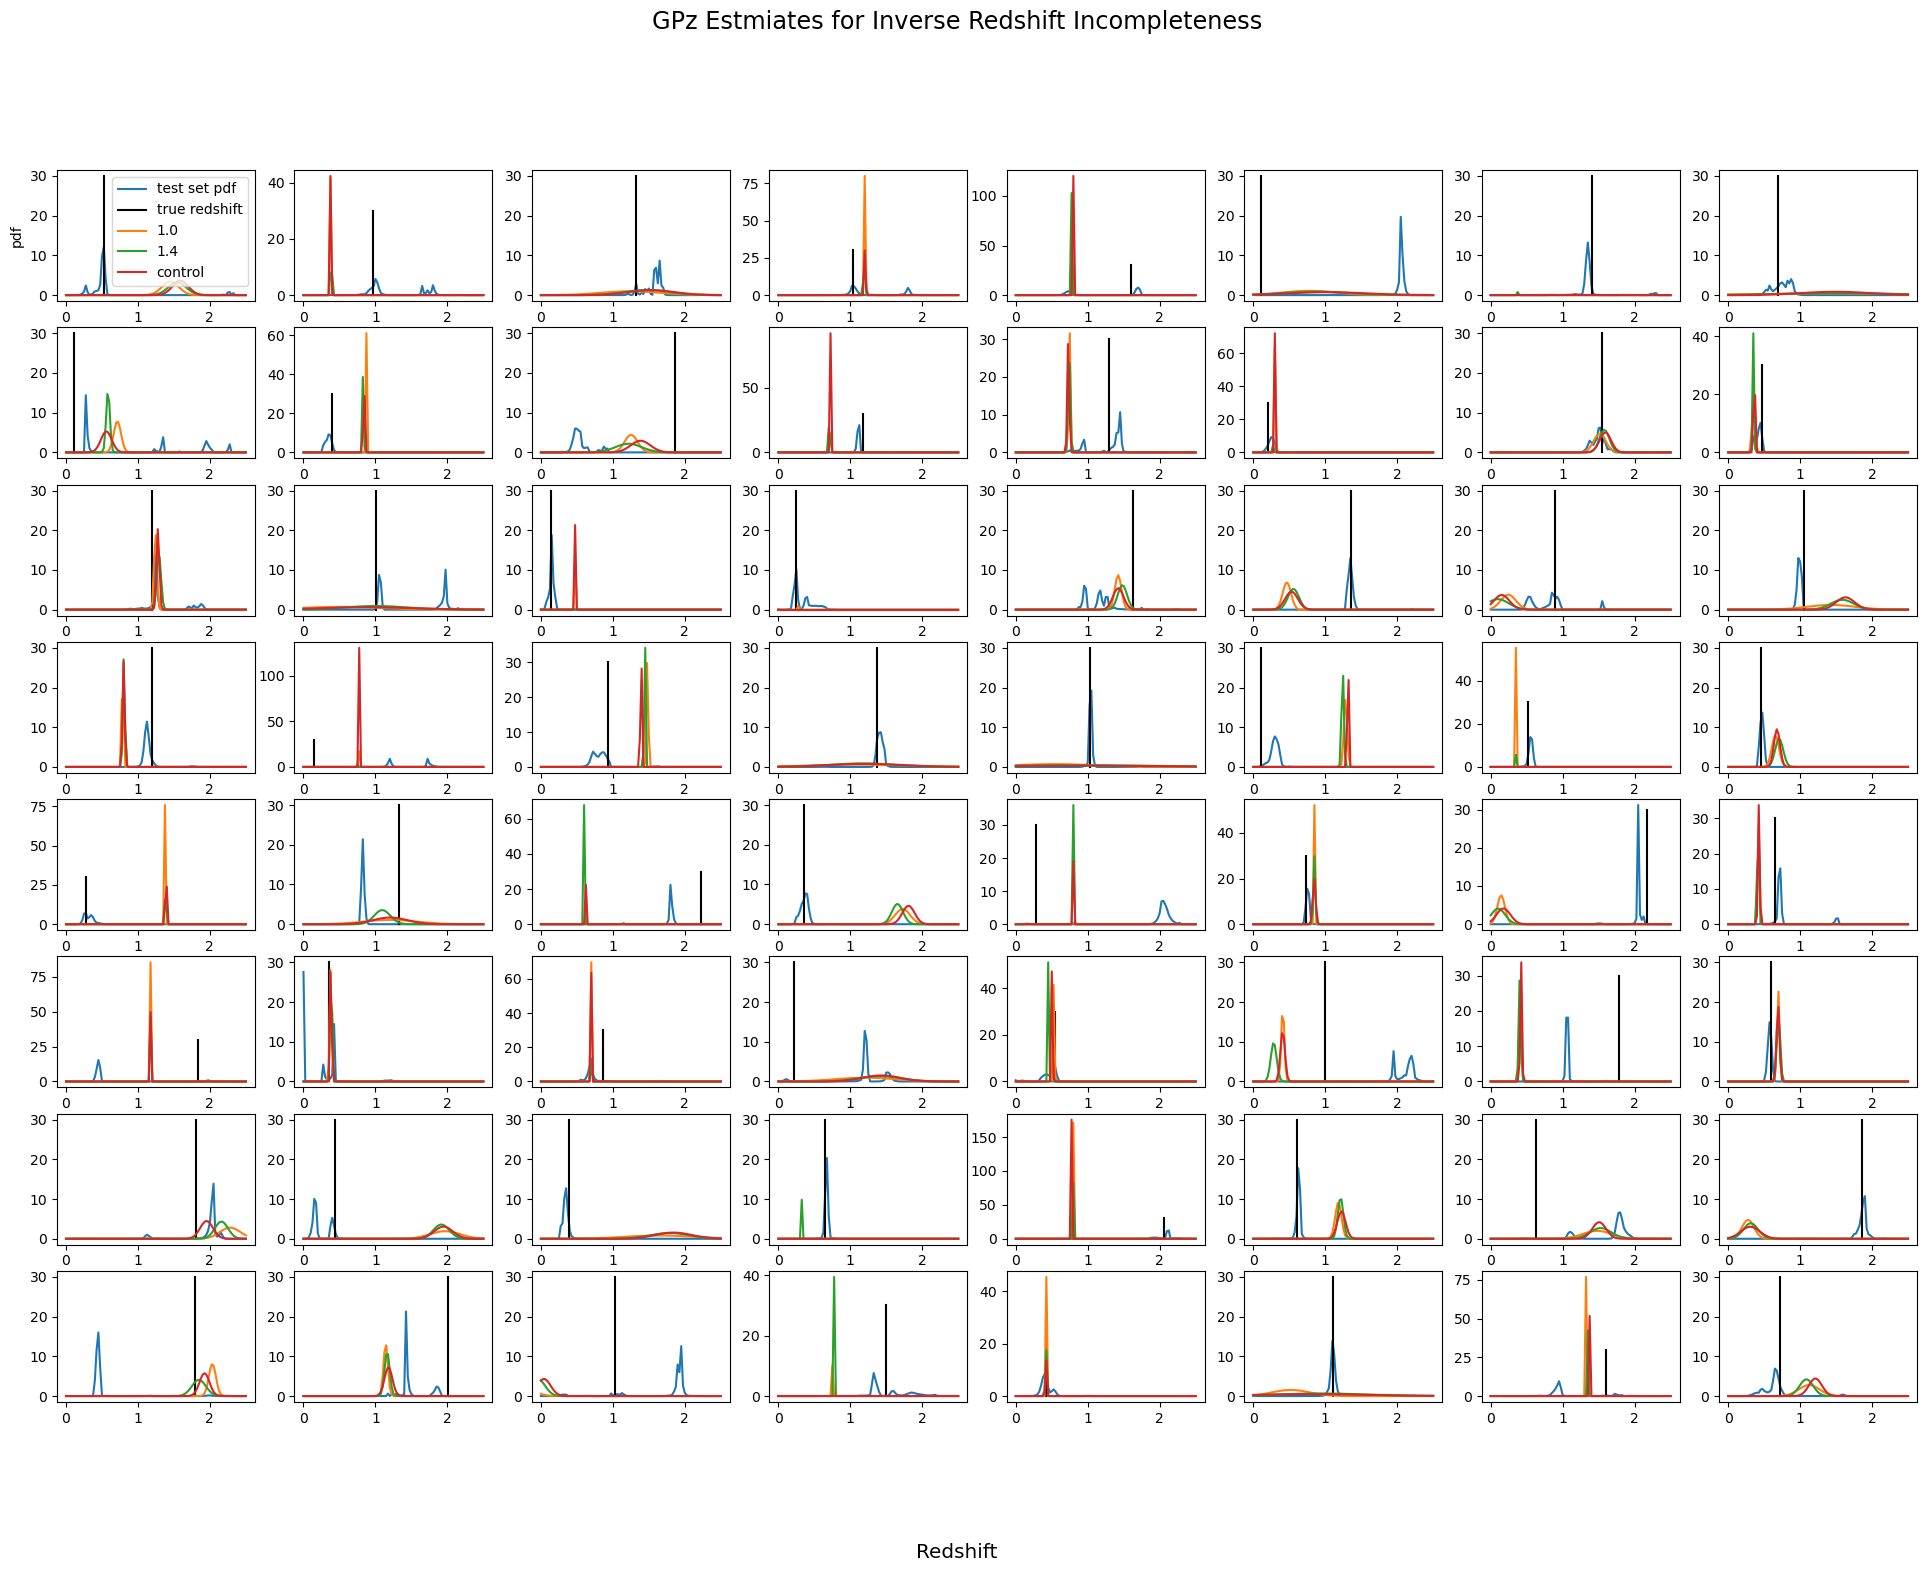

In [314]:
makePlots('GPz','invz', 8, 24)

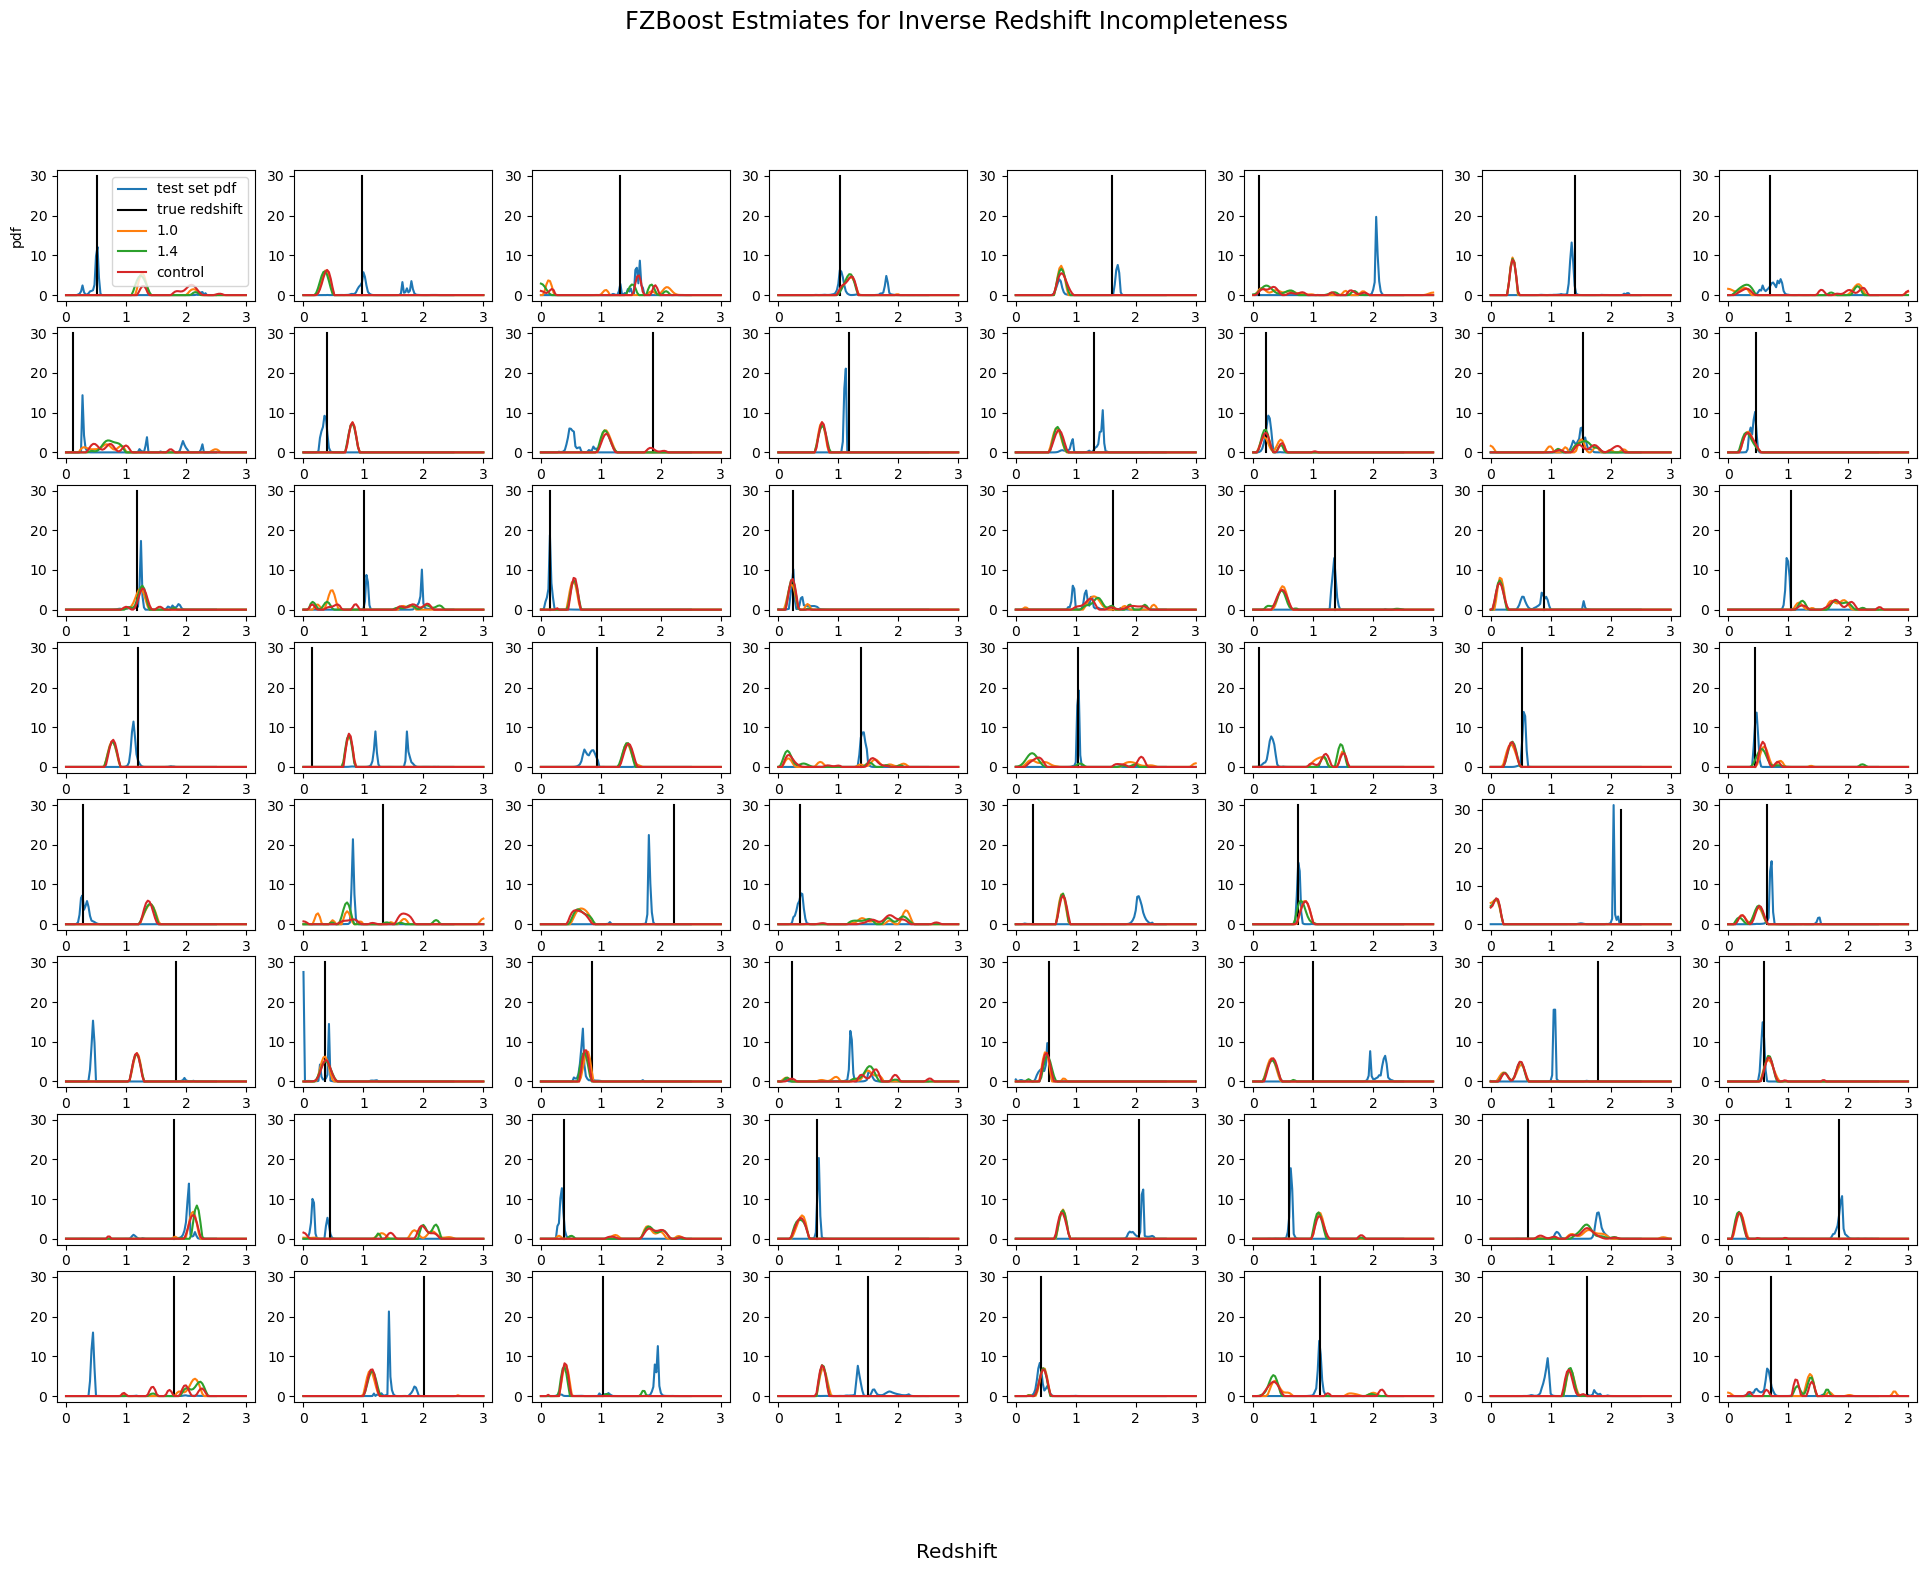

In [315]:
makePlots('FZBoost','invz', 8, 24)

In [389]:
est_ls = ['TrainZ', 'CMNN', 'GPz', "FZBoost"]
spec_ls = ['BOSS', 'DEEP2', 'GAMA', 'HSC', 'VVDSf02', 'zCOSMOS']
pivot_ls = ['1.0', '1.4', 'control']

def makeFiles(survey_pivot, type):
    spec_files = []
    invz_files = []
    if type == 'spec':
        for est in est_ls:
            spec_file = h5py.File('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_'+est+'/outputs/'+survey_pivot+'/output_estimate_'+est+'.hdf5', 'r')
            spec_files.append(spec_file)
        return spec_files
    if type == 'invz':
        for est in est_ls:
            invz_file = h5py.File('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_'+est+'/outputs/'+survey_pivot+'/output_estimate_'+est+'.hdf5', 'r')
            invz_files.append(invz_file)
        return invz_files

def makePlots2(survey_pivot, type, dim, size):

    fig, axes = plt.subplots(nrows = dim, ncols = dim, figsize = (size, (2/3)*size)) 
    ct = 0
    for i in range(0, dim):
        for j in range(0, dim):
            axes[i][j].plot(ztrue_posts['meta']['xvals'][0], ztrue_posts['data']['yvals'][ct], label = "test set pdf") 
            axes[i][j].plot(true_point_zs['redshift'][ct]*np.ones(101), np.linspace(0, 30, 101), color = 'k', label = 'true redshift')

            val = 0
            for file in makeFiles(survey_pivot, type):
                #print(file)
                if 'TrainZ' in str(file) or 'FZBoost' in str(file):
                    axes[i][j].plot(file['meta']['xvals'][0], file['data']['yvals'][ct], label = est_ls[val])
                if 'CMNN' in str(file) or 'GPz' in str(file):
                    arr = ztrue_posts['meta']['xvals'][0]
                    axes[i][j].plot(arr, (1. /(file['data']['scale'][ct] * np.sqrt(2*np.pi))) * np.exp((-1/2) * ((arr - file['data']['loc'][ct])/ file['data']['scale'][ct] )**2) , label = est_ls[val])
                val += 1
            axes[0][0].legend()
            ct += 1
    if type == 'spec':
        fig.suptitle(survey_pivot+" Training Set Degradation Estimations", size = 'xx-large')
    elif type == 'invz' and survey_pivot == 'control':
        fig.suptitle("Undegraded Training Set Estimations", size = 'xx-large')
    else:
        fig.suptitle("Inverse Redshift Incompleteness, pivot = "+survey_pivot+" Estimations", size = 'xx-large')
    fig.supxlabel("Redshift", size = 'x-large')
    #fig.supylabel("pdf", size = 'x-large')
    axes[0][0].set_ylabel("pdf")

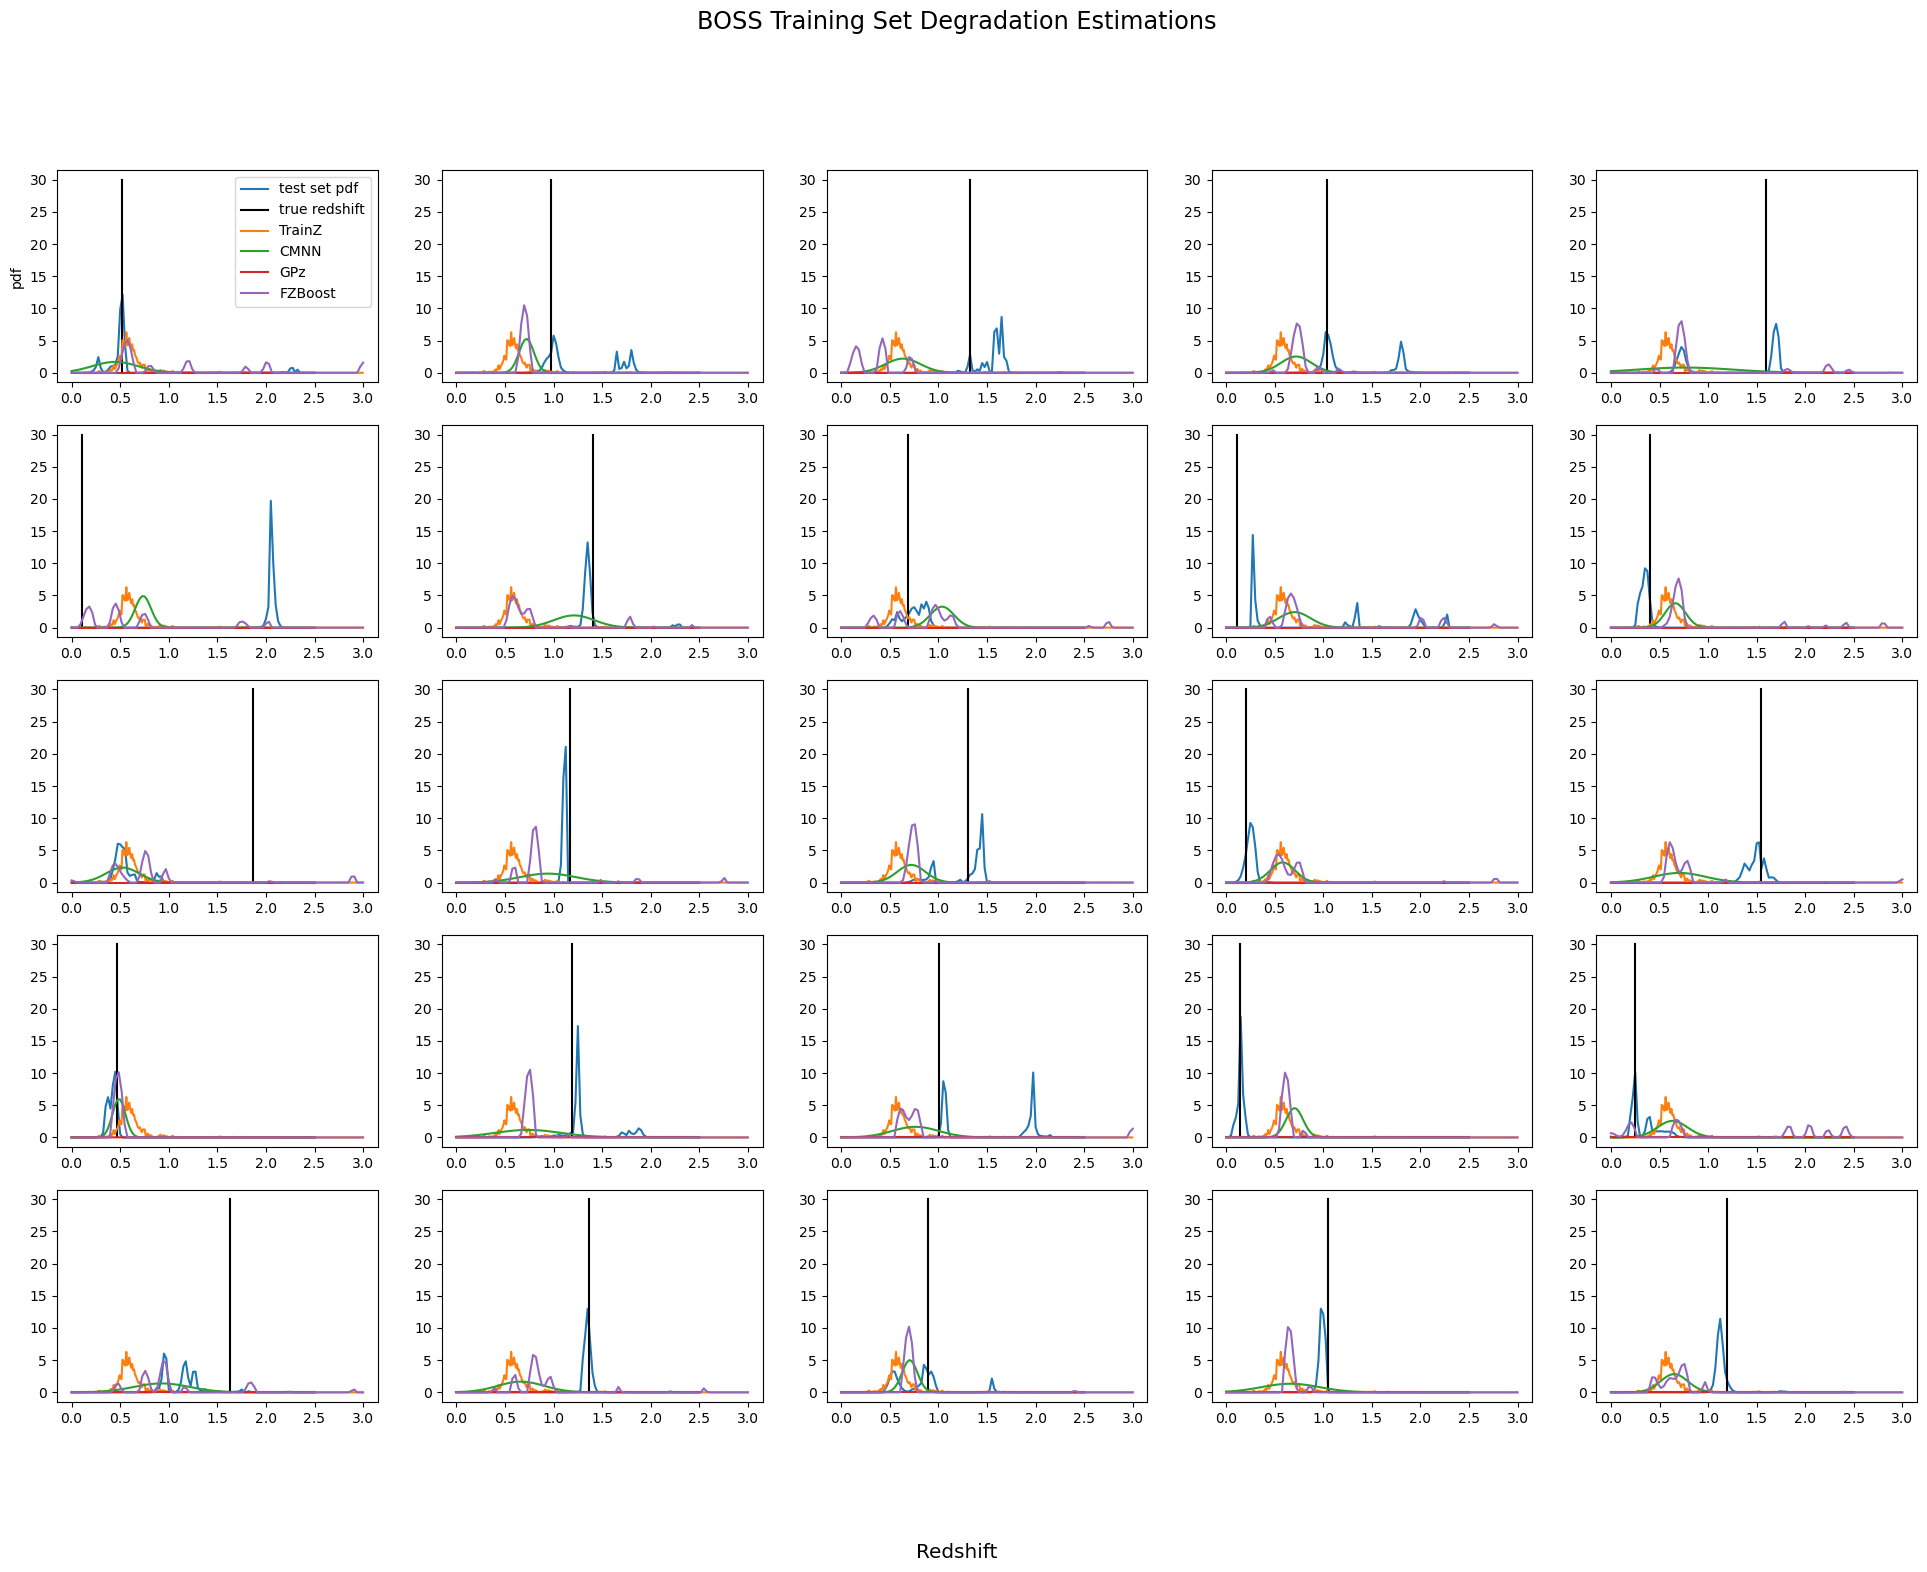

In [391]:
makePlots2('BOSS', 'spec', 5, 24)

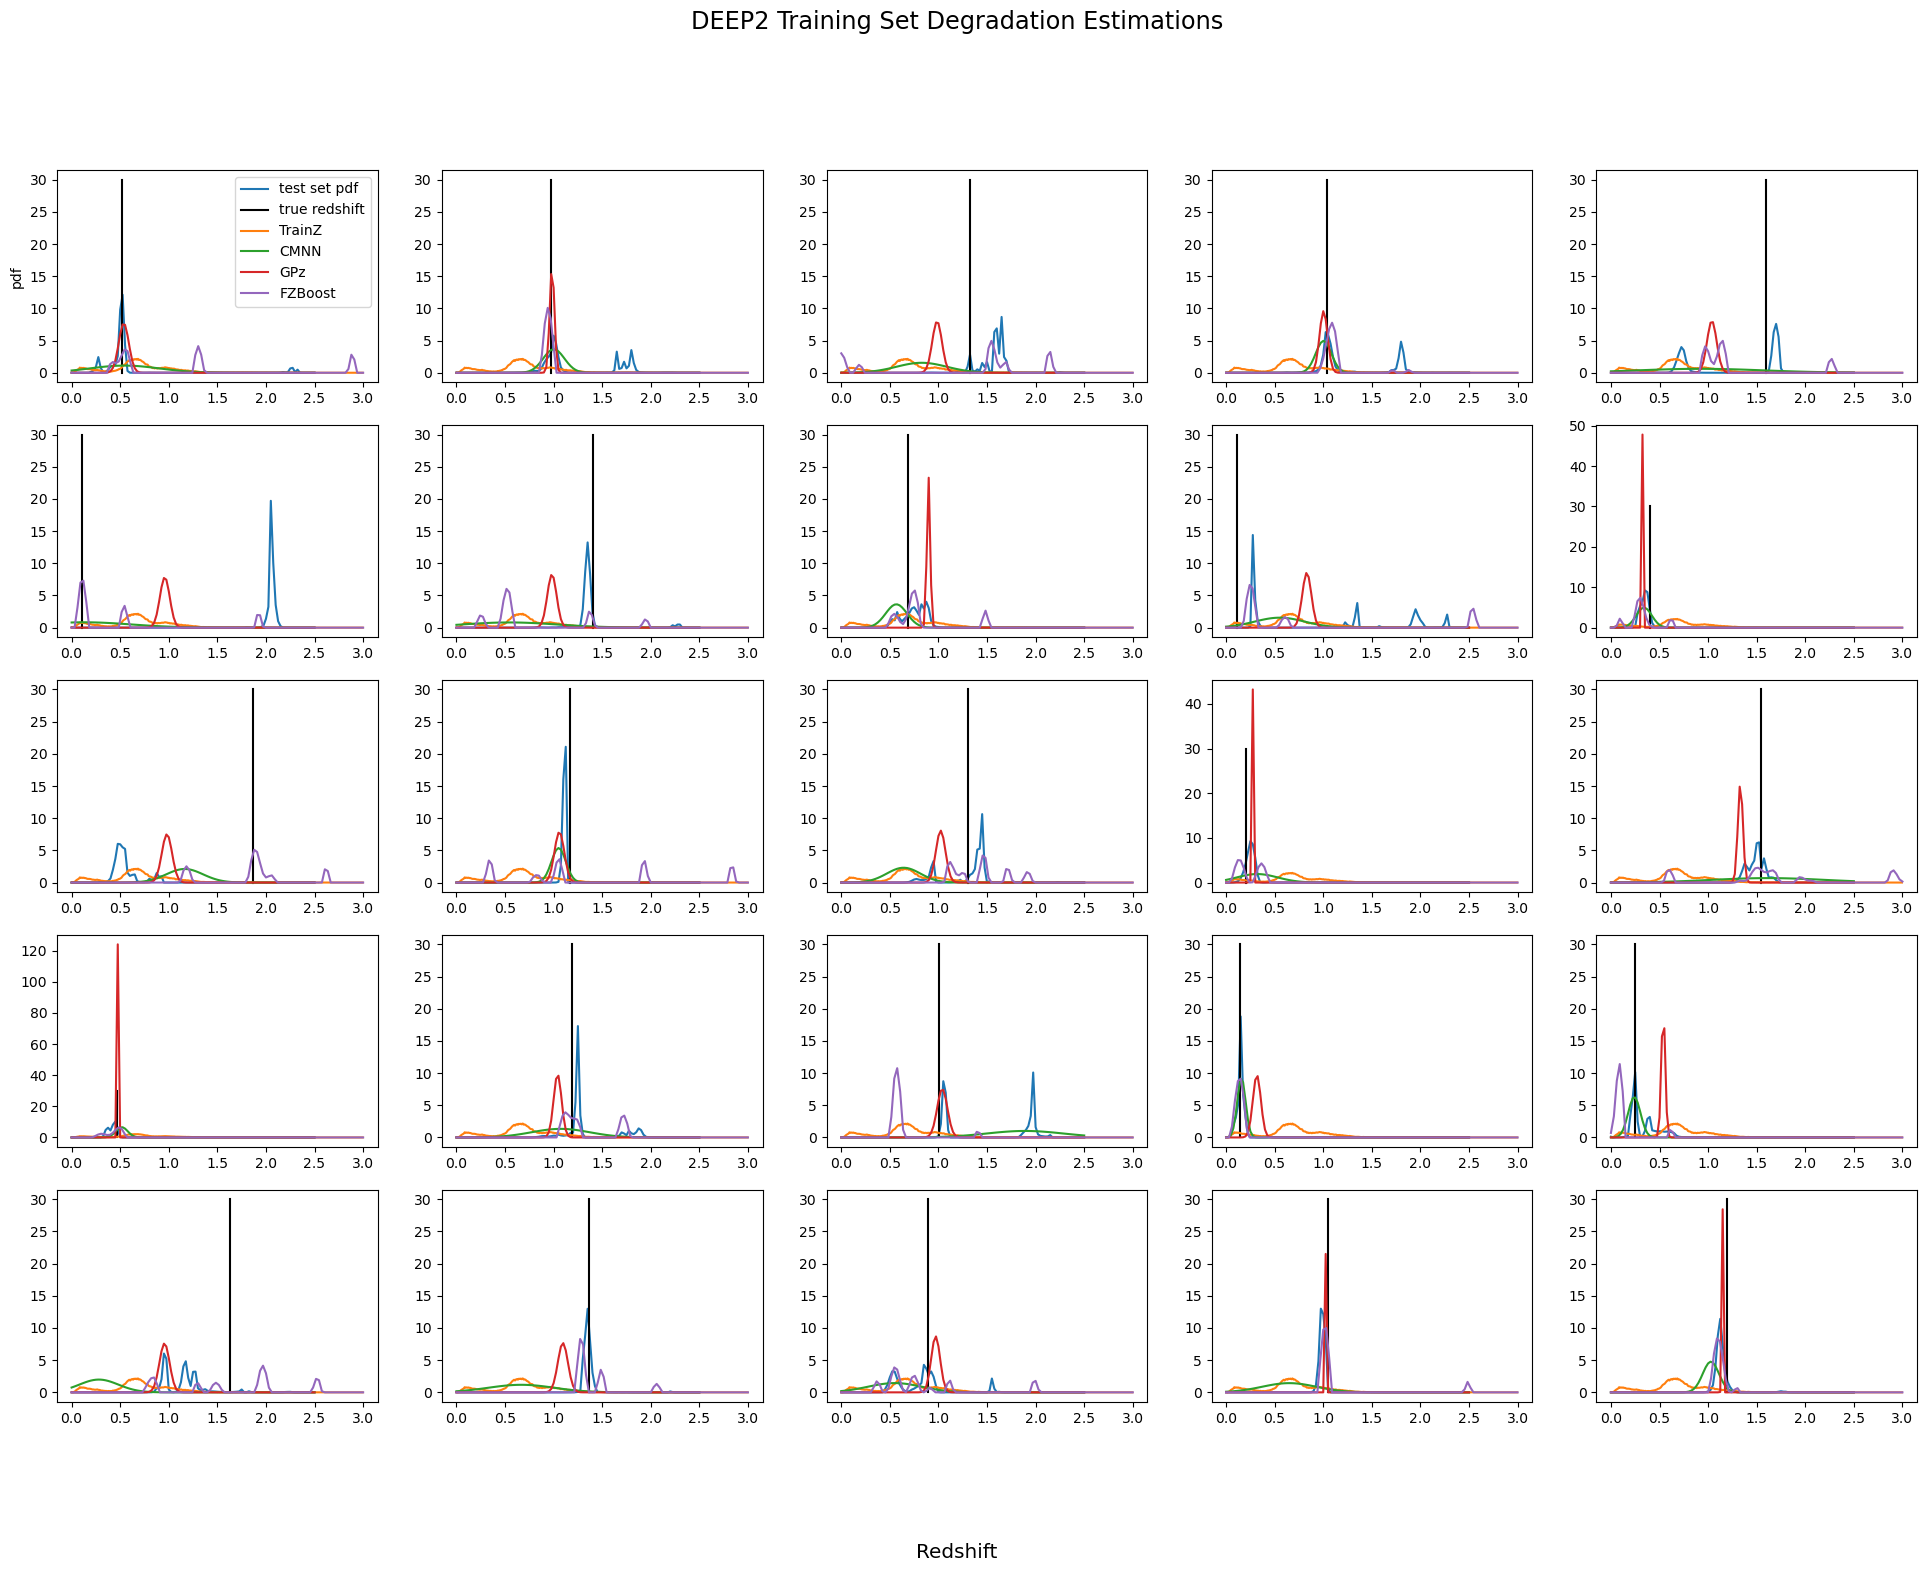

In [392]:
makePlots2('DEEP2', 'spec', 5, 24)

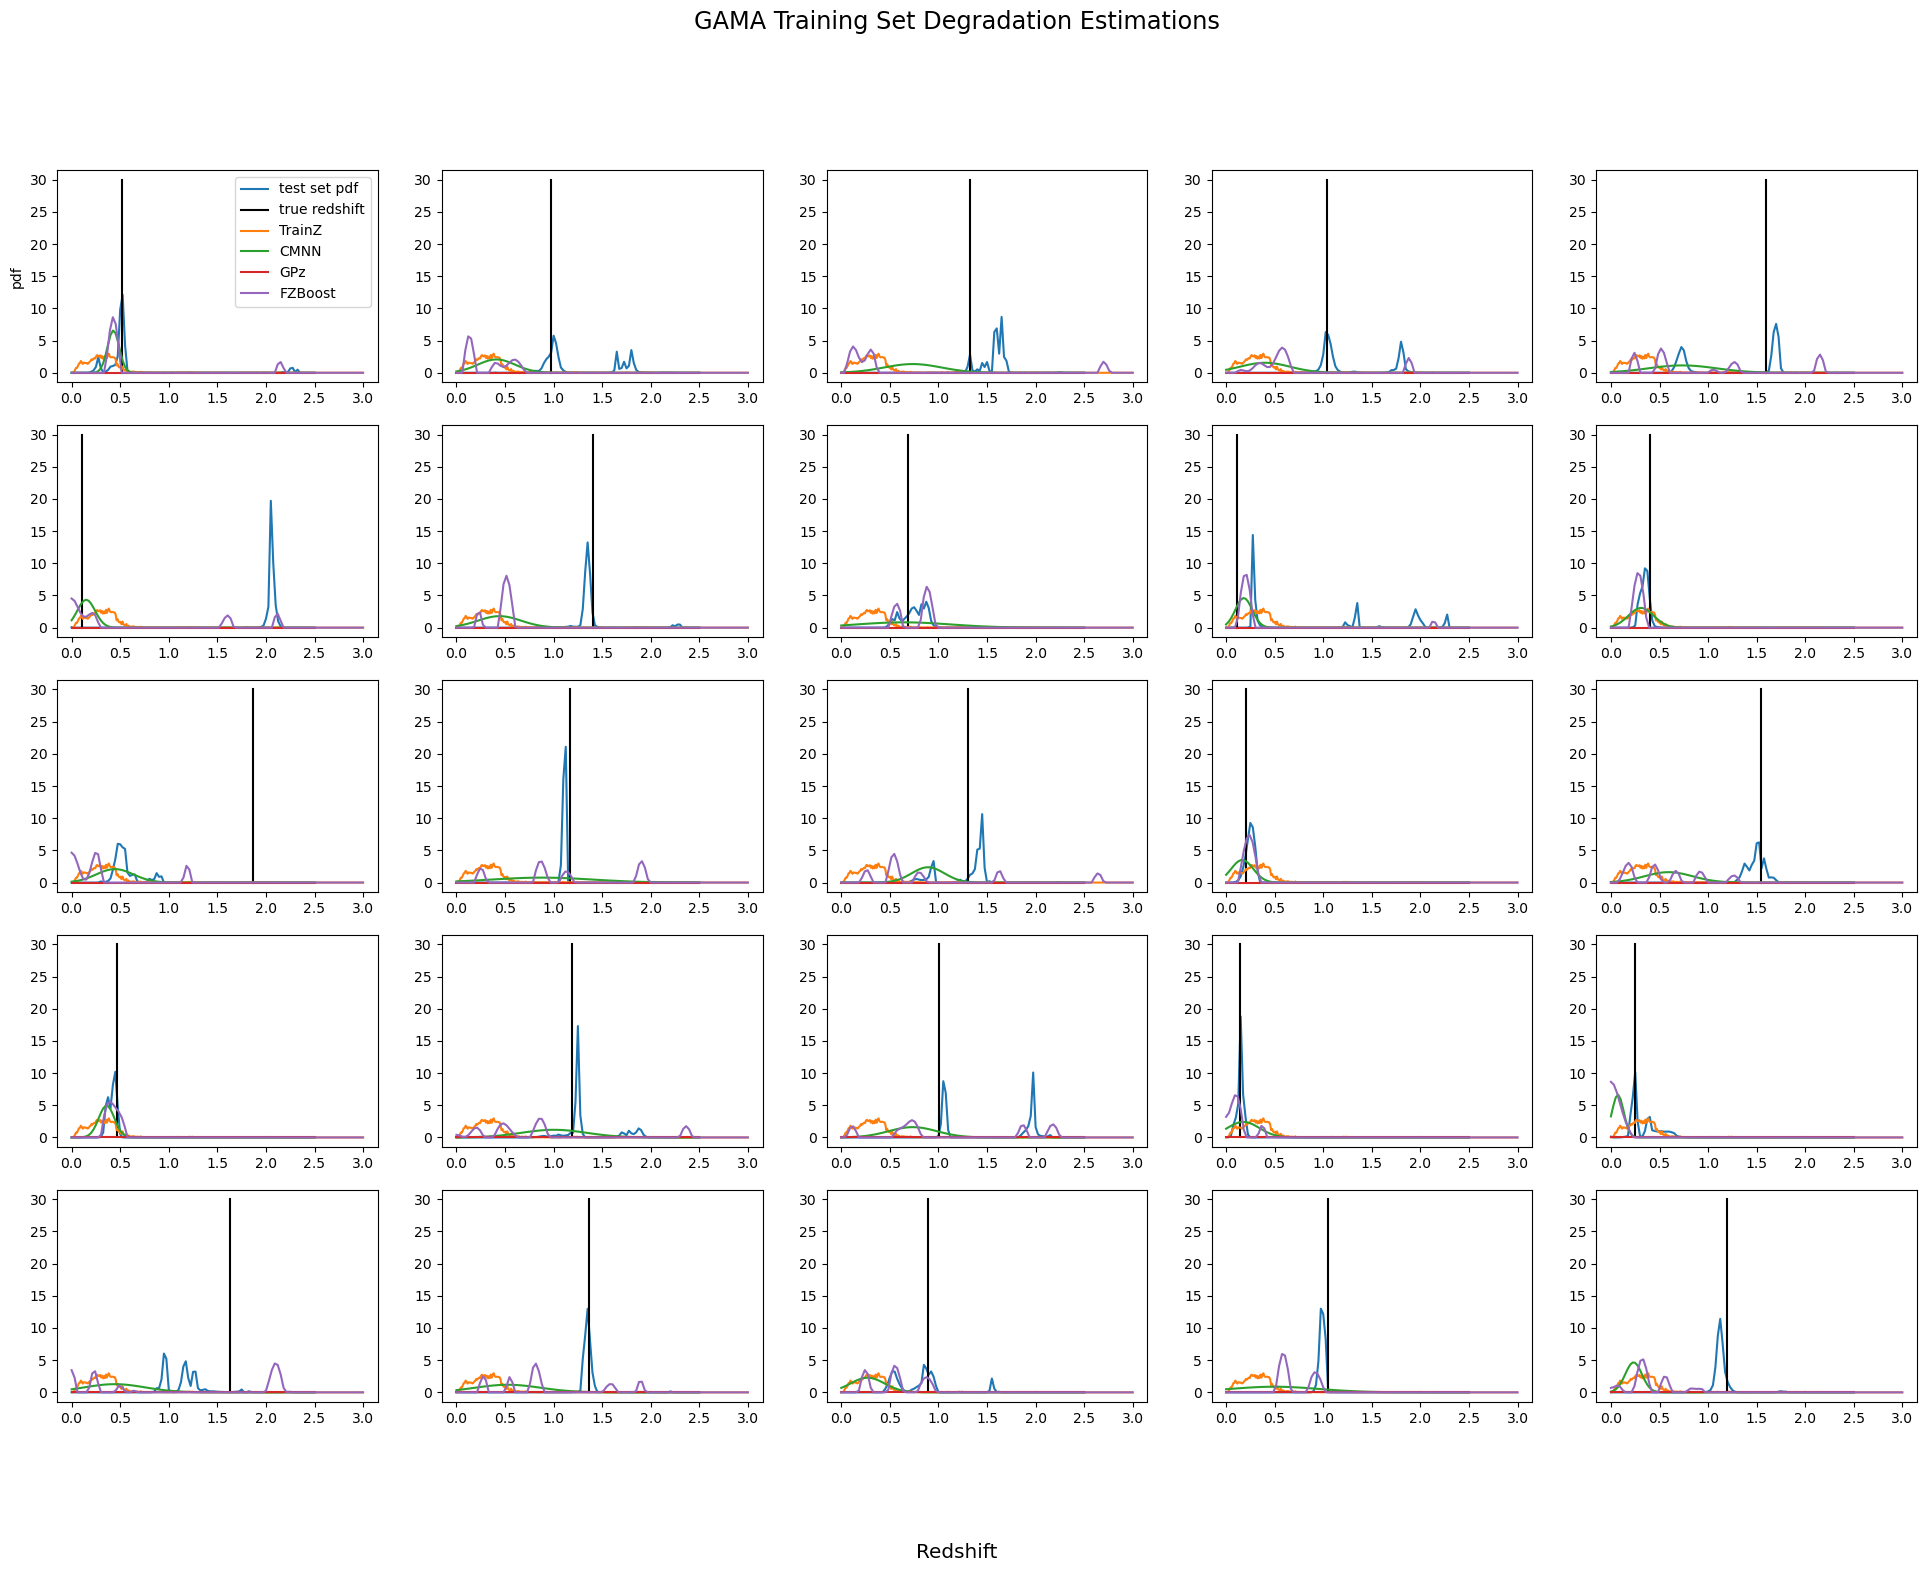

In [393]:
makePlots2('GAMA', 'spec', 5, 24)

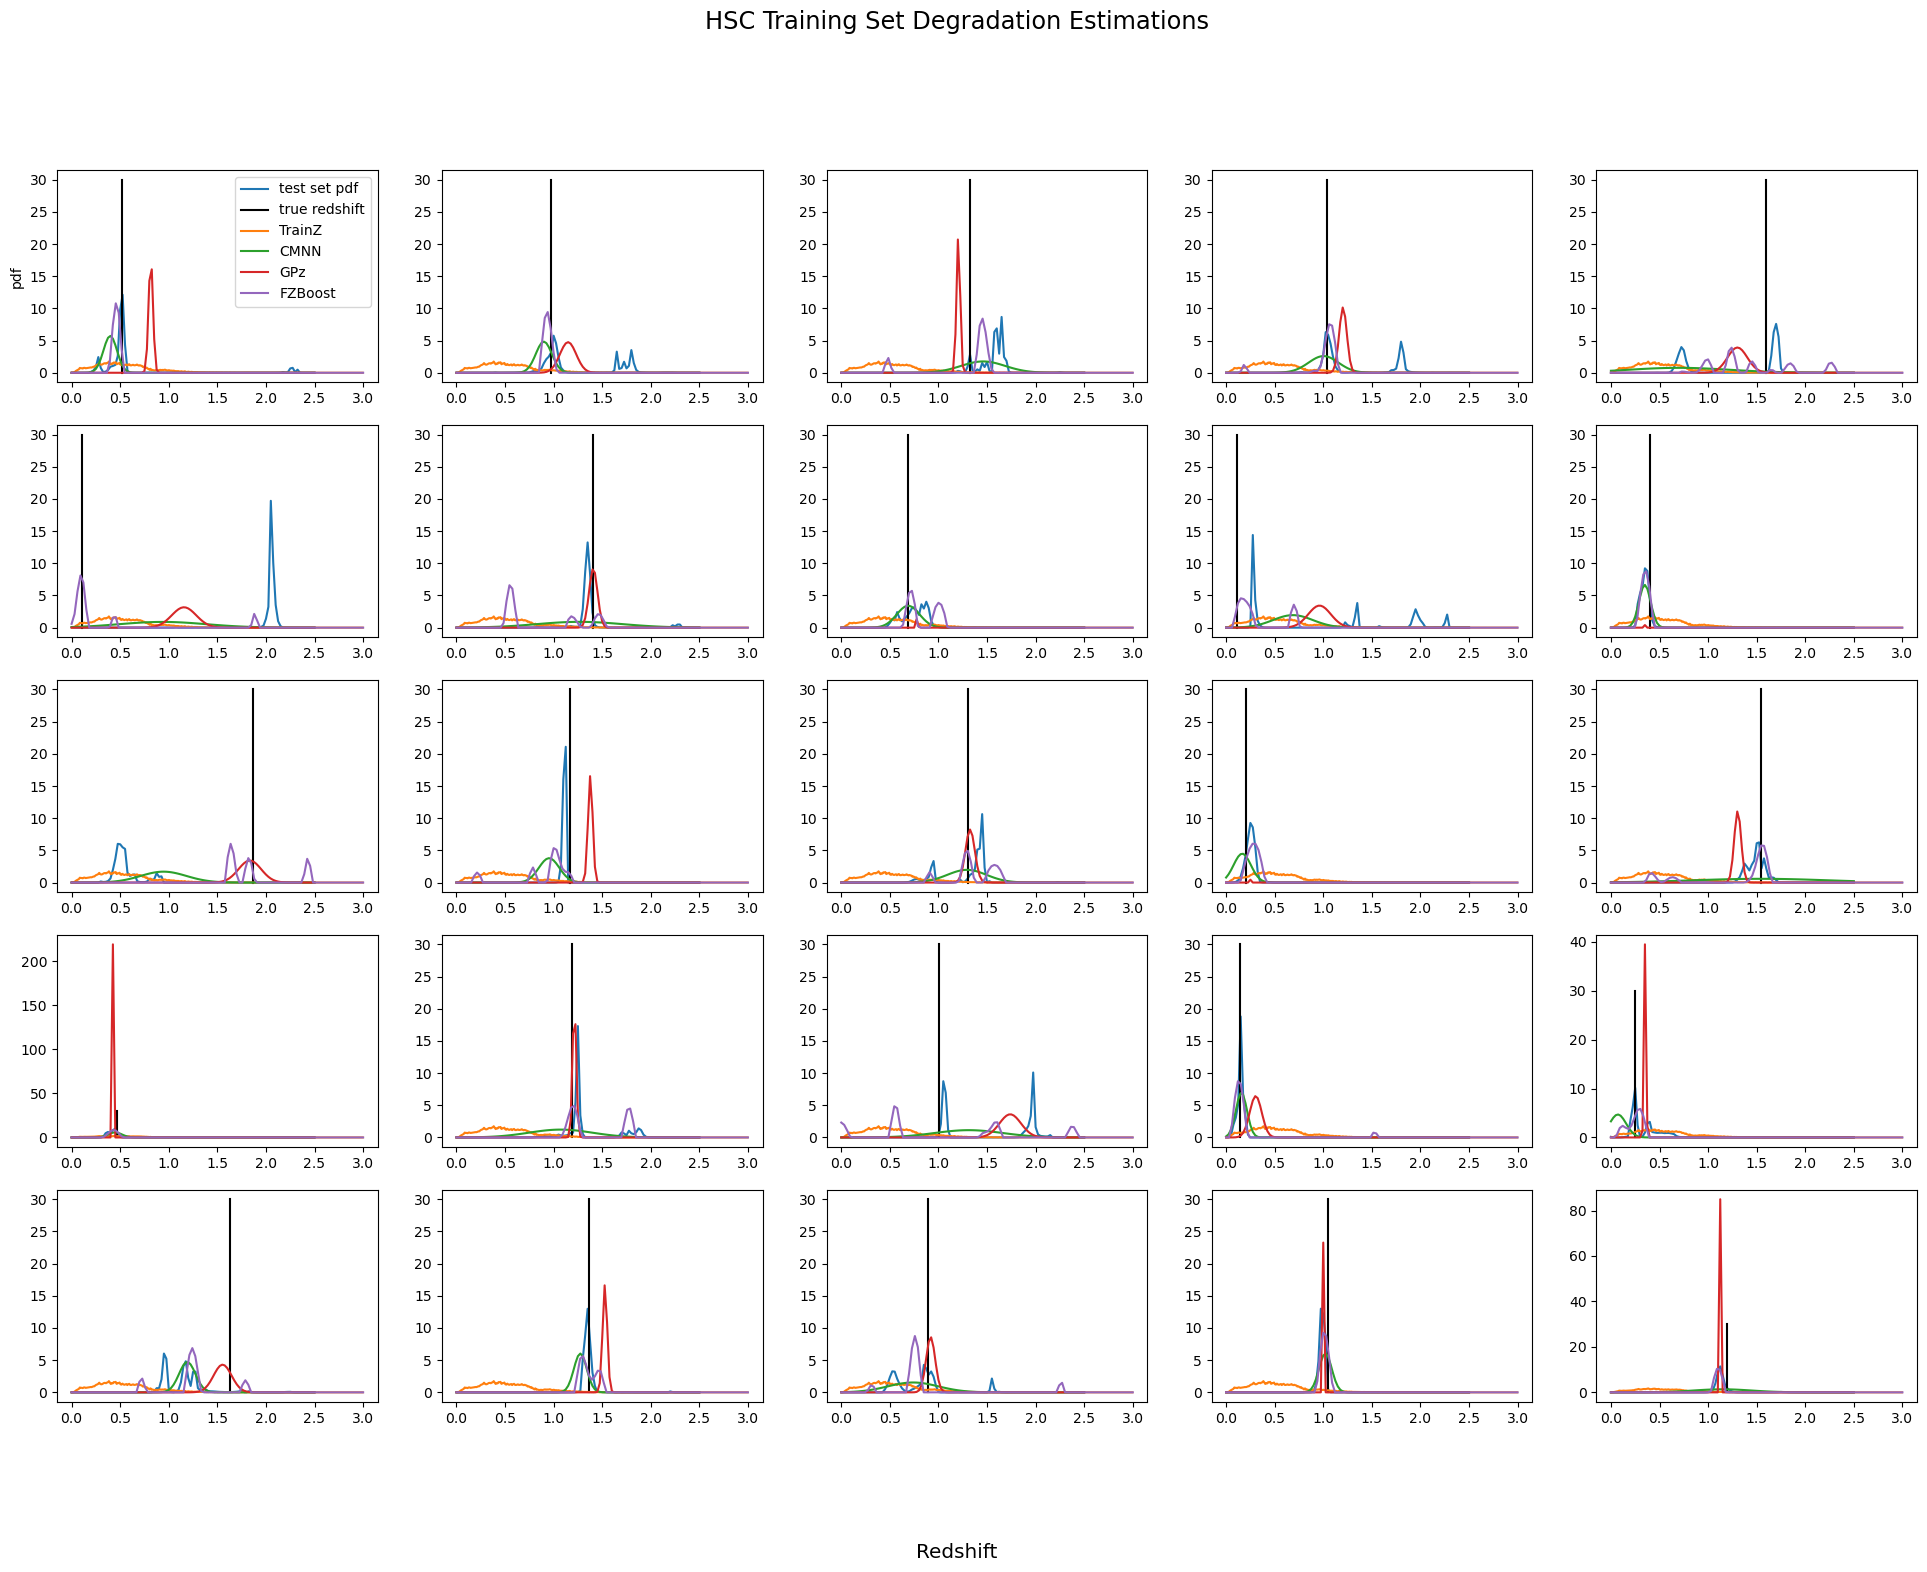

In [394]:
makePlots2('HSC', 'spec', 5, 24)

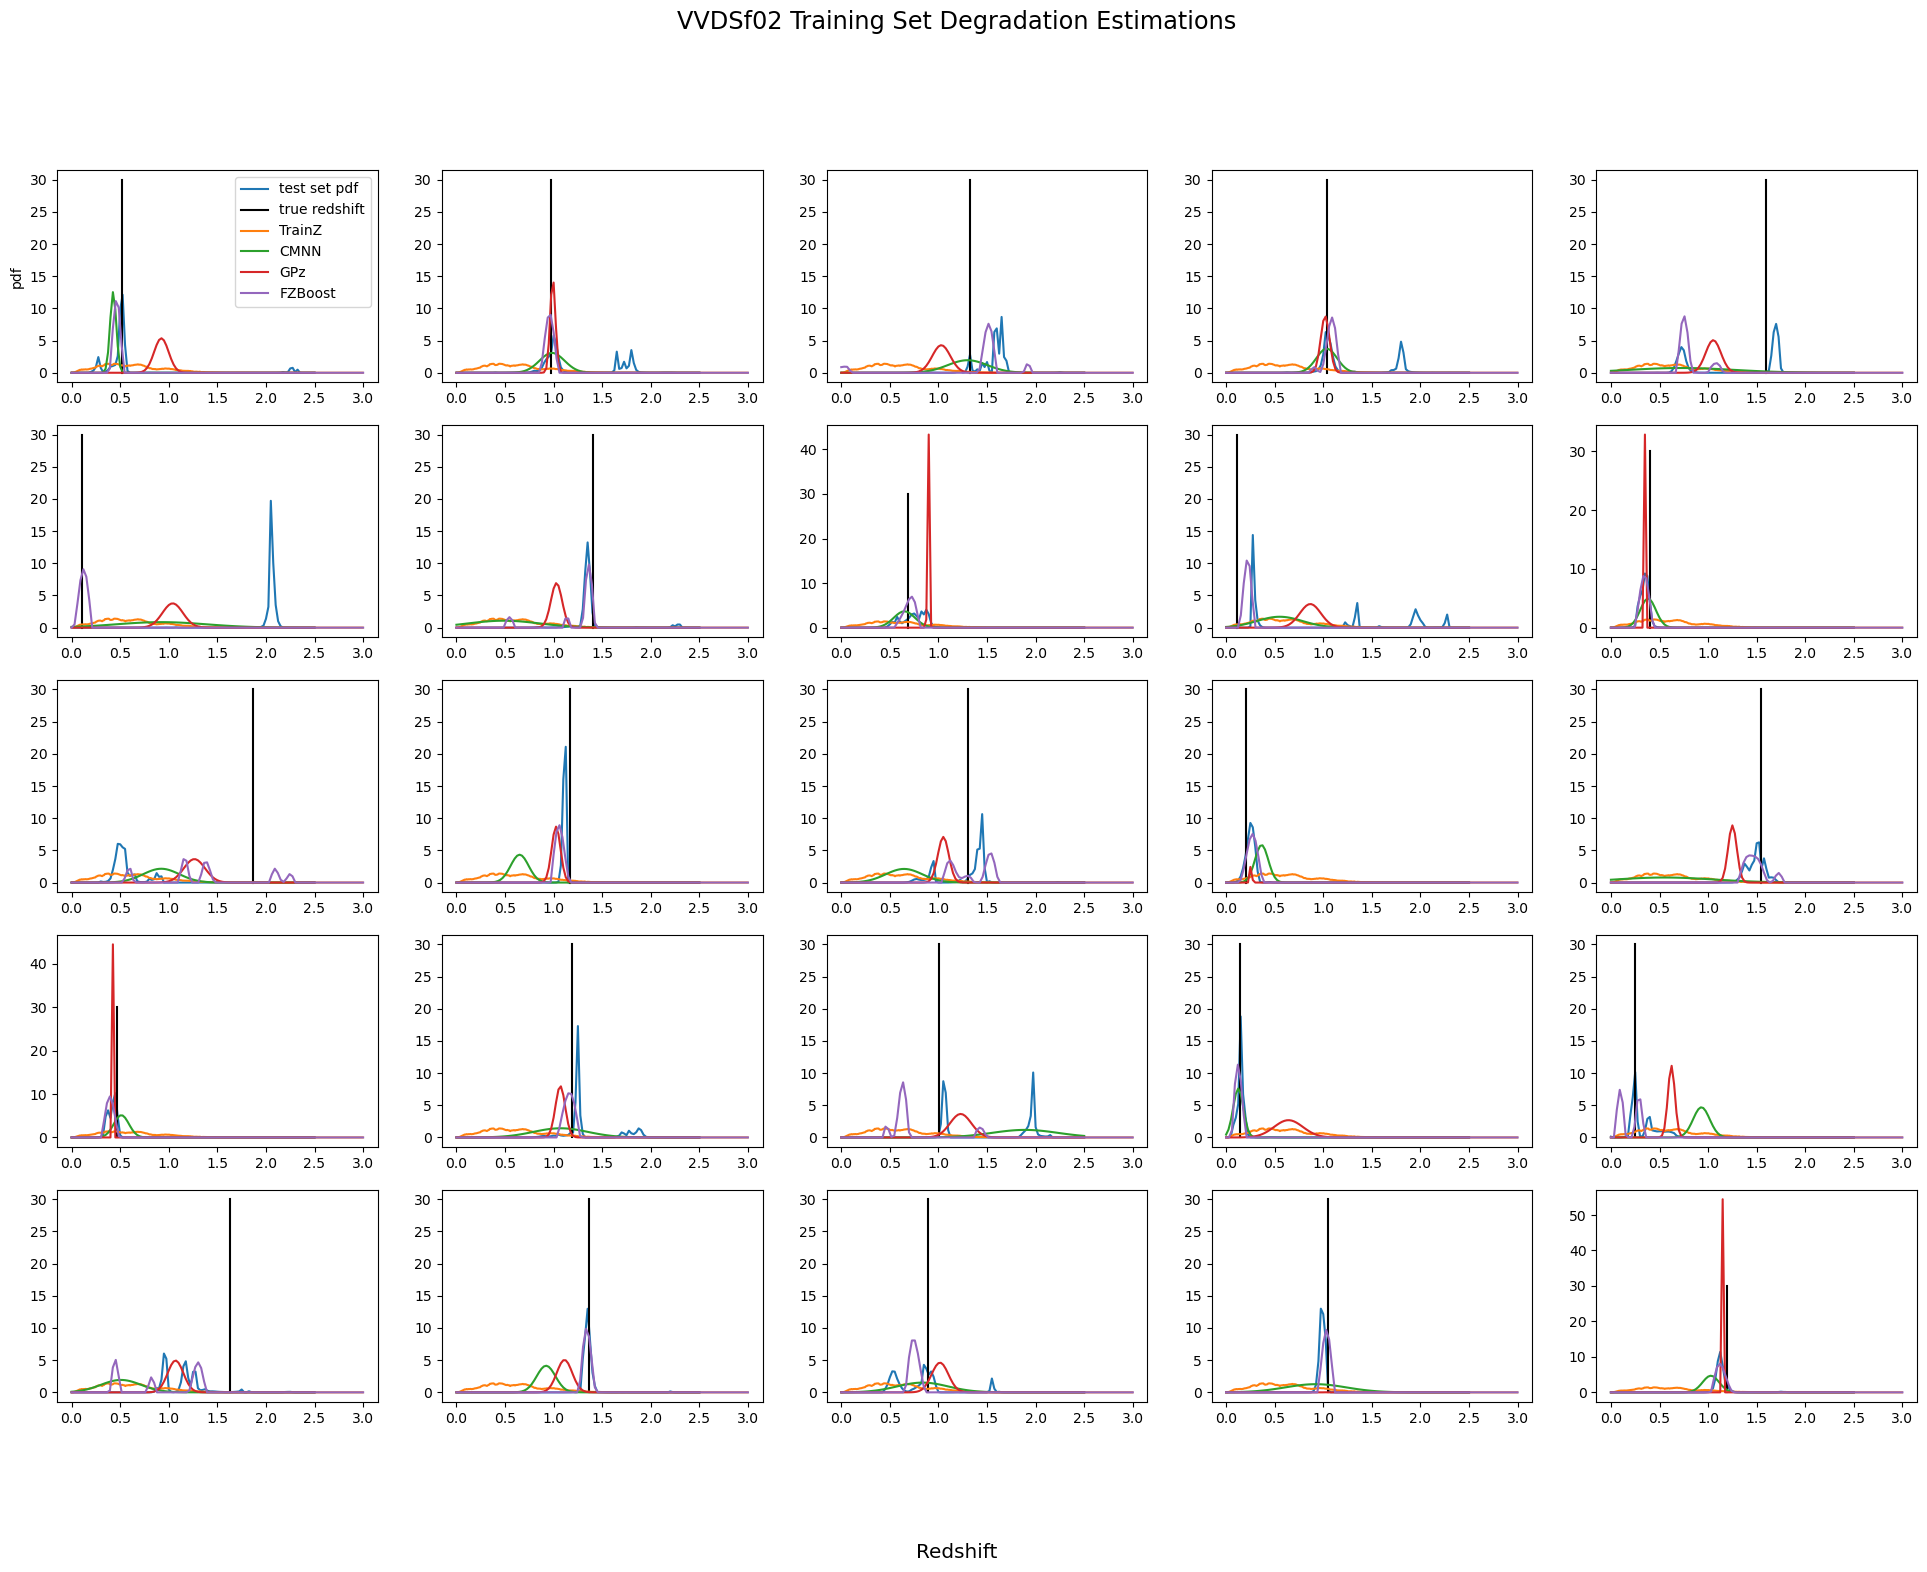

In [395]:
makePlots2('VVDSf02', 'spec', 5, 24)

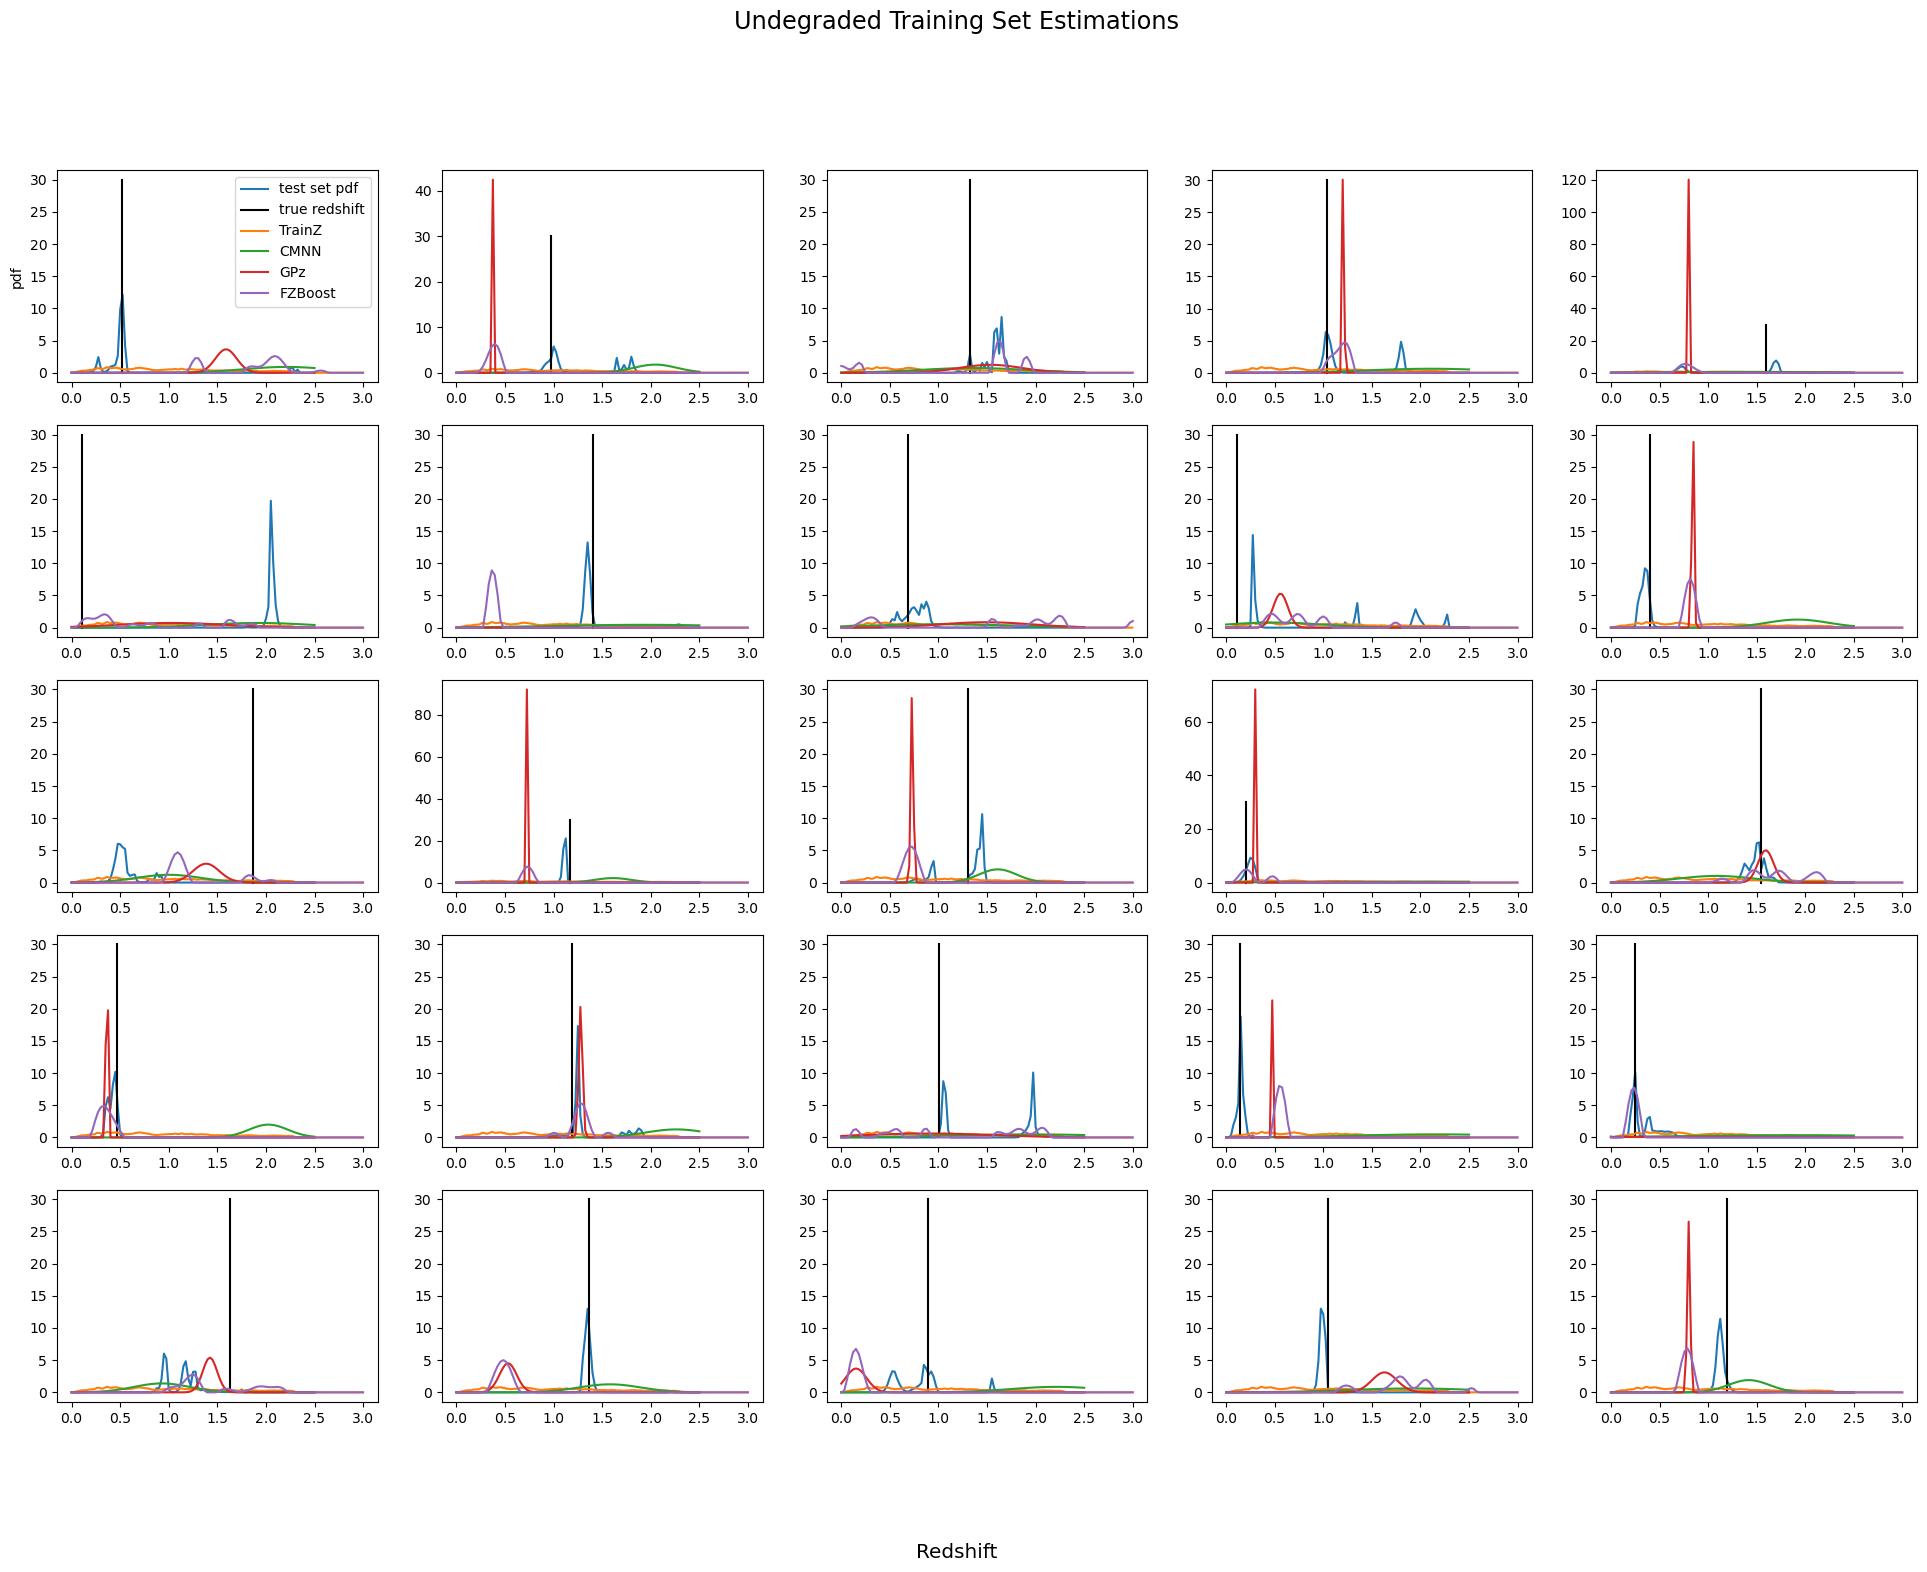

In [400]:
makePlots2('control', 'invz', 5, 24)

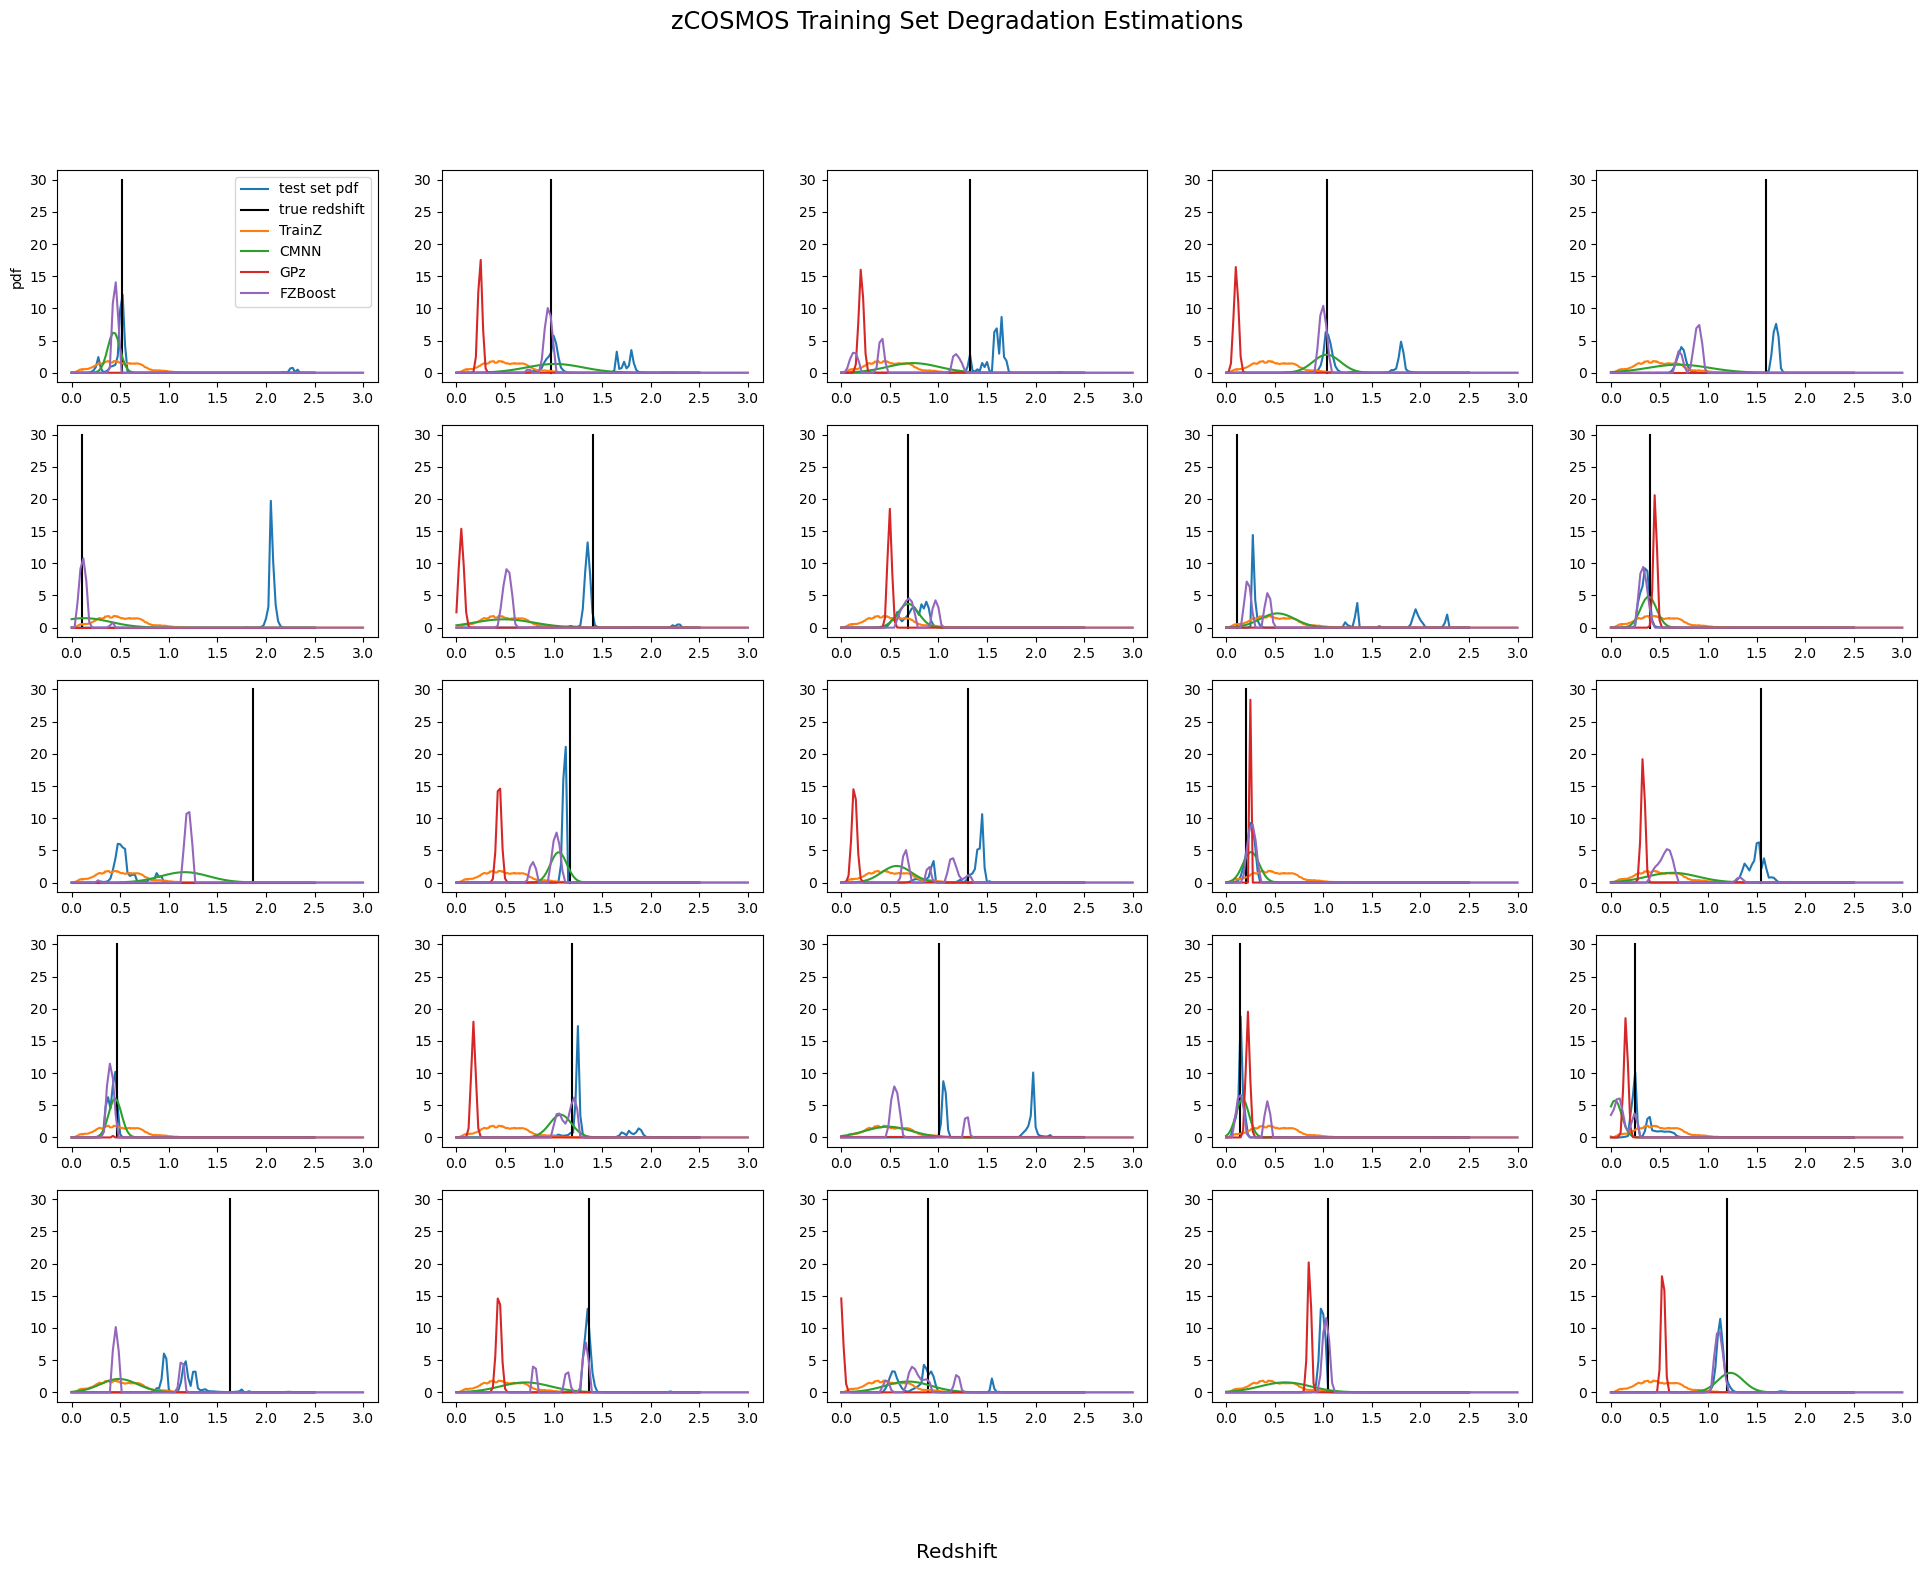

In [396]:
makePlots2('zCOSMOS', 'spec', 5, 24)

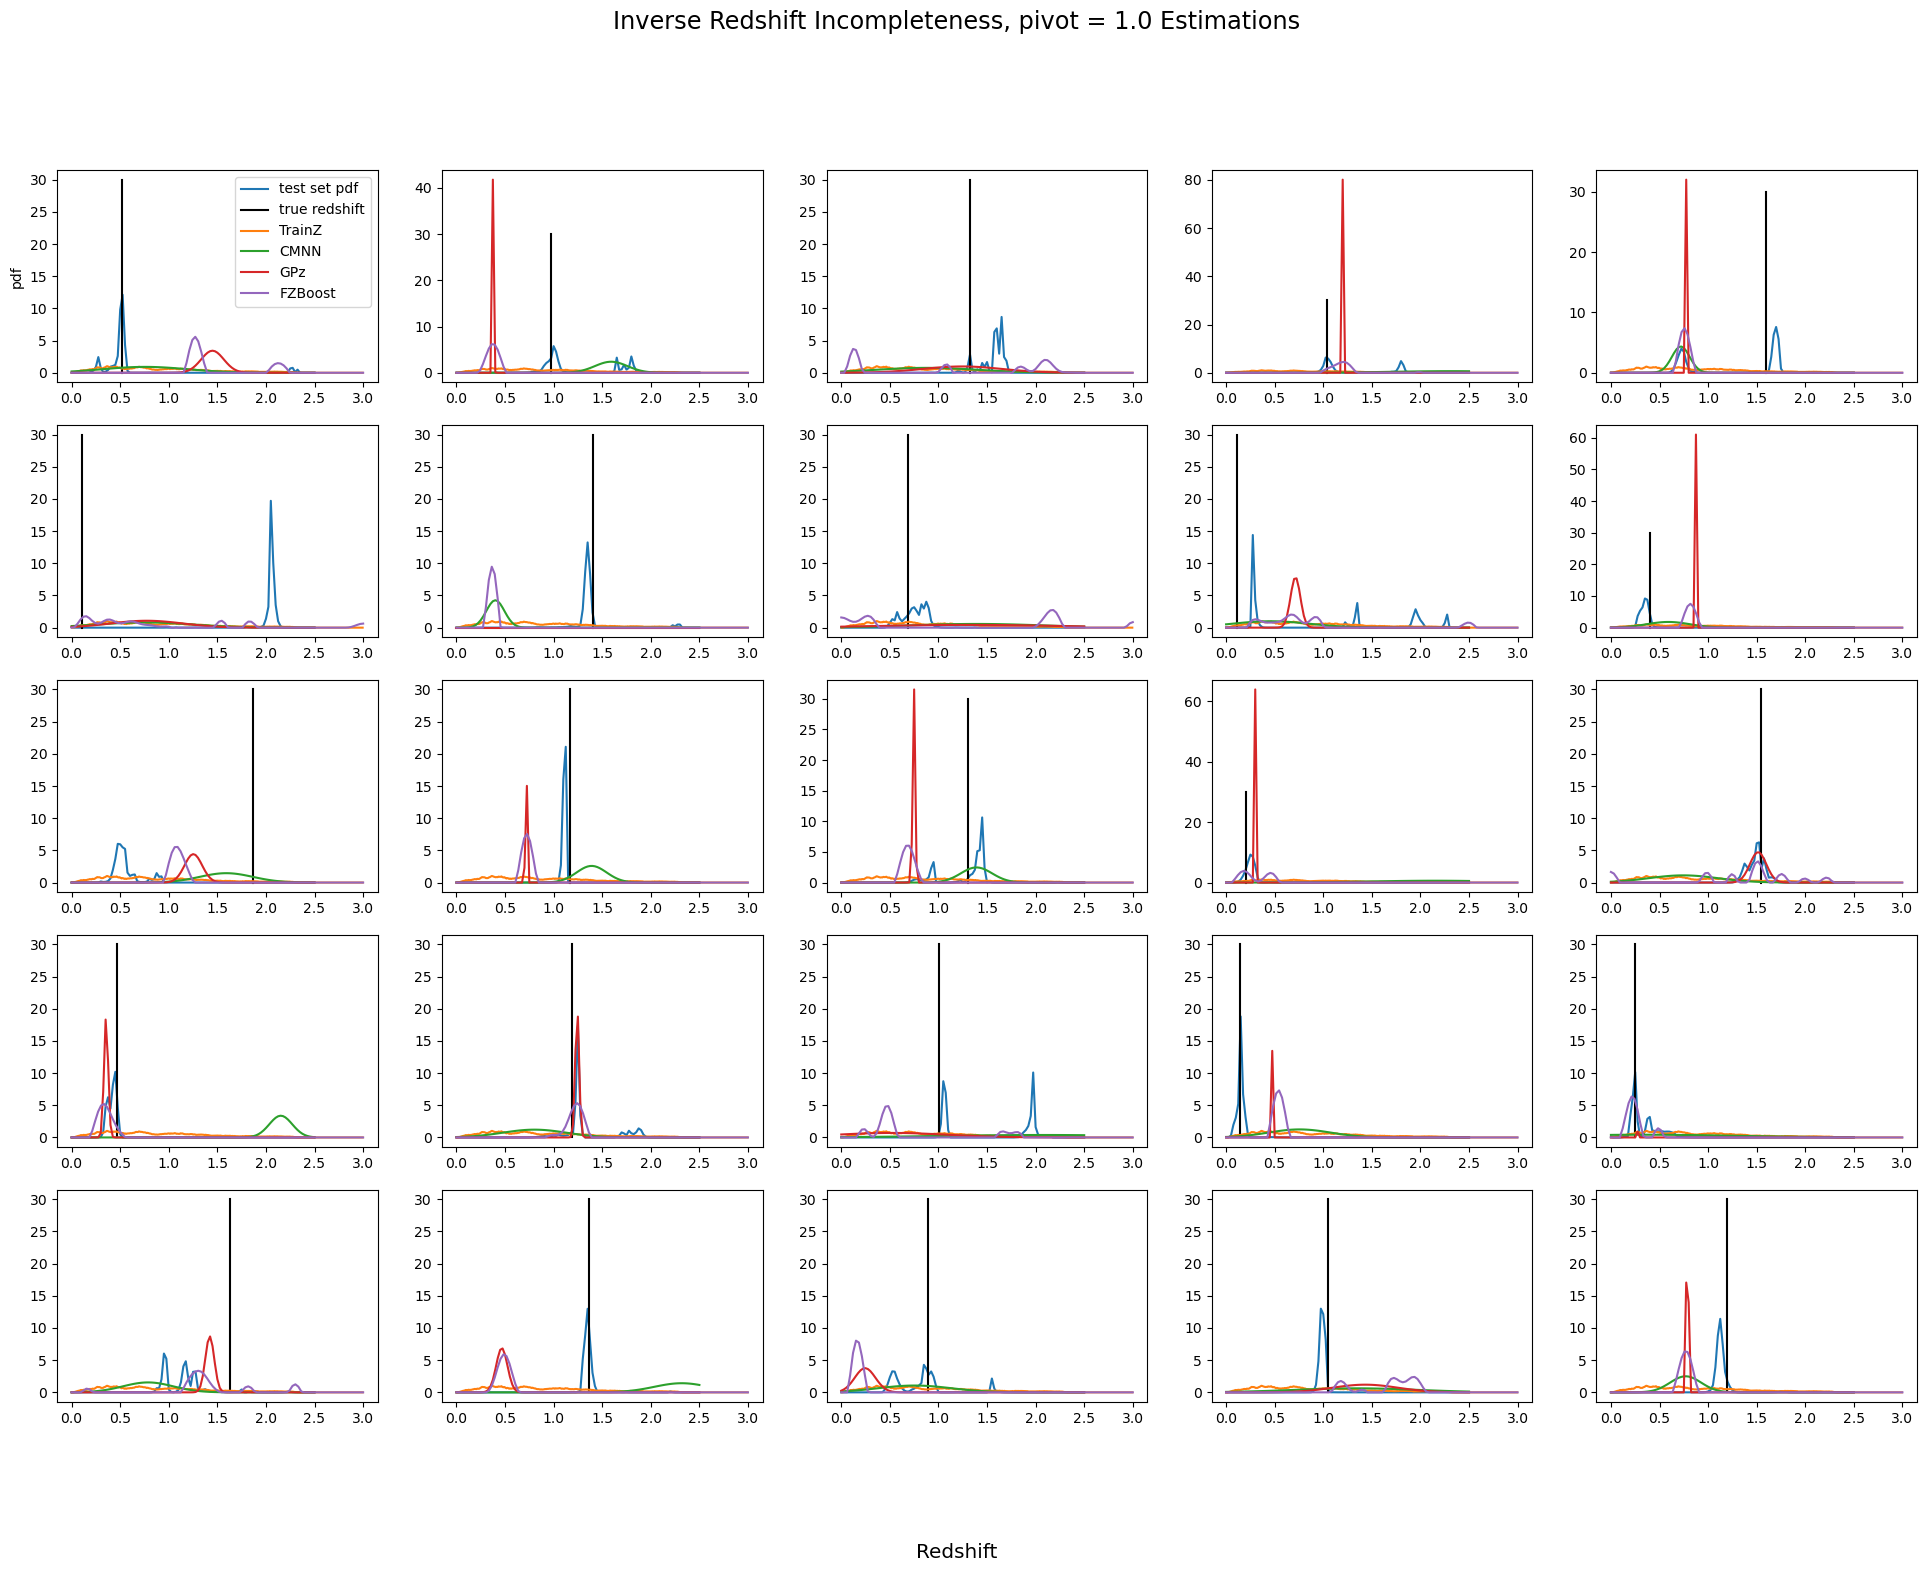

In [397]:
makePlots2('1.0', 'invz', 5, 24)

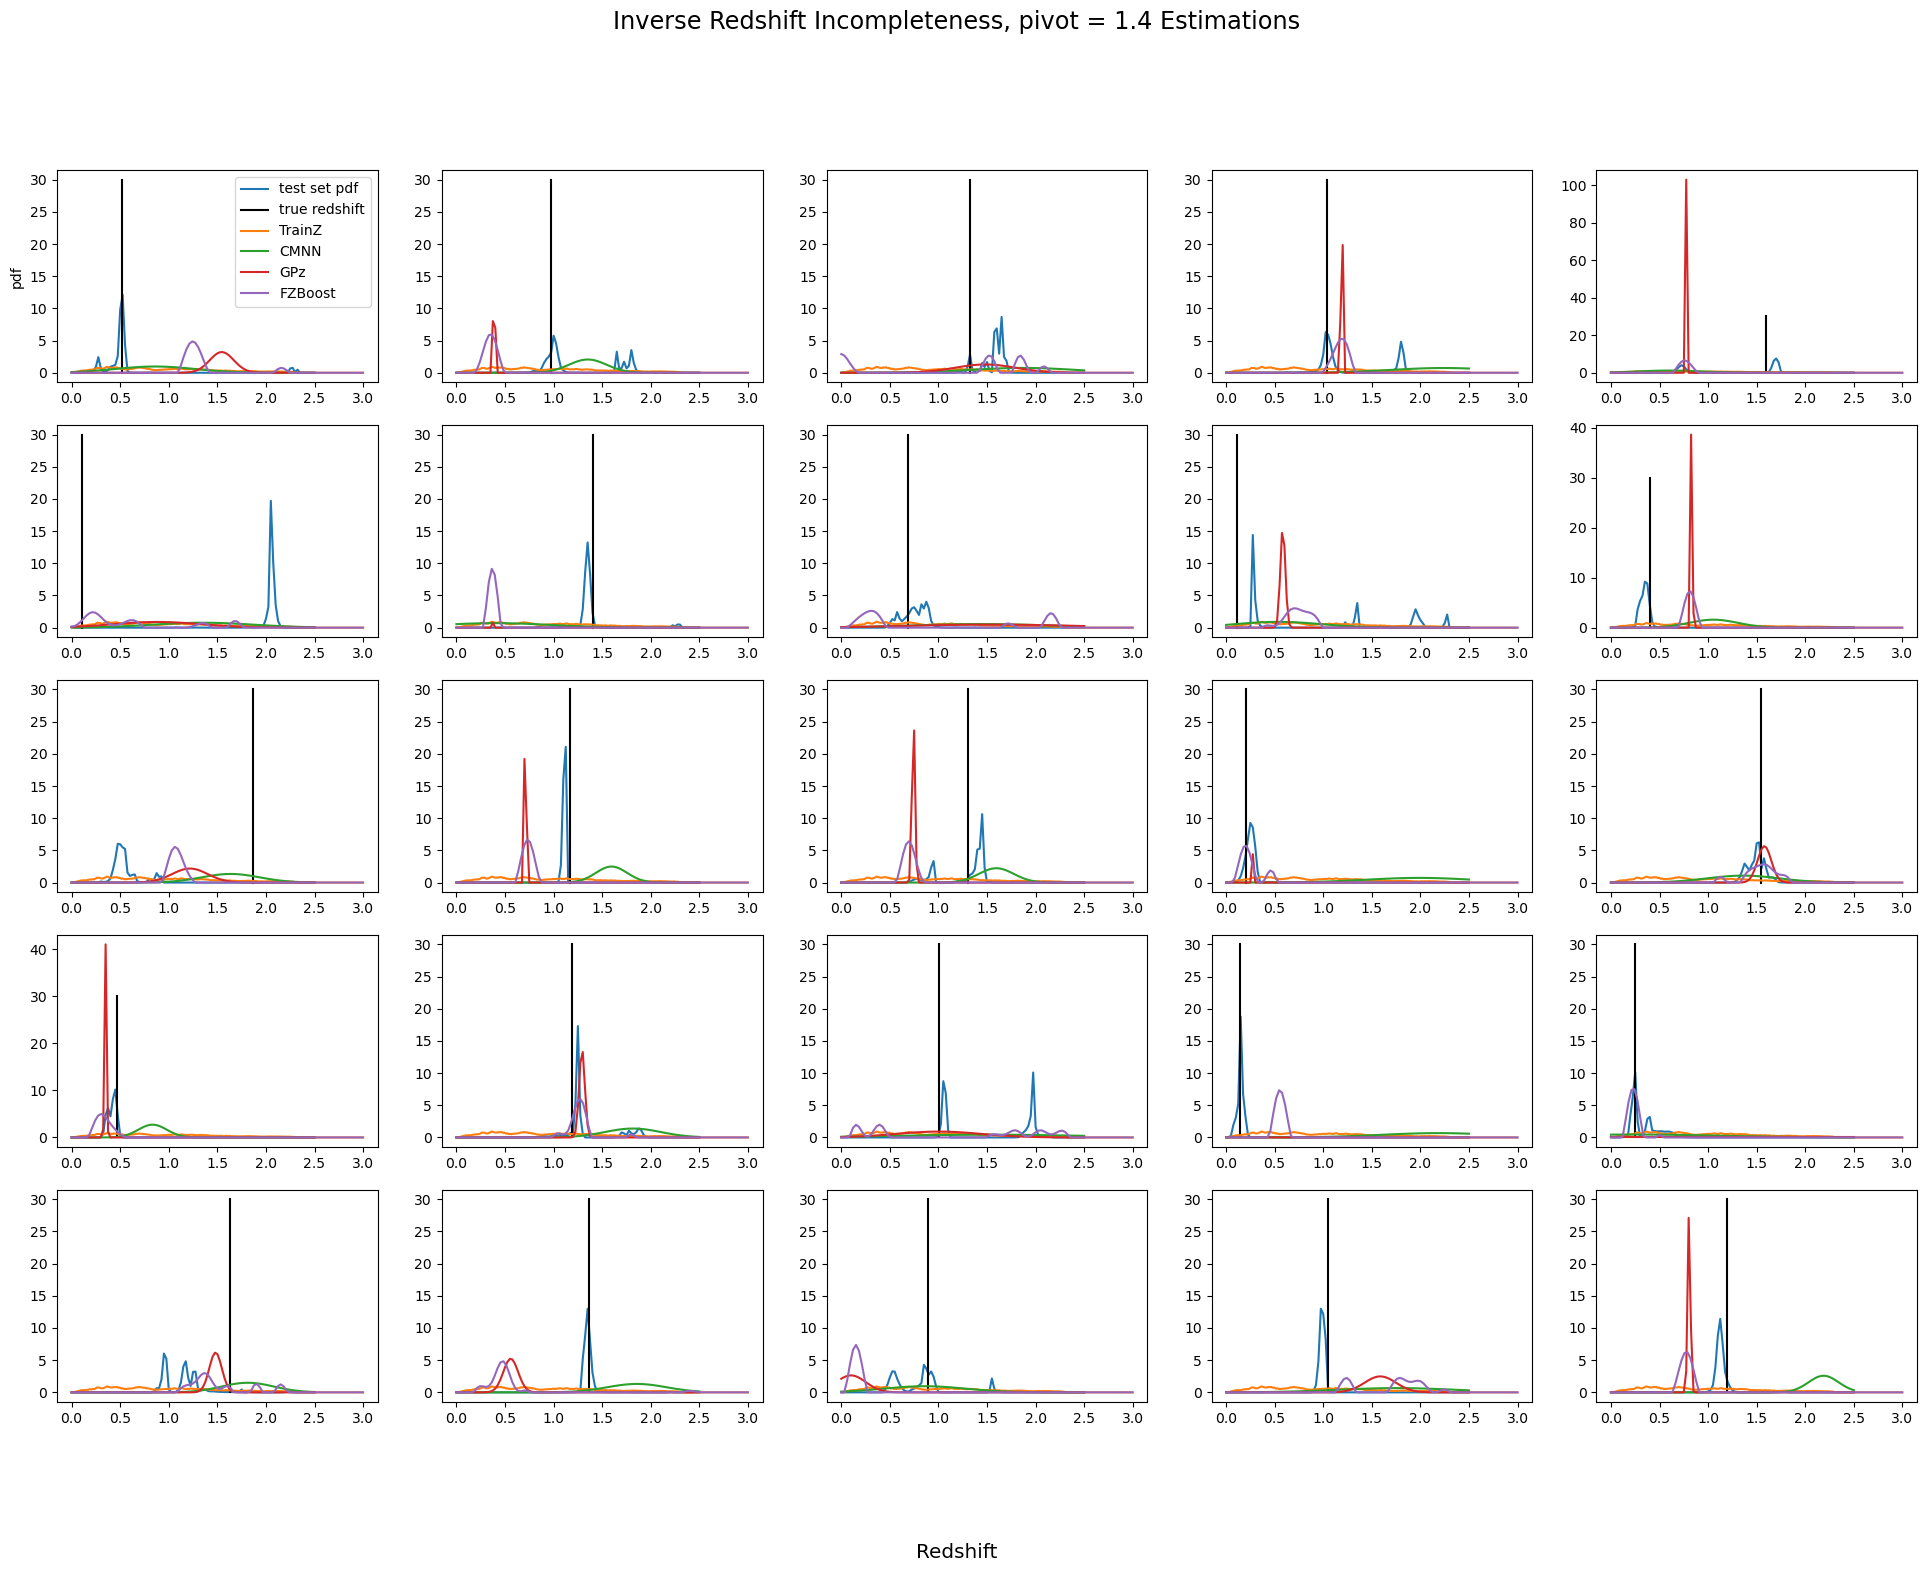

In [398]:
makePlots2('1.4', 'invz', 5, 24)

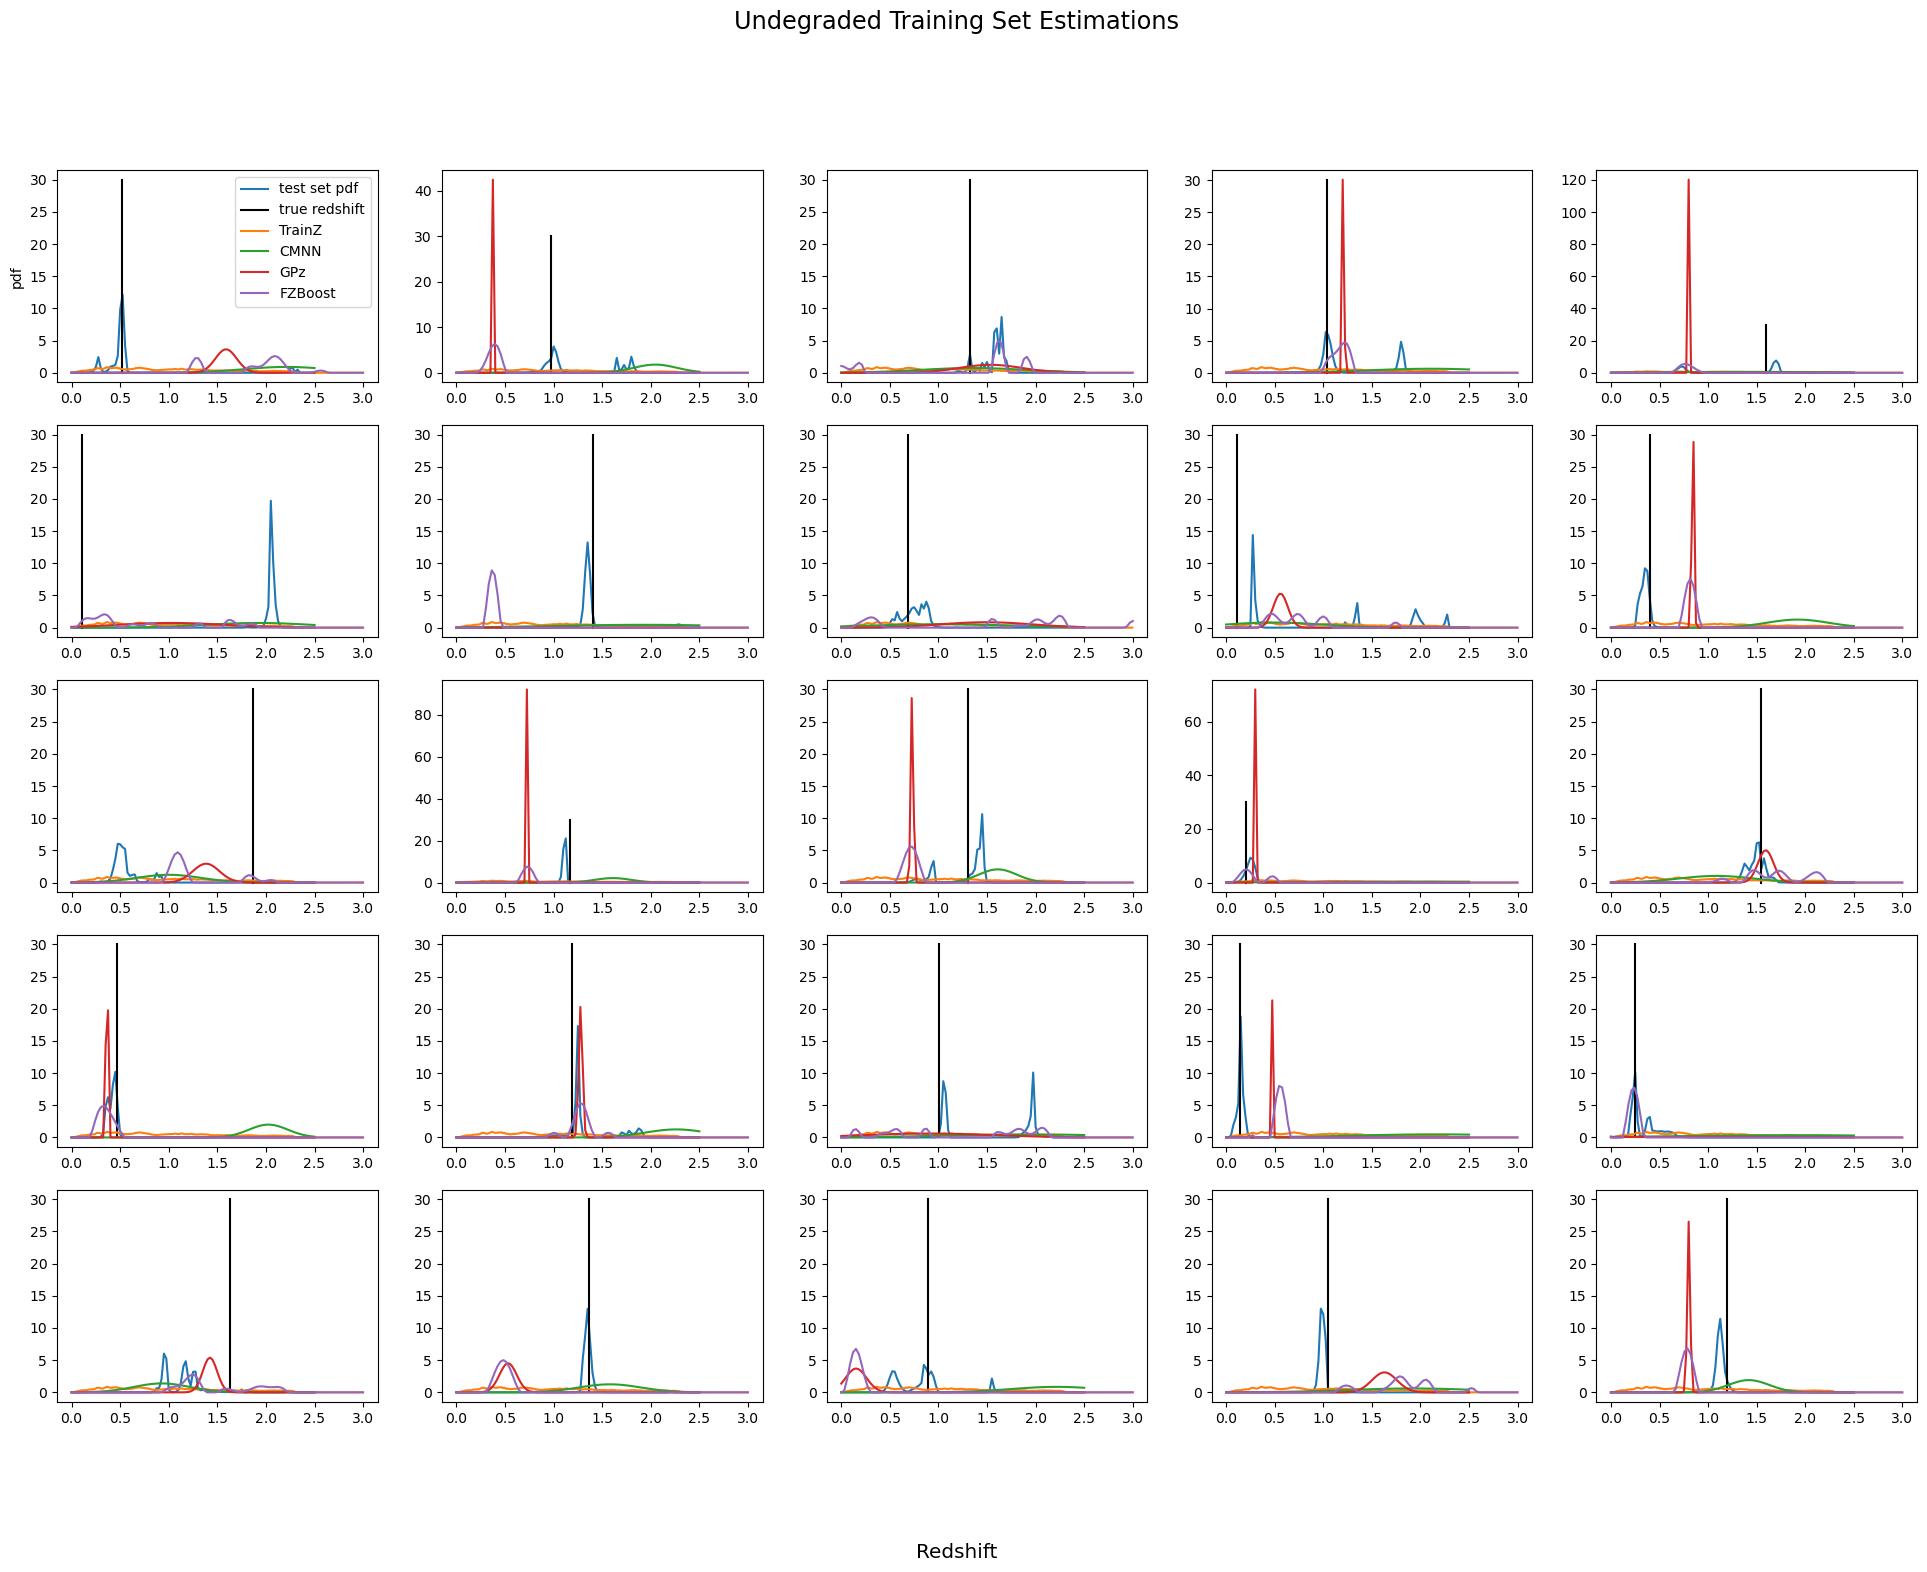

In [399]:
makePlots2('control', 'invz', 5, 24)

## TrainZ

In [ ]:
## HAS RUN ## 

In [221]:
eval_dir_TrainZ = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/evaluation"
os.chdir(eval_dir_TrainZ)

TrainZ_tables = []

for i in spec_ls:
    dir_0 = i
    parent_dir_0 = eval_dir_TrainZ
    path_0 = os.path.join(parent_dir_0, dir_0)
    os.makedirs(path_0, exist_ok=True)

    os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/evaluation/"+i)
    pdfs_file = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/"+i+"/output_estimate_TrainZ.hdf5"
    ensemble = DS.read_file(key='data', handle_class=QPHandle, path=pdfs_file)

    dtd_results = dtd_stage.evaluate(ztrue_data, ensemble)
    results_df = tables_io.convertObj(dtd_results['output'](), tables_io.types.PD_DATAFRAME)
    TrainZ_tables.append(results_df)

    

Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.
Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


In [222]:
TrainZ_tables[0]

ad       cvm  kld        ks  rmse
0     0.389364  0.178334  0.0  0.120250   0.0
1     0.932183  0.203126  0.0  0.087268   0.0
2     0.677505  0.060604  0.0  0.079381   0.0
3     1.602024  0.087020  0.0  0.074928   0.0
4     0.477130  0.067235  0.0  0.065750   0.0
...        ...       ...  ...       ...   ...
9995  0.445129  0.063797  0.0  0.050286   0.0
9996  0.810515  0.498953  0.0  0.067722   0.0
9997  0.604705  0.131648  0.0  0.085296   0.0
9998  0.396518  0.097760  0.0  0.088447   0.0
9999  0.254323  0.659835  0.0  0.085609   0.0

[10000 rows x 5 columns]

In [223]:
TrainZ_tables[1]

ad       cvm  kld        ks  rmse
0     0.418926  0.066995  0.0  0.070561   0.0
1     0.669440  0.204637  0.0  0.104783   0.0
2     1.881027  0.173847  0.0  0.074799   0.0
3     0.913044  0.235135  0.0  0.064772   0.0
4     1.786079  0.075433  0.0  0.093334   0.0
...        ...       ...  ...       ...   ...
9995  3.950431  0.519967  0.0  0.135884   0.0
9996  1.558579  0.605097  0.0  0.081063   0.0
9997  0.269934  0.201425  0.0  0.088540   0.0
9998  0.820737  0.044230  0.0  0.074534   0.0
9999  2.088125  0.062530  0.0  0.194288   0.0

[10000 rows x 5 columns]

In [224]:
TrainZ_tables[2]

ad       cvm  kld        ks  rmse
0     0.374357  0.044981  0.0  0.075853   0.0
1     0.750722  0.208919  0.0  0.059486   0.0
2     0.175635  0.065589  0.0  0.133641   0.0
3     1.355959  0.519935  0.0  0.088188   0.0
4     1.486950  0.113432  0.0  0.148412   0.0
...        ...       ...  ...       ...   ...
9995  0.574152  0.221712  0.0  0.071091   0.0
9996  2.895242  0.050656  0.0  0.082092   0.0
9997  0.324677  0.048524  0.0  0.047117   0.0
9998  0.343883  0.023984  0.0  0.059955   0.0
9999  1.456459  0.157035  0.0  0.045430   0.0

[10000 rows x 5 columns]

In [225]:
TrainZ_tables[3]

ad       cvm  kld        ks  rmse
0     0.823863  0.318362  0.0  0.058012   0.0
1     0.667247  0.235845  0.0  0.111908   0.0
2     0.550859  0.131257  0.0  0.120437   0.0
3     1.058232  0.741182  0.0  0.102793   0.0
4     0.869367  0.171809  0.0  0.078383   0.0
...        ...       ...  ...       ...   ...
9995  0.616175  0.036729  0.0  0.088817   0.0
9996  0.438710  0.112544  0.0  0.059280   0.0
9997  0.557526  0.226385  0.0  0.073627   0.0
9998  1.044429  0.217185  0.0  0.083505   0.0
9999  0.719833  0.100125  0.0  0.055043   0.0

[10000 rows x 5 columns]

In [226]:
TrainZ_tables[4]

ad       cvm  kld        ks  rmse
0     0.863061  0.098314  0.0  0.113293   0.0
1     1.390161  0.569320  0.0  0.040433   0.0
2     0.881542  0.026829  0.0  0.095789   0.0
3     0.883798  0.163191  0.0  0.101838   0.0
4     0.499646  0.123074  0.0  0.123248   0.0
...        ...       ...  ...       ...   ...
9995  0.281949  0.043394  0.0  0.088766   0.0
9996  0.523233  0.229932  0.0  0.117187   0.0
9997  0.198743  0.035608  0.0  0.093932   0.0
9998  0.970176  0.033129  0.0  0.108367   0.0
9999  1.126433  0.095033  0.0  0.066528   0.0

[10000 rows x 5 columns]

In [227]:
TrainZ_tables[5]

ad       cvm  kld        ks  rmse
0     1.191268  0.113856  0.0  0.066929   0.0
1     1.604475  0.300306  0.0  0.068427   0.0
2     0.932102  0.141696  0.0  0.070123   0.0
3     1.467716  0.047940  0.0  0.062785   0.0
4     1.022012  0.163430  0.0  0.067349   0.0
...        ...       ...  ...       ...   ...
9995  1.252201  0.191082  0.0  0.056451   0.0
9996  0.301789  0.132452  0.0  0.054778   0.0
9997  0.637475  0.257317  0.0  0.046947   0.0
9998  0.718124  0.067964  0.0  0.069126   0.0
9999  0.995947  0.363053  0.0  0.128974   0.0

[10000 rows x 5 columns]

In [253]:
eval_dir_invz_TrainZ = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/evaluation"
os.chdir(eval_dir_invz_TrainZ)

invz_TrainZ_tables = []

for i in pivot_ls:
    dir_0_invz = i
    parent_dir_0_invz = eval_dir_invz_TrainZ
    path_0_invz = os.path.join(parent_dir_0_invz, dir_0_invz)
    os.makedirs(path_0_invz, exist_ok=True)

    os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/evaluation/"+i)
    pdfs_file = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/"+i+"/output_estimate_TrainZ.hdf5"
    ensemble = DS.read_file(key='data', handle_class=QPHandle, path=pdfs_file)

    dtd_results = dtd_stage.evaluate(ztrue_data, ensemble)

    results_df = tables_io.convertObj(dtd_results['output'](), tables_io.types.PD_DATAFRAME)
    invz_TrainZ_tables.append(results_df)

Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.
Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


In [254]:
invz_TrainZ_tables[0]

ad       cvm  kld        ks  rmse
0     0.382521  0.128261  0.0  0.160175   0.0
1     2.316641  0.214098  0.0  0.073186   0.0
2     1.299711  0.058452  0.0  0.086328   0.0
3     0.832946  0.154123  0.0  0.082436   0.0
4     0.377649  0.101766  0.0  0.104771   0.0
...        ...       ...  ...       ...   ...
9995  0.214445  0.062282  0.0  0.104889   0.0
9996  0.670112  0.052819  0.0  0.063432   0.0
9997  0.296415  0.040716  0.0  0.091324   0.0
9998  1.238267  0.064449  0.0  0.057376   0.0
9999  1.819830  0.066935  0.0  0.117595   0.0

[10000 rows x 5 columns]

In [255]:
invz_TrainZ_tables[1]

ad       cvm  kld        ks  rmse
0     2.201274  0.221837  0.0  0.125280   0.0
1     0.909709  0.128738  0.0  0.073987   0.0
2     0.758617  0.066090  0.0  0.069515   0.0
3     3.534563  0.225238  0.0  0.092803   0.0
4     1.801086  0.122800  0.0  0.096459   0.0
...        ...       ...  ...       ...   ...
9995  0.386284  0.262994  0.0  0.140672   0.0
9996  0.948136  0.040453  0.0  0.098361   0.0
9997  0.870464  0.235016  0.0  0.095815   0.0
9998  0.492040  0.288895  0.0  0.060923   0.0
9999  0.419611  0.149247  0.0  0.093545   0.0

[10000 rows x 5 columns]

In [256]:
invz_TrainZ_tables[2]

ad       cvm  kld        ks  rmse
0     0.290503  0.096449  0.0  0.143201   0.0
1     0.852449  0.445382  0.0  0.145817   0.0
2     2.248847  0.122857  0.0  0.059945   0.0
3     0.928102  0.317729  0.0  0.066256   0.0
4     1.199594  0.147527  0.0  0.080054   0.0
...        ...       ...  ...       ...   ...
9995  1.968258  0.128252  0.0  0.125489   0.0
9996  0.953320  0.035929  0.0  0.055499   0.0
9997  1.021869  0.185611  0.0  0.113412   0.0
9998  3.193528  0.095722  0.0  0.073381   0.0
9999  0.440781  0.085445  0.0  0.098750   0.0

[10000 rows x 5 columns]

## CMNN

In [231]:
eval_dir_CMNN = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/evaluation"
os.chdir(eval_dir_CMNN)

CMNN_tables = []

for i in spec_ls:
    dir_1 = i
    parent_dir_1 = eval_dir_CMNN
    path_1 = os.path.join(parent_dir_1, dir_1)
    os.makedirs(path_1, exist_ok=True)

    os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/evaluation/"+i)
    pdfs_file = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/outputs/"+i+"/output_estimate_CMNN.hdf5"
    ensemble = DS.read_file(key='data', handle_class=QPHandle, path=pdfs_file)

    dtd_results = dtd_stage.evaluate(ztrue_data, ensemble)
    
    results_df = tables_io.convertObj(dtd_results['output'](), tables_io.types.PD_DATAFRAME)
    CMNN_tables.append(results_df)

Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.
Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


In [232]:
CMNN_tables[0]

ad       cvm  kld        ks  rmse
0     0.410820  0.279724  0.0  0.084470   0.0
1     2.652646  0.474221  0.0  0.116009   0.0
2     2.472170  0.072271  0.0  0.064088   0.0
3     1.832107  0.112705  0.0  0.070347   0.0
4     0.824113  0.057547  0.0  0.103807   0.0
...        ...       ...  ...       ...   ...
9995  2.044978  0.062595  0.0  0.078947   0.0
9996  1.294175  0.205142  0.0  0.074967   0.0
9997  0.410965  0.043289  0.0  0.063536   0.0
9998  1.621224  0.367009  0.0  0.067011   0.0
9999  0.517785  0.375252  0.0  0.066852   0.0

[10000 rows x 5 columns]

In [233]:
CMNN_tables[1]

ad       cvm  kld        ks  rmse
0     0.380851  0.042626  0.0  0.090592   0.0
1     0.312799  0.128179  0.0  0.108425   0.0
2     1.748670  0.325174  0.0  0.077368   0.0
3     0.373719  0.254728  0.0  0.125379   0.0
4     0.656660  0.044595  0.0  0.097847   0.0
...        ...       ...  ...       ...   ...
9995  0.746436  0.153999  0.0  0.070086   0.0
9996  1.511025  0.056398  0.0  0.090294   0.0
9997  0.567864  0.029973  0.0  0.056045   0.0
9998  7.693904  0.047805  0.0  0.113486   0.0
9999  0.303488  0.066676  0.0  0.061048   0.0

[10000 rows x 5 columns]

In [234]:
CMNN_tables[2]

ad       cvm  kld        ks  rmse
0     2.286358  0.268011  0.0  0.083651   0.0
1     0.533032  0.076493  0.0  0.057046   0.0
2     0.368316  0.138529  0.0  0.042172   0.0
3     0.436997  0.115809  0.0  0.080001   0.0
4     0.251201  0.066188  0.0  0.143755   0.0
...        ...       ...  ...       ...   ...
9995  0.969033  0.164627  0.0  0.135564   0.0
9996  0.632854  0.080774  0.0  0.112994   0.0
9997  0.591227  0.458044  0.0  0.070668   0.0
9998  0.879376  0.337928  0.0  0.116409   0.0
9999  0.290441  0.048619  0.0  0.070394   0.0

[10000 rows x 5 columns]

In [235]:
CMNN_tables[3]

ad       cvm  kld        ks  rmse
0     2.352619  0.086621  0.0  0.054437   0.0
1     0.856324  0.385403  0.0  0.068583   0.0
2     1.485446  0.404834  0.0  0.089429   0.0
3     1.460602  0.154020  0.0  0.060603   0.0
4     1.193631  0.110185  0.0  0.061256   0.0
...        ...       ...  ...       ...   ...
9995  0.688504  0.111867  0.0  0.101134   0.0
9996  0.640031  0.038684  0.0  0.086060   0.0
9997  0.920636  0.112512  0.0  0.138661   0.0
9998  1.293512  0.095213  0.0  0.115799   0.0
9999  0.783234  0.018072  0.0  0.107296   0.0

[10000 rows x 5 columns]

In [236]:
CMNN_tables[4]

ad       cvm  kld        ks  rmse
0     3.286627  0.210063  0.0  0.083098   0.0
1     0.815297  0.156991  0.0  0.109640   0.0
2     2.030631  0.036654  0.0  0.080275   0.0
3     0.370917  0.314434  0.0  0.043327   0.0
4     2.161965  0.097008  0.0  0.048202   0.0
...        ...       ...  ...       ...   ...
9995  2.554150  0.055871  0.0  0.099983   0.0
9996  0.336199  0.071398  0.0  0.091842   0.0
9997  0.811164  0.112401  0.0  0.106410   0.0
9998  1.635705  0.092402  0.0  0.108392   0.0
9999  0.357497  0.116332  0.0  0.076302   0.0

[10000 rows x 5 columns]

In [237]:
CMNN_tables[5]

ad       cvm  kld        ks  rmse
0     0.310641  0.092742  0.0  0.088239   0.0
1     1.117387  0.087622  0.0  0.054733   0.0
2     1.155903  0.227095  0.0  0.048469   0.0
3     1.350116  0.511459  0.0  0.084036   0.0
4     0.399969  0.044605  0.0  0.115897   0.0
...        ...       ...  ...       ...   ...
9995  1.572981  0.243675  0.0  0.104767   0.0
9996  0.638018  0.147323  0.0  0.086160   0.0
9997  0.441801  0.204176  0.0  0.079282   0.0
9998  0.517563  0.583520  0.0  0.070175   0.0
9999  0.670649  0.381560  0.0  0.088332   0.0

[10000 rows x 5 columns]

In [257]:
eval_dir_invz_CMNN = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/evaluation"
os.chdir(eval_dir_invz_CMNN)

invz_CMNN_tables = []

for i in pivot_ls:
    dir_1_invz = i
    parent_dir_1_invz = eval_dir_invz_CMNN
    path_1_invz = os.path.join(parent_dir_1_invz, dir_1_invz)
    os.makedirs(path_1_invz, exist_ok=True)

    os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/evaluation/"+i)
    pdfs_file = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/outputs/"+i+"/output_estimate_CMNN.hdf5"
    ensemble = DS.read_file(key='data', handle_class=QPHandle, path=pdfs_file)

    dtd_results = dtd_stage.evaluate(ztrue_data, ensemble)

    results_df = tables_io.convertObj(dtd_results['output'](), tables_io.types.PD_DATAFRAME)
    invz_CMNN_tables.append(results_df)

Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.
Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


In [258]:
invz_CMNN_tables[0]

ad       cvm  kld        ks  rmse
0     0.625153  0.220191  0.0  0.057312   0.0
1     0.594096  0.158466  0.0  0.072079   0.0
2     0.334596  0.284607  0.0  0.113104   0.0
3     1.232494  0.403787  0.0  0.138014   0.0
4     0.340125  0.108982  0.0  0.051915   0.0
...        ...       ...  ...       ...   ...
9995  0.606712  0.125658  0.0  0.042153   0.0
9996  2.286066  0.090403  0.0  0.049554   0.0
9997  1.150053  0.044793  0.0  0.059774   0.0
9998  0.284975  0.054773  0.0  0.083182   0.0
9999  1.169285  0.489165  0.0  0.065210   0.0

[10000 rows x 5 columns]

In [259]:
invz_CMNN_tables[1]

ad       cvm  kld        ks  rmse
0     0.838120  0.149575  0.0  0.083807   0.0
1     0.301819  0.029308  0.0  0.081139   0.0
2     0.195436  0.204901  0.0  0.106780   0.0
3     0.678930  0.297461  0.0  0.101383   0.0
4     2.470012  0.257834  0.0  0.125421   0.0
...        ...       ...  ...       ...   ...
9995  1.463134  0.067041  0.0  0.181762   0.0
9996  0.584480  0.381150  0.0  0.057081   0.0
9997  1.220105  0.053213  0.0  0.076086   0.0
9998  0.574142  0.122252  0.0  0.061395   0.0
9999  1.079817  0.034098  0.0  0.108659   0.0

[10000 rows x 5 columns]

In [260]:
invz_CMNN_tables[2]

ad       cvm  kld        ks  rmse
0     1.798837  0.058601  0.0  0.101223   0.0
1     0.240996  0.167466  0.0  0.041967   0.0
2     0.669957  0.225786  0.0  0.114002   0.0
3     0.669063  0.167522  0.0  0.162927   0.0
4     0.737519  0.065269  0.0  0.125568   0.0
...        ...       ...  ...       ...   ...
9995  0.424111  0.536024  0.0  0.065483   0.0
9996  0.649667  0.219963  0.0  0.069170   0.0
9997  0.225197  0.023713  0.0  0.082428   0.0
9998  0.612908  0.038051  0.0  0.104974   0.0
9999  0.723823  0.044102  0.0  0.115534   0.0

[10000 rows x 5 columns]

## GPz

In [241]:
eval_dir_GPz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/evaluation"
os.chdir(eval_dir_GPz)

GPz_tables = []

for i in spec_ls:
    dir_2 = i
    parent_dir_2 = eval_dir_GPz
    path_2 = os.path.join(parent_dir_2, dir_2)
    os.makedirs(path_2, exist_ok=True)

    os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/evaluation/"+i)
    pdfs_file = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/outputs/"+i+"/output_estimate_GPz.hdf5"
    ensemble = DS.read_file(key='data', handle_class=QPHandle, path=pdfs_file)

    dtd_results = dtd_stage.evaluate(ztrue_data, ensemble)

    results_df = tables_io.convertObj(dtd_results['output'](), tables_io.types.PD_DATAFRAME)
    GPz_tables.append(results_df)

Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.
Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


In [242]:
GPz_tables[0]

ad       cvm  kld        ks  rmse
0     1.092393  0.133886  0.0  0.082256   0.0
1     0.531593  0.419980  0.0  0.100859   0.0
2     0.504604  0.061590  0.0  0.092308   0.0
3     0.702599  0.205273  0.0  0.055719   0.0
4     0.498524  0.214971  0.0  0.121840   0.0
...        ...       ...  ...       ...   ...
9995  0.287426  0.028976  0.0  0.061957   0.0
9996  1.442213  0.531799  0.0  0.061690   0.0
9997  0.510158  0.160074  0.0  0.071900   0.0
9998  0.596043  0.124312  0.0  0.069203   0.0
9999  1.350333  0.562880  0.0  0.078590   0.0

[10000 rows x 5 columns]

In [243]:
GPz_tables[1]

ad       cvm  kld        ks  rmse
0     0.737581  0.201842  0.0  0.094187   0.0
1     0.918344  0.085822  0.0  0.077557   0.0
2     0.356333  0.298873  0.0  0.126694   0.0
3     3.799482  0.112874  0.0  0.066252   0.0
4     0.361366  0.162143  0.0  0.072830   0.0
...        ...       ...  ...       ...   ...
9995  0.316104  0.106295  0.0  0.069230   0.0
9996  0.424829  0.050129  0.0  0.083454   0.0
9997  0.677956  0.307321  0.0  0.071457   0.0
9998  1.398447  0.049388  0.0  0.086510   0.0
9999  1.901971  0.371649  0.0  0.050218   0.0

[10000 rows x 5 columns]

In [244]:
GPz_tables[2]

ad       cvm  kld        ks  rmse
0     1.798840  0.137682  0.0  0.101407   0.0
1     0.402668  0.046486  0.0  0.104289   0.0
2     1.680209  0.114570  0.0  0.098228   0.0
3     0.687606  0.235516  0.0  0.063000   0.0
4     0.899009  0.067740  0.0  0.061148   0.0
...        ...       ...  ...       ...   ...
9995  0.577211  0.067565  0.0  0.052911   0.0
9996  0.662704  0.106861  0.0  0.097498   0.0
9997  1.318181  0.191772  0.0  0.083982   0.0
9998  0.274796  0.175647  0.0  0.097437   0.0
9999  0.220541  0.172095  0.0  0.045332   0.0

[10000 rows x 5 columns]

In [245]:
GPz_tables[3]

ad       cvm  kld        ks  rmse
0     0.724468  0.188975  0.0  0.066369   0.0
1     1.822021  0.430262  0.0  0.052068   0.0
2     2.102034  0.180972  0.0  0.078128   0.0
3     0.476823  0.547378  0.0  0.050771   0.0
4     2.784199  0.143352  0.0  0.053418   0.0
...        ...       ...  ...       ...   ...
9995  0.826239  0.083928  0.0  0.066886   0.0
9996  0.887171  0.073186  0.0  0.118101   0.0
9997  0.421630  0.202989  0.0  0.094080   0.0
9998  0.990653  0.108783  0.0  0.083591   0.0
9999  0.977479  0.165649  0.0  0.082987   0.0

[10000 rows x 5 columns]

In [246]:
GPz_tables[4]

ad       cvm  kld        ks  rmse
0     1.541832  0.263644  0.0  0.114411   0.0
1     3.288749  0.056944  0.0  0.079769   0.0
2     0.389228  0.109762  0.0  0.102251   0.0
3     0.514325  0.183906  0.0  0.082003   0.0
4     1.935763  0.041889  0.0  0.096054   0.0
...        ...       ...  ...       ...   ...
9995  0.599885  0.433599  0.0  0.051686   0.0
9996  3.017874  0.222378  0.0  0.101200   0.0
9997  1.462436  0.143520  0.0  0.063359   0.0
9998  1.027354  0.260890  0.0  0.061548   0.0
9999  1.677214  0.105828  0.0  0.119651   0.0

[10000 rows x 5 columns]

In [247]:
GPz_tables[5]

ad       cvm  kld        ks  rmse
0     0.440076  0.289839  0.0  0.069281   0.0
1     1.304589  0.165170  0.0  0.045564   0.0
2     0.496161  0.175482  0.0  0.057095   0.0
3     0.776246  0.179732  0.0  0.105656   0.0
4     0.919482  0.046650  0.0  0.072080   0.0
...        ...       ...  ...       ...   ...
9995  0.138723  0.486465  0.0  0.135049   0.0
9996  2.225911  0.177170  0.0  0.118958   0.0
9997  1.767146  0.046389  0.0  0.116960   0.0
9998  1.015662  0.089572  0.0  0.081597   0.0
9999  0.800062  0.294012  0.0  0.089793   0.0

[10000 rows x 5 columns]

In [261]:
eval_dir_invz_GPz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_GPz/evaluation"
os.chdir(eval_dir_invz_GPz)

invz_GPz_tables = []

for i in pivot_ls:
    dir_2_invz = i
    parent_dir_2_invz = eval_dir_invz_GPz
    path_2_invz = os.path.join(parent_dir_2_invz, dir_2_invz)
    os.makedirs(path_2_invz, exist_ok=True)

    os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_GPz/evaluation/"+i)
    pdfs_file = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_GPz/outputs/"+i+"/output_estimate_GPz.hdf5"
    ensemble = DS.read_file(key='data', handle_class=QPHandle, path=pdfs_file)

    dtd_results = dtd_stage.evaluate(ztrue_data, ensemble)

    results_df = tables_io.convertObj(dtd_results['output'](), tables_io.types.PD_DATAFRAME)
    invz_GPz_tables.append(results_df)

Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.
Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


In [262]:
invz_GPz_tables[0]

ad       cvm  kld        ks  rmse
0     0.802294  0.174301  0.0  0.097812   0.0
1     1.796211  0.358986  0.0  0.060947   0.0
2     1.159403  0.114220  0.0  0.094604   0.0
3     0.593699  0.201971  0.0  0.062005   0.0
4     0.492388  0.261186  0.0  0.132390   0.0
...        ...       ...  ...       ...   ...
9995  1.102118  0.071103  0.0  0.055218   0.0
9996  0.353418  0.171002  0.0  0.119518   0.0
9997  0.199809  0.259535  0.0  0.086246   0.0
9998  0.790238  0.066313  0.0  0.115197   0.0
9999  0.537255  0.127407  0.0  0.065246   0.0

[10000 rows x 5 columns]

In [263]:
invz_GPz_tables[1]

ad       cvm  kld        ks  rmse
0     1.727789  0.101529  0.0  0.060214   0.0
1     0.370513  0.131164  0.0  0.091245   0.0
2     0.444396  0.369084  0.0  0.088958   0.0
3     0.483006  0.096316  0.0  0.074964   0.0
4     0.545912  0.093550  0.0  0.088154   0.0
...        ...       ...  ...       ...   ...
9995  1.027214  0.148975  0.0  0.069084   0.0
9996  1.027629  0.091242  0.0  0.133001   0.0
9997  0.331374  0.248995  0.0  0.112080   0.0
9998  0.561680  0.104445  0.0  0.074274   0.0
9999  0.854097  0.136088  0.0  0.077020   0.0

[10000 rows x 5 columns]

In [264]:
invz_GPz_tables[2]

ad       cvm  kld        ks  rmse
0     0.450352  0.030775  0.0  0.122913   0.0
1     1.112113  0.055334  0.0  0.071529   0.0
2     1.279203  0.074063  0.0  0.082794   0.0
3     0.300701  0.095965  0.0  0.067186   0.0
4     0.453244  0.122123  0.0  0.076728   0.0
...        ...       ...  ...       ...   ...
9995  1.522795  0.048755  0.0  0.080861   0.0
9996  0.749666  0.366779  0.0  0.058414   0.0
9997  0.841473  0.313035  0.0  0.098581   0.0
9998  0.223461  0.034140  0.0  0.042562   0.0
9999  1.880645  0.127645  0.0  0.054973   0.0

[10000 rows x 5 columns]

## PZFlow

In [251]:
eval_dir_PZFlow = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/evaluation"
os.chdir(eval_dir_PZFlow)

PZFlow_tables = []

for i in spec_ls:
    dir_3 = i
    parent_dir_3 = eval_dir_PZFlow
    path_3 = os.path.join(parent_dir_3, dir_3)
    os.makedirs(path_3, exist_ok=True)

    os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/evaluation/"+i)
    pdfs_file = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/outputs/"+i+"/output_estimate_PZFlow.hdf5"
    ensemble = DS.read_file(key='data', handle_class=QPHandle, path=pdfs_file)

    dtd_results = dtd_stage.evaluate(ztrue_data, ensemble)

    results_df = tables_io.convertObj(dtd_results['output'](), tables_io.types.PD_DATAFRAME)
    PZFlow_tables.append(results_df)

Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


KeyboardInterrupt: 

In [ ]:
PZFlow_tables[0]

ad  cvm  kld  ks  rmse
0    NaN  NaN  NaN NaN   NaN
1    NaN  NaN  NaN NaN   NaN
2    NaN  NaN  NaN NaN   NaN
3    NaN  NaN  NaN NaN   NaN
4    NaN  NaN  NaN NaN   NaN
...   ..  ...  ...  ..   ...
9995 NaN  NaN  NaN NaN   NaN
9996 NaN  NaN  NaN NaN   NaN
9997 NaN  NaN  NaN NaN   NaN
9998 NaN  NaN  NaN NaN   NaN
9999 NaN  NaN  NaN NaN   NaN

[10000 rows x 5 columns]

In [ ]:
PZFlow_tables[1]

ad  cvm  kld  ks  rmse
0    NaN  NaN  NaN NaN   NaN
1    NaN  NaN  NaN NaN   NaN
2    NaN  NaN  NaN NaN   NaN
3    NaN  NaN  NaN NaN   NaN
4    NaN  NaN  NaN NaN   NaN
...   ..  ...  ...  ..   ...
9995 NaN  NaN  NaN NaN   NaN
9996 NaN  NaN  NaN NaN   NaN
9997 NaN  NaN  NaN NaN   NaN
9998 NaN  NaN  NaN NaN   NaN
9999 NaN  NaN  NaN NaN   NaN

[10000 rows x 5 columns]

In [ ]:
PZFlow_tables[2]

ad  cvm  kld  ks  rmse
0    NaN  NaN  NaN NaN   NaN
1    NaN  NaN  NaN NaN   NaN
2    NaN  NaN  NaN NaN   NaN
3    NaN  NaN  NaN NaN   NaN
4    NaN  NaN  NaN NaN   NaN
...   ..  ...  ...  ..   ...
9995 NaN  NaN  NaN NaN   NaN
9996 NaN  NaN  NaN NaN   NaN
9997 NaN  NaN  NaN NaN   NaN
9998 NaN  NaN  NaN NaN   NaN
9999 NaN  NaN  NaN NaN   NaN

[10000 rows x 5 columns]

In [ ]:
PZFlow_tables[3]

ad  cvm  kld  ks  rmse
0    NaN  NaN  NaN NaN   NaN
1    NaN  NaN  NaN NaN   NaN
2    NaN  NaN  NaN NaN   NaN
3    NaN  NaN  NaN NaN   NaN
4    NaN  NaN  NaN NaN   NaN
...   ..  ...  ...  ..   ...
9995 NaN  NaN  NaN NaN   NaN
9996 NaN  NaN  NaN NaN   NaN
9997 NaN  NaN  NaN NaN   NaN
9998 NaN  NaN  NaN NaN   NaN
9999 NaN  NaN  NaN NaN   NaN

[10000 rows x 5 columns]

In [ ]:
PZFlow_tables[4]

ad  cvm  kld  ks  rmse
0    NaN  NaN  NaN NaN   NaN
1    NaN  NaN  NaN NaN   NaN
2    NaN  NaN  NaN NaN   NaN
3    NaN  NaN  NaN NaN   NaN
4    NaN  NaN  NaN NaN   NaN
...   ..  ...  ...  ..   ...
9995 NaN  NaN  NaN NaN   NaN
9996 NaN  NaN  NaN NaN   NaN
9997 NaN  NaN  NaN NaN   NaN
9998 NaN  NaN  NaN NaN   NaN
9999 NaN  NaN  NaN NaN   NaN

[10000 rows x 5 columns]

In [ ]:
PZFlow_tables[5]

ad  cvm  kld  ks  rmse
0    NaN  NaN  NaN NaN   NaN
1    NaN  NaN  NaN NaN   NaN
2    NaN  NaN  NaN NaN   NaN
3    NaN  NaN  NaN NaN   NaN
4    NaN  NaN  NaN NaN   NaN
...   ..  ...  ...  ..   ...
9995 NaN  NaN  NaN NaN   NaN
9996 NaN  NaN  NaN NaN   NaN
9997 NaN  NaN  NaN NaN   NaN
9998 NaN  NaN  NaN NaN   NaN
9999 NaN  NaN  NaN NaN   NaN

[10000 rows x 5 columns]

In [ ]:
eval_dir_invz_PZFlow = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/evaluation"
os.chdir(eval_dir_invz_PZFlow)

invz_PZFlow_tables = []

for i in pivot_ls:
    dir_3_invz = i
    parent_dir_3_invz = eval_dir_invz_PZFlow
    path_3_invz = os.path.join(parent_dir_3_invz, dir_3_invz)
    os.makedirs(path_3_invz, exist_ok=True)

    os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/evaluation/"+i)
    pdfs_file = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs/"+i+"/output_estimate_PZFlow.hdf5"
    ensemble = DS.read_file(key='data', handle_class=QPHandle, path=pdfs_file)

    dtd_results = dtd_stage.evaluate(ztrue_data, ensemble)
    results_df = tables_io.convertObj(dtd_results['output'](), tables_io.types.PD_DATAFRAME)
    invz_PZFlow_tables.append(results_df)

Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.
Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Processing 0 running evaluator on chunk 0 - 10000.
Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


In [ ]:
invz_PZFlow_tables[0]

ad  cvm  kld  ks  rmse
0    NaN  NaN  NaN NaN   NaN
1    NaN  NaN  NaN NaN   NaN
2    NaN  NaN  NaN NaN   NaN
3    NaN  NaN  NaN NaN   NaN
4    NaN  NaN  NaN NaN   NaN
...   ..  ...  ...  ..   ...
9995 NaN  NaN  NaN NaN   NaN
9996 NaN  NaN  NaN NaN   NaN
9997 NaN  NaN  NaN NaN   NaN
9998 NaN  NaN  NaN NaN   NaN
9999 NaN  NaN  NaN NaN   NaN

[10000 rows x 5 columns]

In [ ]:
invz_PZFlow_tables[1]

ad  cvm  kld  ks  rmse
0    NaN  NaN  NaN NaN   NaN
1    NaN  NaN  NaN NaN   NaN
2    NaN  NaN  NaN NaN   NaN
3    NaN  NaN  NaN NaN   NaN
4    NaN  NaN  NaN NaN   NaN
...   ..  ...  ...  ..   ...
9995 NaN  NaN  NaN NaN   NaN
9996 NaN  NaN  NaN NaN   NaN
9997 NaN  NaN  NaN NaN   NaN
9998 NaN  NaN  NaN NaN   NaN
9999 NaN  NaN  NaN NaN   NaN

[10000 rows x 5 columns]

## FZBoost

In [265]:
eval_dir_FZBoost = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/evaluation"
os.chdir(eval_dir_FZBoost)

FZBoost_tables = []

for i in spec_ls:
    dir_4 = i
    parent_dir_4 = eval_dir_FZBoost
    path_4 = os.path.join(parent_dir_4, dir_4)
    os.makedirs(path_4, exist_ok=True)

    os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/evaluation/"+i)
    pdfs_file = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs/"+i+"/output_estimate_FZBoost.hdf5"
    ensemble = DS.read_file(key='data', handle_class=QPHandle, path=pdfs_file)

    dtd_results = dtd_stage.evaluate(ztrue_data, ensemble)
    results_df = tables_io.convertObj(dtd_results['output'](), tables_io.types.PD_DATAFRAME)
    FZBoost_tables.append(results_df)

Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.
Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


In [266]:
FZBoost_tables[0]

ad       cvm  kld        ks  rmse
0     1.086386  0.157334  0.0  0.108329   0.0
1     1.530715  0.130113  0.0  0.067651   0.0
2     0.559210  0.787291  0.0  0.122030   0.0
3     1.407728  0.064737  0.0  0.078263   0.0
4     0.702067  0.206726  0.0  0.091615   0.0
...        ...       ...  ...       ...   ...
9995  1.198607  0.079894  0.0  0.072718   0.0
9996  0.853192  0.263624  0.0  0.086216   0.0
9997  1.546463  0.088326  0.0  0.081728   0.0
9998  0.972698  0.162365  0.0  0.091894   0.0
9999  0.257080  0.207561  0.0  0.070590   0.0

[10000 rows x 5 columns]

In [267]:
FZBoost_tables[1]

ad       cvm  kld        ks  rmse
0     2.220234  0.290998  0.0  0.063281   0.0
1     0.693858  0.168183  0.0  0.117670   0.0
2     1.485746  0.036468  0.0  0.097107   0.0
3     1.841788  0.261240  0.0  0.160593   0.0
4     0.442838  0.091739  0.0  0.066271   0.0
...        ...       ...  ...       ...   ...
9995  1.930693  0.743125  0.0  0.104913   0.0
9996  0.855843  0.044414  0.0  0.062504   0.0
9997  1.947977  0.144569  0.0  0.109489   0.0
9998  0.504371  0.708714  0.0  0.071756   0.0
9999  1.077046  0.290426  0.0  0.125903   0.0

[10000 rows x 5 columns]

In [268]:
FZBoost_tables[2]

ad       cvm  kld        ks  rmse
0     1.048530  0.144977  0.0  0.048561   0.0
1     0.415964  0.058264  0.0  0.064024   0.0
2     1.620770  0.079259  0.0  0.057150   0.0
3     0.494673  0.040098  0.0  0.074085   0.0
4     2.257401  0.276455  0.0  0.103816   0.0
...        ...       ...  ...       ...   ...
9995  0.685677  0.083348  0.0  0.090352   0.0
9996  0.933056  0.210087  0.0  0.064751   0.0
9997  0.643202  0.139496  0.0  0.092581   0.0
9998  0.807372  0.161818  0.0  0.097336   0.0
9999  1.280601  0.047706  0.0  0.092662   0.0

[10000 rows x 5 columns]

In [269]:
FZBoost_tables[3]

ad       cvm  kld        ks  rmse
0     1.185210  0.076914  0.0  0.076242   0.0
1     0.343352  0.119168  0.0  0.056973   0.0
2     2.800527  0.067350  0.0  0.069732   0.0
3     0.905499  0.151216  0.0  0.127795   0.0
4     0.363984  0.035173  0.0  0.041782   0.0
...        ...       ...  ...       ...   ...
9995  0.686591  0.534578  0.0  0.099679   0.0
9996  1.283474  0.187642  0.0  0.094125   0.0
9997  0.948973  0.177974  0.0  0.045921   0.0
9998  0.612079  0.227688  0.0  0.107910   0.0
9999  0.596806  0.126315  0.0  0.145402   0.0

[10000 rows x 5 columns]

In [270]:
FZBoost_tables[4]

ad       cvm  kld        ks  rmse
0     0.511428  0.175051  0.0  0.055716   0.0
1     2.245870  0.129151  0.0  0.045151   0.0
2     0.394757  0.040016  0.0  0.072645   0.0
3     0.807442  0.059118  0.0  0.116296   0.0
4     0.257227  0.454023  0.0  0.058702   0.0
...        ...       ...  ...       ...   ...
9995  1.303053  0.190343  0.0  0.103015   0.0
9996  0.581930  0.051596  0.0  0.078014   0.0
9997  0.331981  0.109872  0.0  0.046890   0.0
9998  0.241165  0.034741  0.0  0.065213   0.0
9999  0.815227  0.079508  0.0  0.152298   0.0

[10000 rows x 5 columns]

In [271]:
FZBoost_tables[5]

ad       cvm  kld        ks  rmse
0     0.704684  0.034909  0.0  0.064177   0.0
1     0.799824  0.612533  0.0  0.105054   0.0
2     0.879090  0.216746  0.0  0.066600   0.0
3     0.446356  0.264961  0.0  0.129555   0.0
4     2.357601  0.068713  0.0  0.106774   0.0
...        ...       ...  ...       ...   ...
9995  0.837118  0.058646  0.0  0.056244   0.0
9996  0.668946  0.142975  0.0  0.115757   0.0
9997  0.285962  0.166836  0.0  0.073136   0.0
9998  0.829601  0.260378  0.0  0.115609   0.0
9999  0.864042  0.390575  0.0  0.065811   0.0

[10000 rows x 5 columns]

In [272]:

eval_dir_invz_FZBoost = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost/evaluation"
os.chdir(eval_dir_invz_FZBoost)

invz_FZBoost_tables = []

for i in pivot_ls:
    dir_4_invz = i
    parent_dir_4_invz = eval_dir_invz_FZBoost
    path_4_invz = os.path.join(parent_dir_4_invz, dir_4_invz)
    os.makedirs(path_4_invz, exist_ok=True)

    os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost/evaluation/"+i)
    pdfs_file = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost/outputs/"+i+"/output_estimate_FZBoost.hdf5"
    ensemble = DS.read_file(key='data', handle_class=QPHandle, path=pdfs_file)

    dtd_results = dtd_stage.evaluate(ztrue_data, ensemble)
    results_df = tables_io.convertObj(dtd_results['output'](), tables_io.types.PD_DATAFRAME)
    invz_FZBoost_tables.append(results_df)

Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.
Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist
Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


In [273]:
invz_FZBoost_tables[0]

ad       cvm  kld        ks  rmse
0     0.236801  0.522260  0.0  0.131850   0.0
1     0.396607  0.123347  0.0  0.099795   0.0
2     0.622110  0.108159  0.0  0.075606   0.0
3     0.572244  0.130850  0.0  0.087858   0.0
4     1.784939  0.073311  0.0  0.056125   0.0
...        ...       ...  ...       ...   ...
9995  0.768490  0.036442  0.0  0.070254   0.0
9996  0.464172  0.157358  0.0  0.114545   0.0
9997  0.291275  0.033147  0.0  0.099843   0.0
9998  0.400450  0.611994  0.0  0.109506   0.0
9999  1.959056  0.412424  0.0  0.091996   0.0

[10000 rows x 5 columns]

In [274]:
invz_FZBoost_tables[1]

ad       cvm  kld        ks  rmse
0     0.454495  0.124971  0.0  0.093429   0.0
1     1.848237  0.058466  0.0  0.093839   0.0
2     0.536724  0.395406  0.0  0.061156   0.0
3     0.657812  0.054423  0.0  0.075827   0.0
4     2.596356  0.050417  0.0  0.103358   0.0
...        ...       ...  ...       ...   ...
9995  0.503714  0.052045  0.0  0.081197   0.0
9996  2.822671  0.120069  0.0  0.112789   0.0
9997  0.345838  0.095185  0.0  0.089762   0.0
9998  2.092330  0.106360  0.0  0.051562   0.0
9999  0.368354  0.054583  0.0  0.080875   0.0

[10000 rows x 5 columns]

In [275]:
invz_FZBoost_tables[2]

ad       cvm  kld        ks  rmse
0     1.113505  0.166130  0.0  0.084855   0.0
1     0.852148  0.109232  0.0  0.056072   0.0
2     0.334736  0.705349  0.0  0.102641   0.0
3     1.358872  0.027850  0.0  0.055796   0.0
4     0.572717  0.215583  0.0  0.108835   0.0
...        ...       ...  ...       ...   ...
9995  0.302817  0.073099  0.0  0.085084   0.0
9996  1.309196  0.197783  0.0  0.096275   0.0
9997  0.423334  0.211520  0.0  0.123880   0.0
9998  0.704000  0.133360  0.0  0.114486   0.0
9999  2.011702  0.146678  0.0  0.065170   0.0

[10000 rows x 5 columns]

# Plots

In [360]:
table_dict = {"TrainZ": [TrainZ_tables, invz_TrainZ_tables], 
              "CMNN": [CMNN_tables, invz_CMNN_tables], 
              "GPz": [GPz_tables, invz_GPz_tables],
              #"PZFlow": [PZFlow_tables, invz_PZFlow_tables], 
              "FZBoost": [FZBoost_tables, invz_FZBoost_tables]
              }

table_dict['TrainZ'][0][3]

ad       cvm  kld        ks  rmse
0     0.823863  0.318362  0.0  0.058012   0.0
1     0.667247  0.235845  0.0  0.111908   0.0
2     0.550859  0.131257  0.0  0.120437   0.0
3     1.058232  0.741182  0.0  0.102793   0.0
4     0.869367  0.171809  0.0  0.078383   0.0
...        ...       ...  ...       ...   ...
9995  0.616175  0.036729  0.0  0.088817   0.0
9996  0.438710  0.112544  0.0  0.059280   0.0
9997  0.557526  0.226385  0.0  0.073627   0.0
9998  1.044429  0.217185  0.0  0.083505   0.0
9999  0.719833  0.100125  0.0  0.055043   0.0

[10000 rows x 5 columns]

In [374]:
stat_ls = ['ad', 'cvm', 'ks']
est_ls = ['TrainZ', 'CMNN', 'GPz', 'FZBoost']
pivot_ls = ['1.0', '1.4', 'control']

def makeHists(type, est_ls, stat_ls, size):

    if type == 'invz':
        dict_ind = 1
        rows = 3
        name_ls = pivot_ls

    if type =='spec':
        dict_ind = 0
        rows = 6
        name_ls = spec_ls
    
    cols = len(stat_ls)
    print(cols)
    
    fig, axes = plt.subplots(nrows = rows, ncols = len(stat_ls), figsize = (size, size)) 

    ct = 0
    for i in range(0, rows):
        for j in range(0, cols):
            if stat_ls[j]=='ad':
                val = 0
                for est in est_ls:
                    axes[i][j].hist(table_dict[est][dict_ind][i][stat_ls[j]], bins = np.linspace(0, 2, 100), alpha=0.25, label= est_ls[val])
                    val += 1
            if stat_ls[j]=='cvm':
                val = 0
                for est in est_ls:
                    axes[i][j].hist(table_dict[est][dict_ind][i][stat_ls[j]], bins = np.linspace(0, 1.0, 100), alpha=0.25, label= est_ls[val])
                    val += 1
            if stat_ls[j]=='ks':
                val = 0
                for est in est_ls: 
                    axes[i][j].hist(table_dict[est][dict_ind][i][stat_ls[j]], bins = np.linspace(0, .25, 100), alpha=0.25, label= est_ls[val])
            axes[i][j].set_title(name_ls[i]+' '+stat_ls[j])
            axes[0][0].legend()

            ct += 1
            
    fig.supxlabel("Statistic Value")
    fig.supylabel("Bin Count")

    # fig.suptitle(est+" Estmiates for Spectrascopic Sky Surveys", size = 'xx-large')
    # fig.supxlabel("Redshift", size = 'x-large')
    # #fig.supylabel("pdf", size = 'x-large')
    # axes[0][0].set_ylabel("pdf")

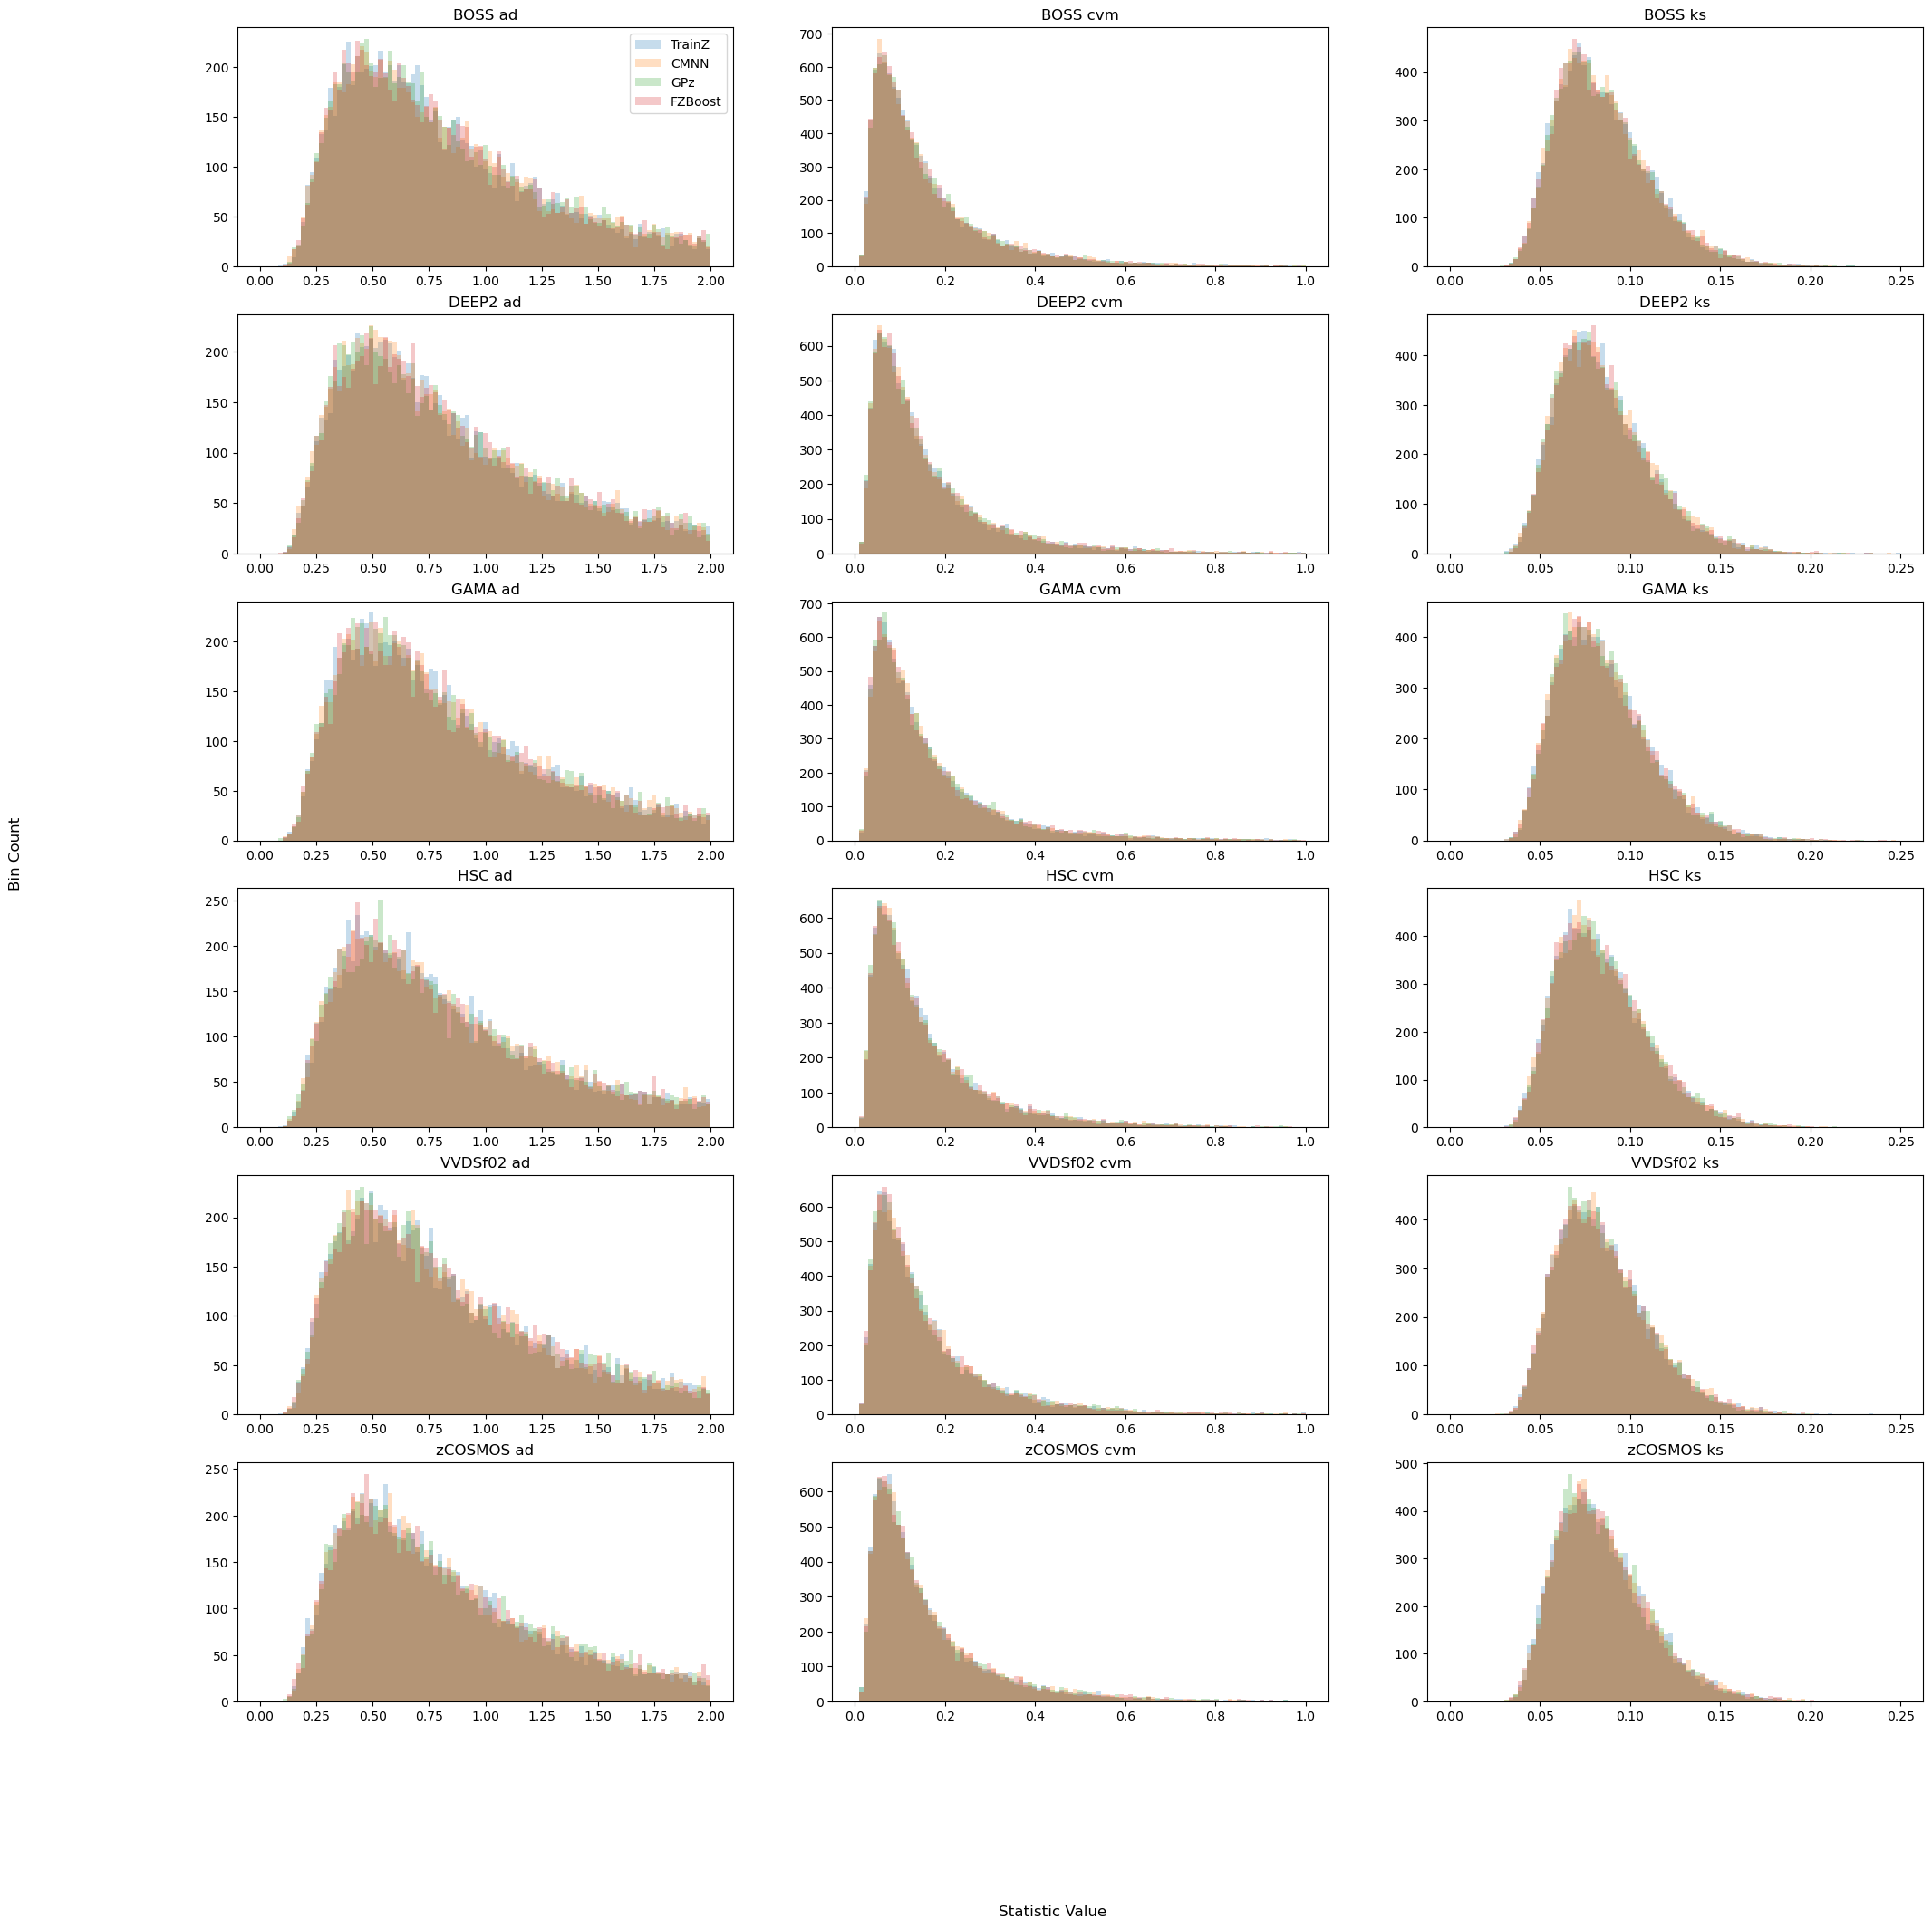

In [364]:
makeHists('spec',est_ls, stat_ls, 24)

3


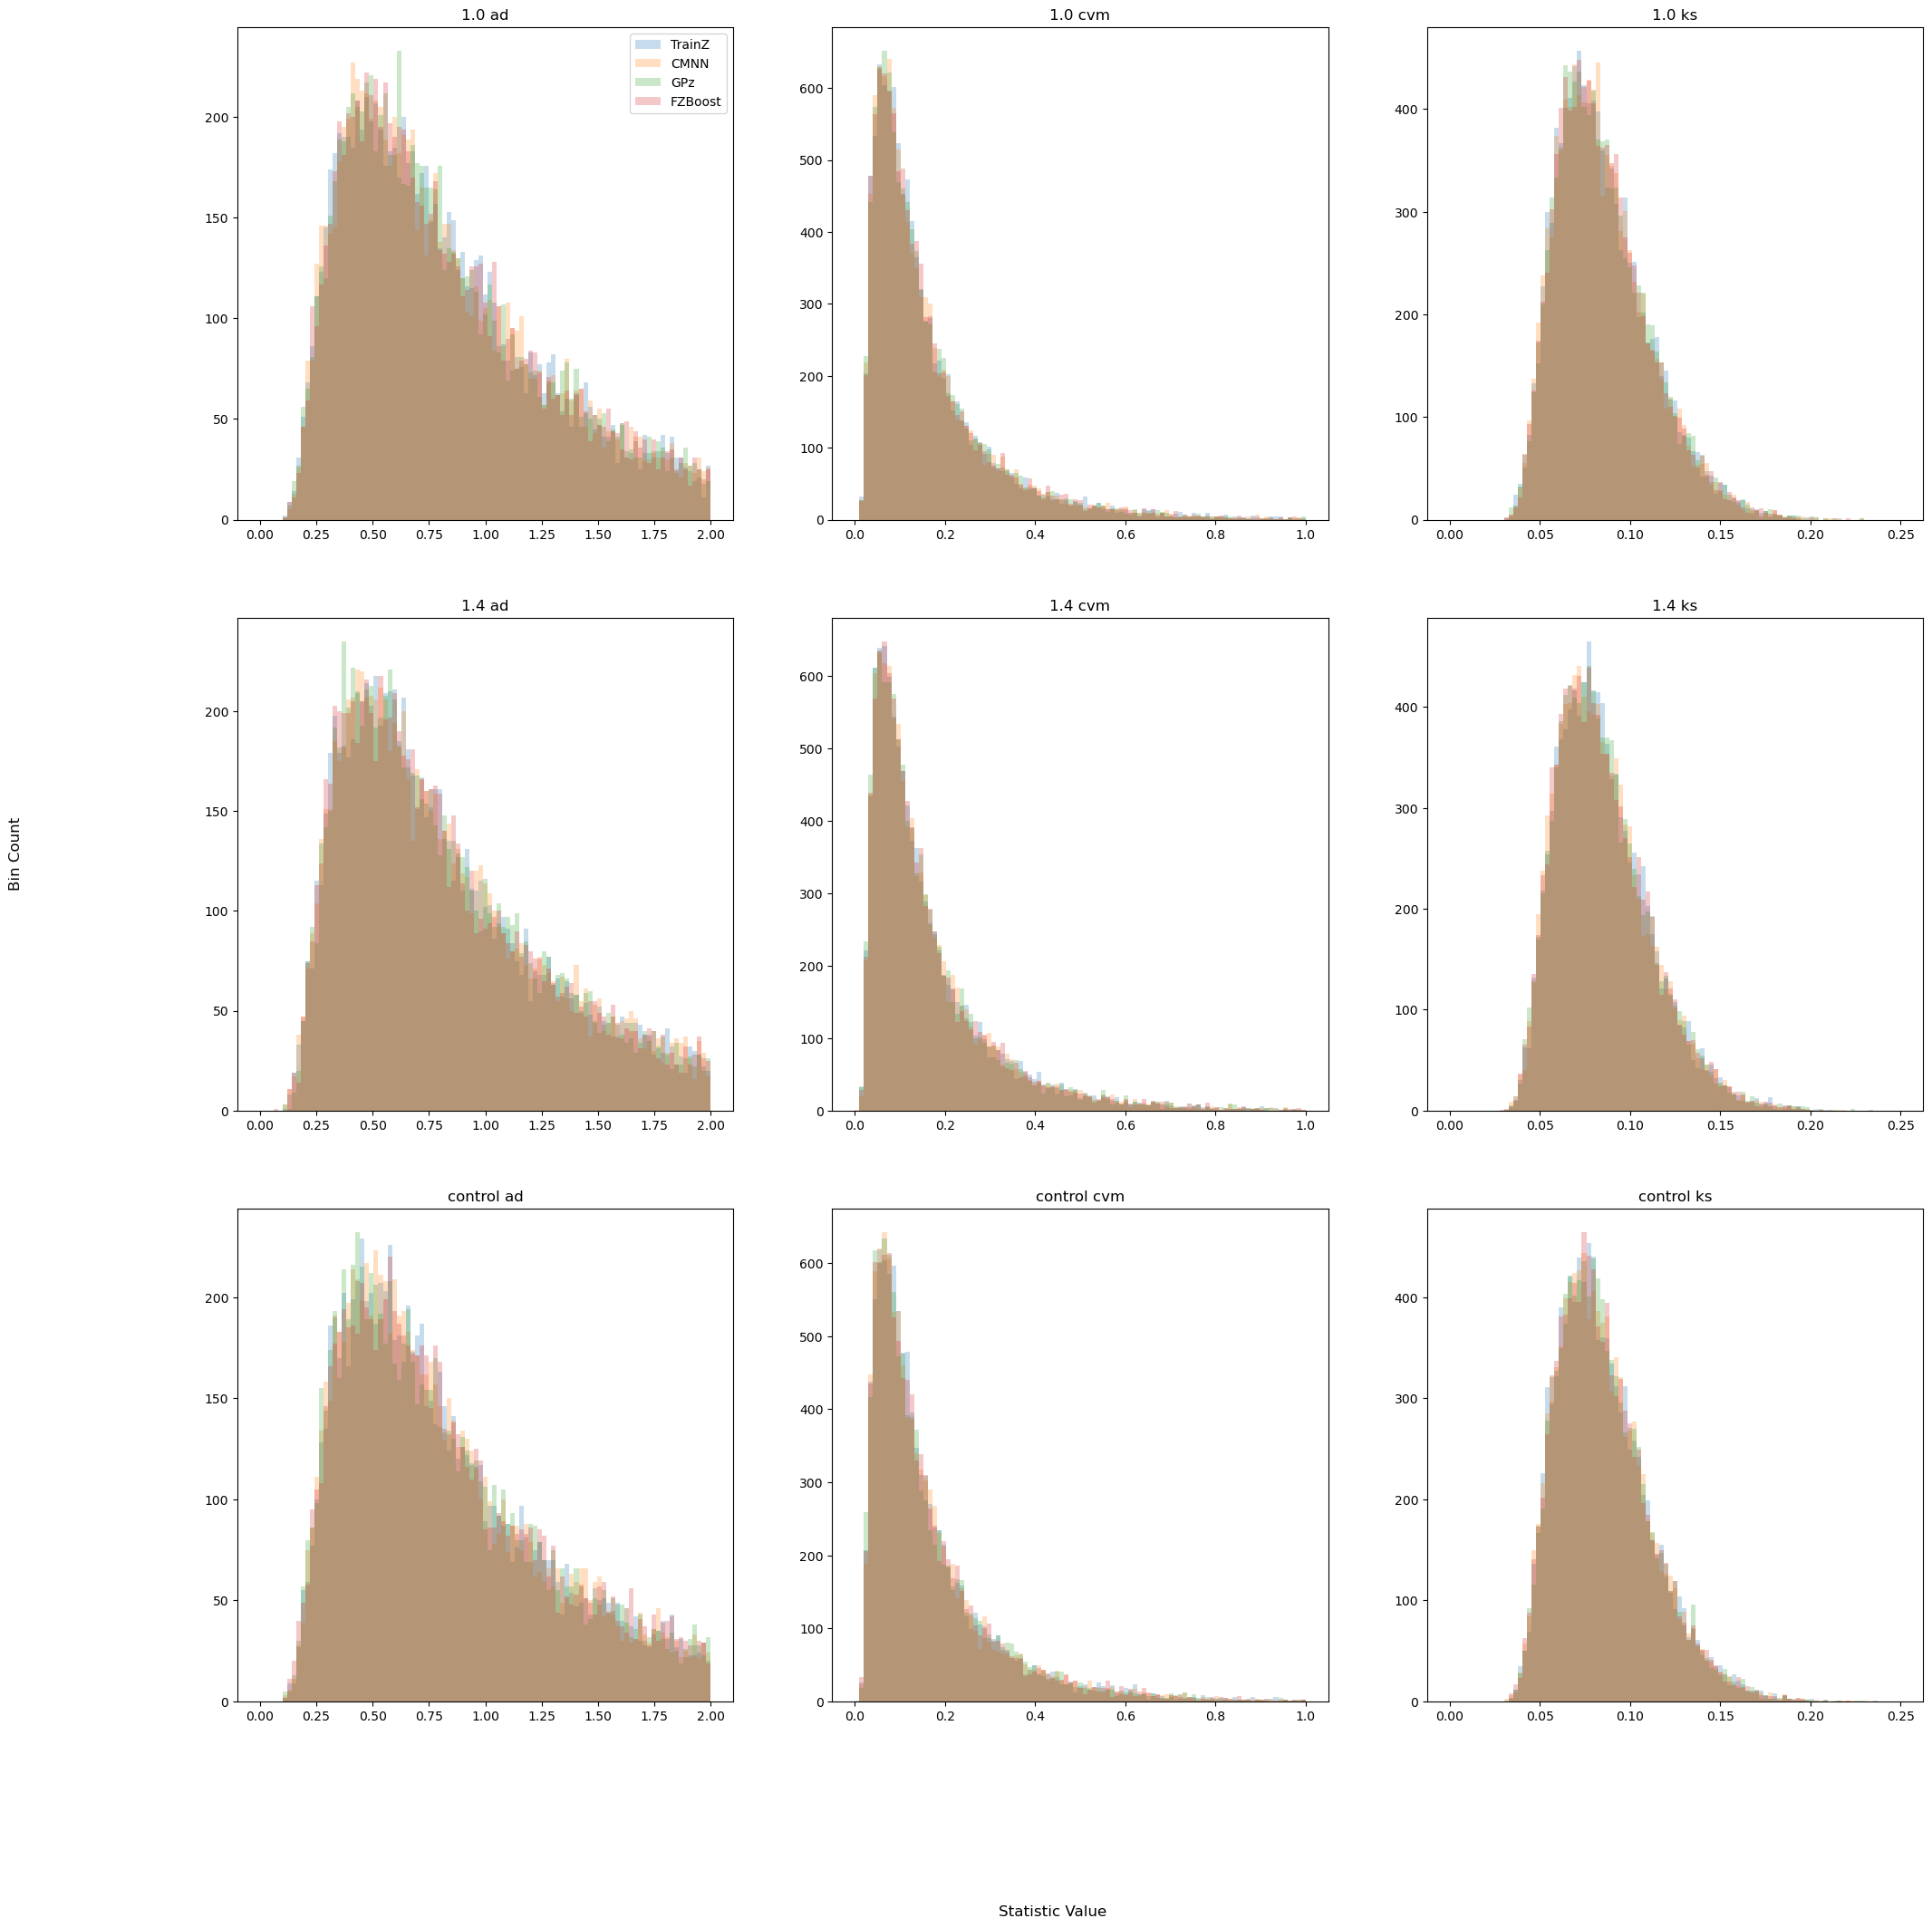

In [375]:
makeHists('invz',est_ls, stat_ls, 24)

# Point-to-dist

In [ ]:
stage_dict = dict(
    metrics=['cdeloss', 'pit', 'brier'],
    _random_state=None,
    metric_config={
        'brier': {'limits':(0,3.1)},
        'pit':{'tdigest_compression': 1000},
    }
)
dtp_stage = DistToPointEvaluator.make_stage(name='dist_to_point', **stage_dict)

In [ ]:
# ensemble = DS.read_file('ztrue_data', TableHandle, "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_GPz/outputs/1.0/output_estimate_GPz.hdf5")

# dtp_results = dtp_stage.evaluate(ztrue_data_2, ensemble)

# results_df = tables_io.convertObj(dtp_results['summary'](), tables_io.types.PD_DATAFRAME)
# results_df

# DS.read_file('ztrue_data', TableHandle, ztrue_file)

Requested metrics: ['cdeloss', 'pit', 'brier']
Processing 0 running evaluator on chunk 0 - 2.


KeyError: 'redshift'

In [ ]:
file = h5py.File(ztrue_file, 'r')

<bound method MappingHDF5.keys of <HDF5 file "output_lsstErr_testSet_posts.hdf5" (mode r)>>


In [ ]:
plt.plot(file['meta']['xvals'][0], file['data']['yvals'][8])
# plt.plot(file['meta']['xvals'][0], file.pdf(file['meta']['xvals'][0]))

z_ls = []
ind_ls = []
for i in np.asarray(file['data']['yvals']):
    max = np.max(i)
    ind = np.where(i == max)[0]
    ind_ls.append(ind)
    #z_ls.append(file['meta']['xvals'][0][ind[0]])

#len(file['data']['yvals'][0])


AttributeError: 'File' object has no attribute 'pdf'

In [ ]:
file1 = h5py.File("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/BOSS/output_estimate_TrainZ.hdf5", 'r')
file2 = h5py.File("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/outputs/1.4/output_estimate_CMNN.hdf5", 'r')
file3 = h5py.File("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/outputs/VVDSf02/output_estimate_GPz.hdf5", 'r')

file4 = h5py.File("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs/zCOSMOS/output_estimate_FZBoost.hdf5", 'r')

In [ ]:
print(file1.keys())
print(file2.keys())
print(file3.keys())
print(file4.keys())

<KeysViewHDF5 ['ancil', 'data', 'meta']>
<KeysViewHDF5 ['ancil', 'data', 'meta']>
<KeysViewHDF5 ['ancil', 'data', 'meta']>
<KeysViewHDF5 ['ancil', 'data', 'meta']>


In [ ]:
print(file1['ancil']['zmode'])
print(file2['ancil']['zmode'])
print(file3['ancil']['zmode'])
print(file4['ancil']['zmode'])

<HDF5 dataset "zmode": shape (10000,), type "<f8">
<HDF5 dataset "zmode": shape (10000,), type "<f8">
<HDF5 dataset "zmode": shape (10000, 1), type "<f8">
<HDF5 dataset "zmode": shape (10000, 1), type "<f8">


In [ ]:
print(file2['meta'].keys())
print(file2['meta']['pdf_name'][0])
print(file2['meta']['pdf_version'][0])


<KeysViewHDF5 ['pdf_name', 'pdf_version']>
b'norm'
0


10000

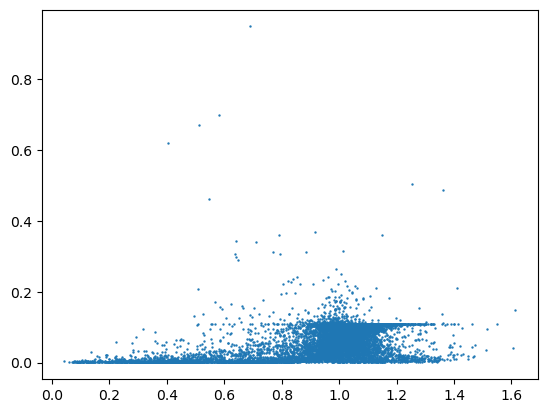

In [ ]:
y = np.asarray(file3['data']['loc']) ## mean
x = np.asarray(file3['data']['scale']) ## stdev

plt.scatter(y, x, s=0.5)
# plt.xlim(0, 2)
# plt.ylim(0, 2)

len(x)

(0.0, 2.0)

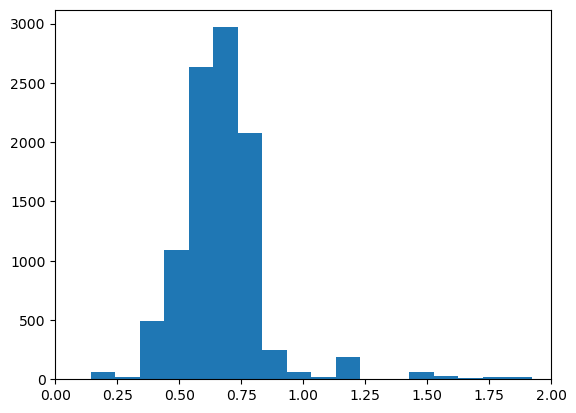

In [ ]:
file2['ancil']['zmode']

plt.hist(file2['ancil']['zmode'], bins = 1000)
plt.xlim(0, 2)



In [ ]:
ens = qp.read("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/outputs/VVDSf02/output_estimate_PZFlow.hdf5")

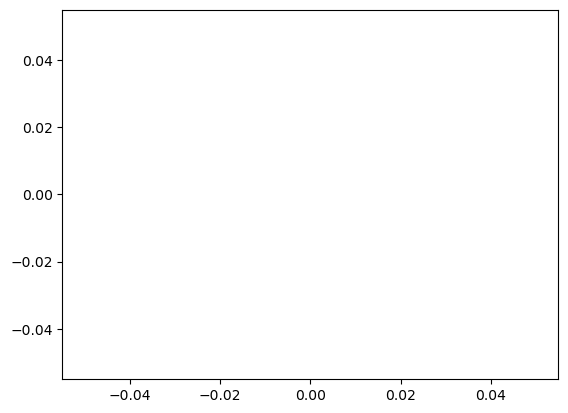

In [ ]:
plt.plot(np.linspace(0, 1, 100), ens[3].pdf(np.linspace(0, 1, 100))[0])

# Failiure rates

In [446]:
est_ls = ['TrainZ', 'CMNN', 'GPz', 'FZBoost']
spec_ls = ['BOSS', 'DEEP2', 'GAMA', 'HSC', 'VVDSf02', 'zCOSMOS']
pivot_ls = ['1.0', '1.4', 'control']
deg_ls = spec_ls + pivot_ls

In [437]:
ests_specs = []
for i in est_ls:
    specs = []
    for j in spec_ls:
        filepath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_"+i+"/outputs/"+j+"/output_estimate_"+i+".hdf5"
        file = h5py.File(filepath, 'r')
        ct_0 = 0
        ct_nan = 0
        for k in file['ancil']['zmode']:
            #print(k)
            if k == 0.0 :#or 0.0 or 0.00:
                ct_0 += 1
            if k == 'NaN' or k=='nan' or k=='Nan':
                ct_nan += 1
                print('aaa!!!')
        if ct_0 != 0 and ct_nan == 0:
            specs.append(str(ct_0)+' zeros')
        if ct_nan != 0 and ct_0 == 0:
            specs.append(str(ct_nan)+' nans')
        if ct_0 != 0 and ct_nan != 0:
            tot_fails = ct_0 + ct_nan
            specs.append(str(ct_0)+' zeros and '+str(ct_nan)+' nans, '+str(tot_fails)+ ' total failiures')
        if ct_0 == 0 and ct_nan == 0:
            specs.append('esimated for everything')
    ests_specs.append(specs)

In [564]:
# print(ests_specs)

# Import pandas library
import pandas as pd
 
# initialize list of lists
data = ests_specs
 
# Create the pandas DataFrame
df = pd.DataFrame(data, 
                  columns = ['BOSS, train set size = 1133', 'DEEP2, train set size = 52105', 'GAMA, train set size = 4567', 'HSC, train set size = 23902', 'VVDSf02, train set size = 137241', 'zCOSMOS, train set size = 57704'],
                  index = ['TrainZ', 'CMNN', 'GPz', 'FlexZBoost']
                  )
 
# print dataframe.

print("table of failed estimation rates. This was determined by seeing if the mode of the estimated redshift distribution was zero or NaN")

df

table of failed estimation rates. This was determined by seeing if the mode of the estimated redshift distribution was zero or NaN


BOSS, train set size = 1133 DEEP2, train set size = 52105  \
TrainZ         esimated for everything       esimated for everything   
CMNN           esimated for everything       esimated for everything   
GPz                         9847 zeros                       3 zeros   
FlexZBoost                     4 zeros                     128 zeros   

           GAMA, train set size = 4567 HSC, train set size = 23902  \
TrainZ         esimated for everything     esimated for everything   
CMNN           esimated for everything     esimated for everything   
GPz                         9891 zeros                    10 zeros   
FlexZBoost                   200 zeros                    39 zeros   

           VVDSf02, train set size = 137241 zCOSMOS, train set size = 57704  
TrainZ              esimated for everything         esimated for everything  
CMNN                esimated for everything         esimated for everything  
GPz                 esimated for everything                      3295 zeros  
FlexZBoost                         17 zeros                        52 zeros

In [439]:
ests_pivots = []
for i in est_ls:
    pivots = []
    for j in pivot_ls:
        filepath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_"+i+"/outputs/"+j+"/output_estimate_"+i+".hdf5"
        file = h5py.File(filepath, 'r')
        ct_0 = 0
        ct_nan = 0
        for k in file['ancil']['zmode']:
            #print(k)
            if k == 0.0 :#or 0.0 or 0.00:
                ct_0 += 1
            if k == 'NaN' or k=='nan' or k=='Nan':
                ct_nan += 1
                print('aaaa!!!')
        if ct_0 != 0 and ct_nan == 0:
            pivots.append(str(ct_0)+' zeros')
        if ct_nan != 0 and ct_0 == 0:
            pivots.append(str(ct_nan)+' nans')
        if ct_0 != 0 and ct_nan != 0:
            tot_fails = ct_0 + ct_nan
            pivots.append(str(ct_0)+' zeros and '+str(ct_nan)+' nans, '+str(tot_fails)+ ' total failiures')
        if ct_0 == 0 and ct_nan == 0:
            pivots.append('esimated for everything')
    ests_pivots.append(pivots)

In [565]:
# print(ests_pivots)

# Import pandas library
import pandas as pd
 
# initialize list of lists
data = ests_pivots
 
# Create the pandas DataFrame
df = pd.DataFrame(data, 
                  columns = ['pivot z = 1.0, train set size = 85459', 'pivot z = 1.4, train set size = 94504', 'control, train set size = 100000'],
                  index = ['TrainZ', 'CMNN', 'GPz', 'FlexZBoost']
                  )
 
# print dataframe.

print("table of failed estimation rates. This was determined by seeing if the mode of the estimated redshift distribution was zero or NaN")
df

table of failed estimation rates. This was determined by seeing if the mode of the estimated redshift distribution was zero or NaN


pivot z = 1.0, train set size = 85459  \
TrainZ                   esimated for everything   
CMNN                     esimated for everything   
GPz                                      3 zeros   
FlexZBoost                              15 zeros   

           pivot z = 1.4, train set size = 94504  \
TrainZ                   esimated for everything   
CMNN                     esimated for everything   
GPz                                      5 zeros   
FlexZBoost                              11 zeros   

           control, train set size = 100000  
TrainZ              esimated for everything  
CMNN                esimated for everything  
GPz                                 5 zeros  
FlexZBoost                          8 zeros

In [478]:
# i = 'GPz'
# j = 'HSC'

fail_inds_dict = {'TrainZ': {'BOSS': [], 'DEEP2': [], 'GAMA': [], 'HSC': [], 'VVDSf02': [], 'zCOSMOS': [], '1.0': [], '1.4': [], 'control': []}, 
              'CMNN': {'BOSS': [], 'DEEP2': [], 'GAMA': [], 'HSC': [], 'VVDSf02': [], 'zCOSMOS': [], '1.0': [], '1.4': [], 'control': []}, 
              'GPz': {'BOSS': [], 'DEEP2': [], 'GAMA': [], 'HSC': [], 'VVDSf02': [], 'zCOSMOS': [], '1.0': [], '1.4': [], 'control': []}, 
              'FZBoost': {'BOSS': [], 'DEEP2': [], 'GAMA': [], 'HSC': [], 'VVDSf02': [], 'zCOSMOS': [], '1.0': [], '1.4': [], 'control': []}
              }

def failInds(est_ls, deg_ls):
    for est in est_ls:
        for deg in deg_ls:
            if deg == '1.0' or deg == '1.4' or deg == 'control':
                filepath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_"+est+"/outputs/"+deg+"/output_estimate_"+est+".hdf5"
            else:
                filepath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_"+est+"/outputs/"+deg+"/output_estimate_"+est+".hdf5"
            file = h5py.File(filepath, 'r')
            ct = 0
            inds = []
            for k in file['ancil']['zmode']:
                if k == 0.0 or k == [0.0] or k == [0.]:# or k == []:#or 0.0 or 0.00:
                    inds.append(ct)
                if k == 'NaN' or k=='nan' or k=='Nan':
                    inds.append(ct)
                ct += 1
            fail_inds_dict[est][deg] = inds
            print(fail_inds_dict[est][deg])
    return fail_inds_dict


In [479]:
print(failInds(est_ls, deg_ls))

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214

In [471]:
fails_dict = {'TrainZ': {'BOSS': [], 'DEEP2': [], 'GAMA': [], 'HSC': [], 'VVDSf02': [], 'zCOSMOS': [], '1.0': [], '1.4': [], 'control': []}, 
              'CMNN': {'BOSS': [], 'DEEP2': [], 'GAMA': [], 'HSC': [], 'VVDSf02': [], 'zCOSMOS': [], '1.0': [], '1.4': [], 'control': []}, 
              'GPz': {'BOSS': [], 'DEEP2': [], 'GAMA': [], 'HSC': [], 'VVDSf02': [], 'zCOSMOS': [], '1.0': [], '1.4': [], 'control': []}, 
              'FZBoost': {'BOSS': [], 'DEEP2': [], 'GAMA': [], 'HSC': [], 'VVDSf02': [], 'zCOSMOS': [], '1.0': [], '1.4': [], 'control': []}
              }

fails_dict['TrainZ']['BOSS']

[]

In [480]:
def failsDist(est_ls, deg_ls):
    for est in est_ls:
        for deg in deg_ls:
            ls = []
            for i in fail_inds_dict[est][deg]:
                z = true_point_zs['redshift'][i]
                ls.append(z)
            fails_dict[est][deg] = ls
    return fails_dict

In [483]:
fails = failsDist(est_ls, deg_ls)

type(fails)

dict

Note: the distributions for BOSS and GAMA are practically identital


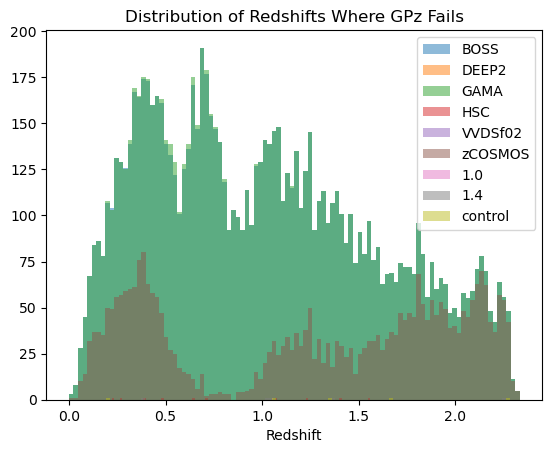

In [499]:
GPz_dict = fails['GPz']
FZBoost_dict = fails['FZBoost']

for deg in deg_ls:
    plt.hist(GPz_dict[deg], bins = 100, alpha = 0.5, label = deg)
    # plt.show()
    plt.legend()
    plt.title("Distribution of Redshifts Where GPz Fails")
    plt.xlabel("Redshift")

print("Note: the distributions for BOSS and GAMA are practically identital")

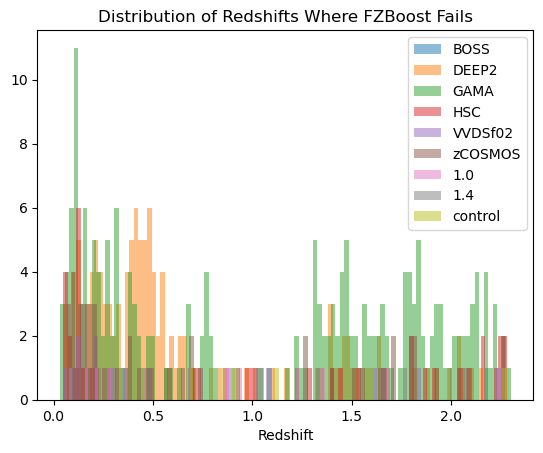

In [497]:
for deg in deg_ls:
    plt.hist(FZBoost_dict[deg], bins = 100, alpha = 0.5, label = deg)
    # plt.show()
    plt.legend()
    plt.title("Distribution of Redshifts Where FZBoost Fails")
    plt.xlabel("Redshift")

In [566]:

# ests = [['TrainZ', 0], ['CMNN', 1], ['GPz', 2], ['FZBoost', 3]]
# degs = [['BOSS', 0], ['DEEP2',1], ['GAMA', 2], ['HSC', 3], ['VVDSf02', 4], ['zCOSMOS', 5], ['1.0', 6], ['1.4', 7], ['control', 8]]

def makeOneHist(est, deg, ax):
    if deg == '1.0' or deg == '1.4' or deg == 'control':
        est_filepath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_"+est+"/outputs/"+deg+"/output_estimate_"+est+".hdf5"
        train_filepath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_"+est+"/outputs/"+deg+"/output_lsst_error_0.pq"
    else:
        est_filepath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_"+est+"/outputs/"+deg+"/output_estimate_"+est+".hdf5"
        train_filepath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_"+est+"/outputs/"+deg+"/output_lsst_error_0.pq"
    est_file = h5py.File(est_filepath, 'r')
    train_table = pd.read_parquet(train_filepath)
    modes = np.asarray(est_file['ancil']['zmode']).flatten()
    ax.hist(modes, bins = np.linspace(0, 2.5, 100), density = True, alpha = 0.5, label = 'mode of estimation')
    ax.hist(train_table['redshift'], bins = np.linspace(0, 2.5, 100), alpha = 0.5, density = True, label = 'training set redshift distribution' )
    ax.hist(true_point_zs['redshift'], bins = np.linspace(0, 2.5, 100),alpha = 0.5, density = True, label = 'true redshift distribution')
    ax.set_xlim(0, 2.5)
    #ax.legend()
    #ax.show()


def modeHists(est_ls, deg_ls, size):
    rows = len(est_ls)
    cols = len(deg_ls)
    fig, axes = plt.subplots(nrows = rows, ncols = cols, figsize = (size, (1/3)*size))
    ct = 0
    for i in range(0, rows):
        for j in range(0, cols):
            makeOneHist(est_ls[i], deg_ls[j], axes[i][j])
            # axes[i][j].plot(ztrue_posts['meta']['xvals'][0], ztrue_posts['data']['yvals'][ct], label = "test set pdf") 
            # axes[i][j].plot(true_point_zs['redshift'][ct]*np.ones(101), np.linspace(0, 30, 101), color = 'k', label = 'true redshift')

    axes[0][0].legend()
    
    for i in range(0, cols):
        axes[0][i].set_title(deg_ls[i], size = 'medium')

    for i in range(0, rows):
        axes[i][0].set_ylabel(est_ls[i], size = 'medium')

    fig.suptitle("Histogram distributions of mode redshifts from estimator outputs, compared with distributions of redshifts in training sets", size = 'xx-large')
    fig.supxlabel("Redshift", size = 'large')

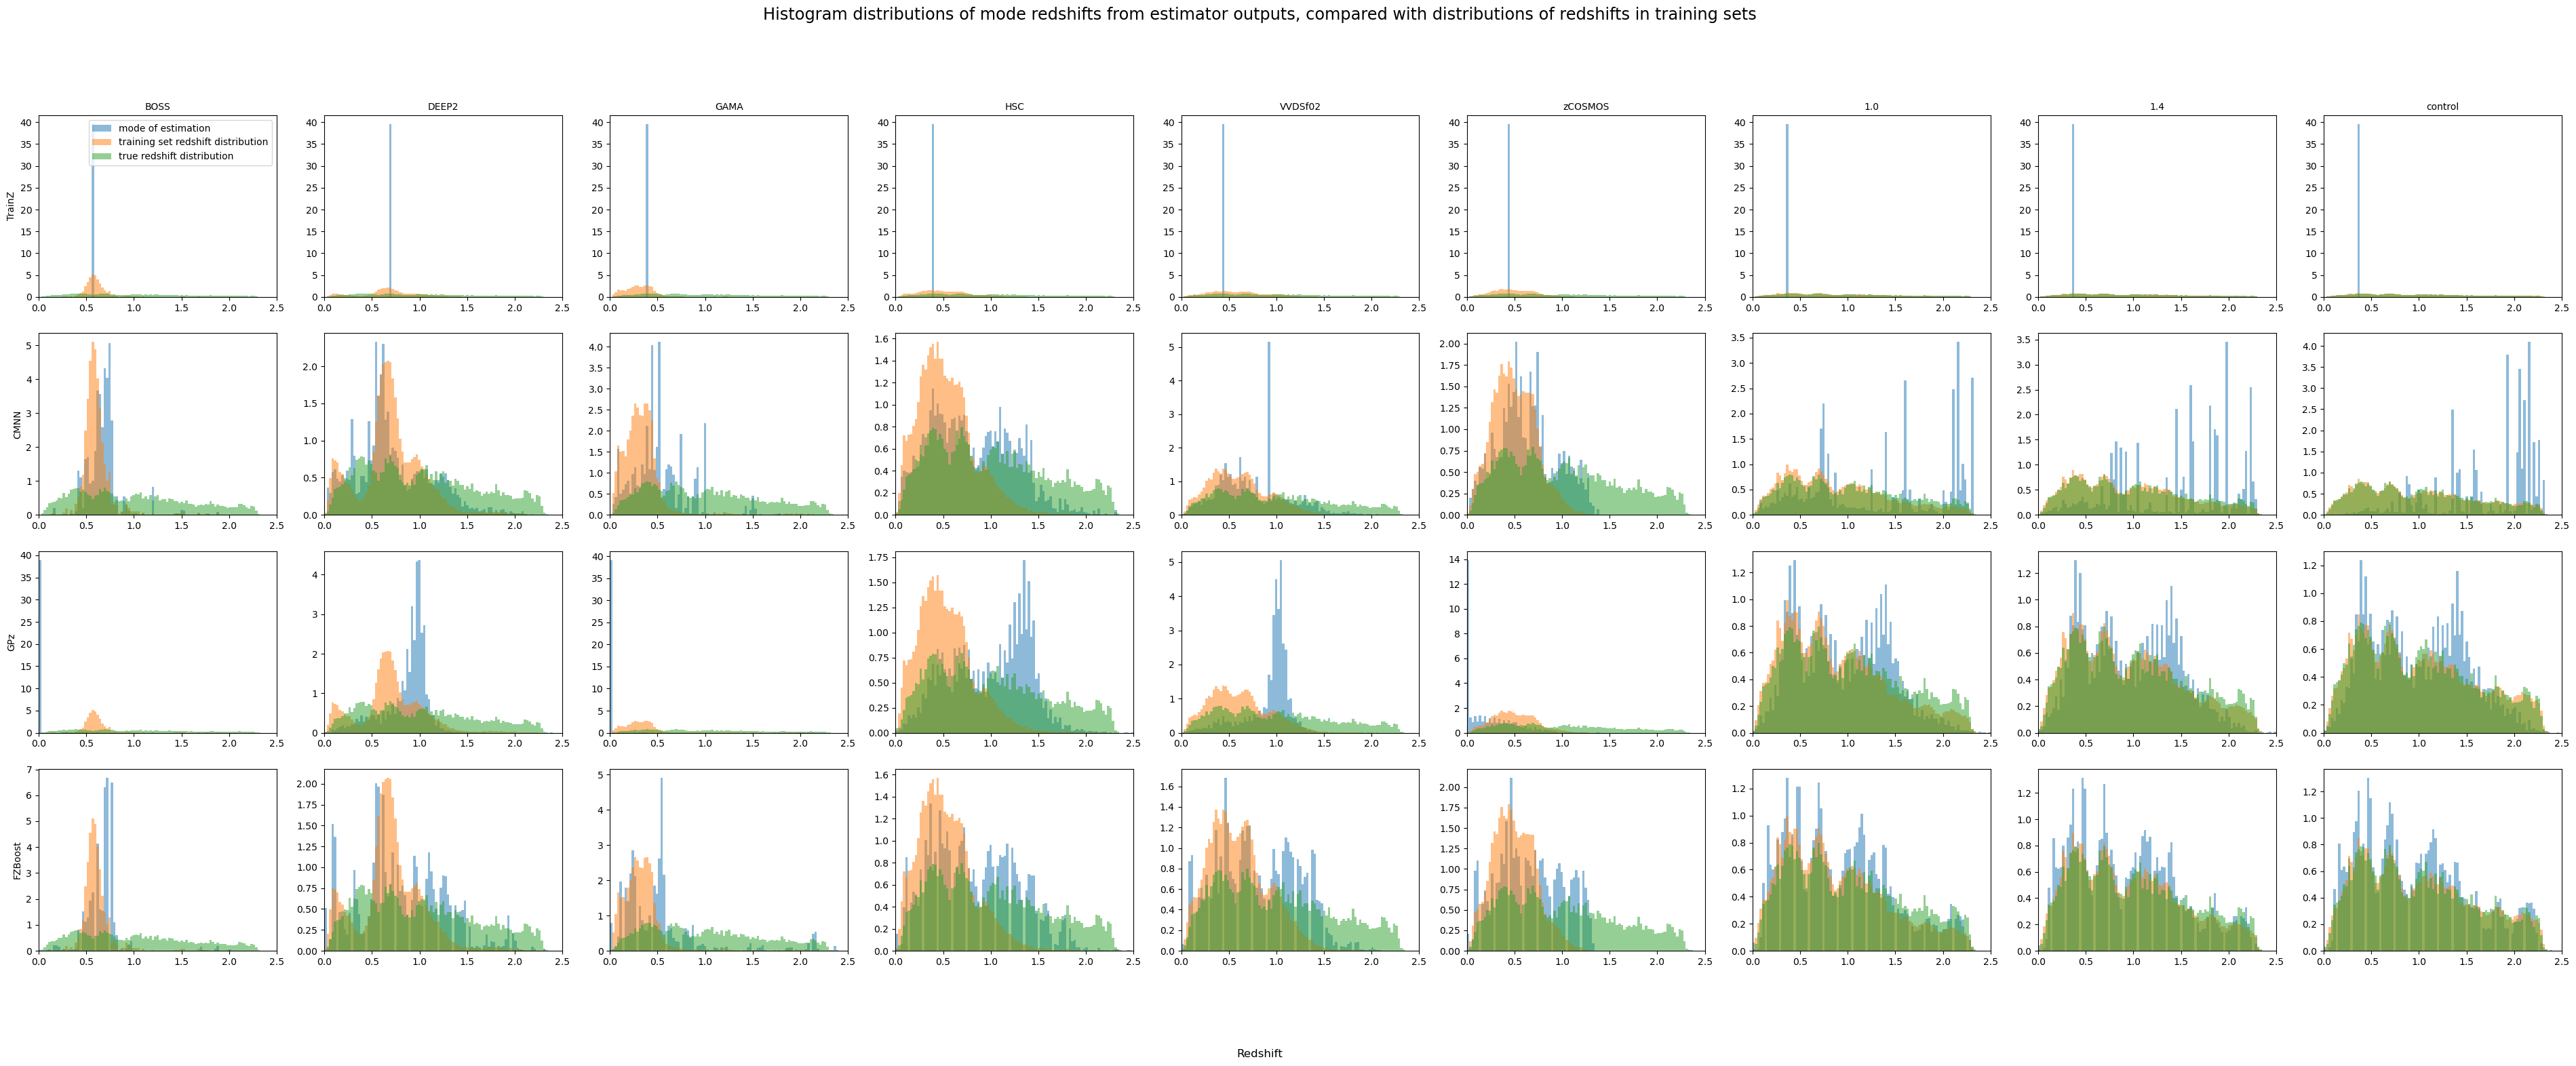

In [567]:
modeHists(est_ls, deg_ls, 48)

In [ ]:
import pandas as pd 

np.asarray(file['ancil']['zmode']).flatten()

orig = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/BOSS/output_train_set.pq")

np.asarray(orig['redshift']).flatten()

array([1.3684232, 1.5080856, 1.2070549, ..., 0.5338165, 1.4458658,
       1.1521654], dtype=float32)

In [434]:
# orig = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/BOSS/output_train_set.pq")
orig = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/control/output_lsst_error_0.pq")
test = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/BOSS/output_lsst_error.pq")

# BOSS = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/BOSS/output_specselection_boss.pq")
BOSS = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/BOSS/output_lsst_error_0.pq")

# DEEP2 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/DEEP2/output_specselection_deep2.pq")
DEEP2 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/DEEP2/output_lsst_error_0.pq")

# GAMA = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/GAMA/output_specselection_gama.pq")
GAMA = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/GAMA/output_lsst_error_0.pq")

# HSC = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/HSC/output_specselection_HSC.pq")
HSC = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/HSC/output_lsst_error_0.pq")

# VVDSf02 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/VVDSf02/output_specselection_VVDSf02.pq")
VVDSf02 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/VVDSf02/output_lsst_error_0.pq")

# zCOSMOS = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/zCOSMOS/output_specselection_zCOSMOS.pq")
zCOSMOS = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/zCOSMOS/output_lsst_error_0.pq")

# _10 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/1.0/output_inv_redshift.pq")
_10 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/1.0/output_lsst_error_0.pq")

# _14 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/1.4/output_inv_redshift.pq")
_14 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/1.4/output_lsst_error_0.pq")

# control = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/control/output_train_set.pq")
control = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/control/output_lsst_error_0.pq")

Magnitude vs. redshift for spectroscopic survey degraders


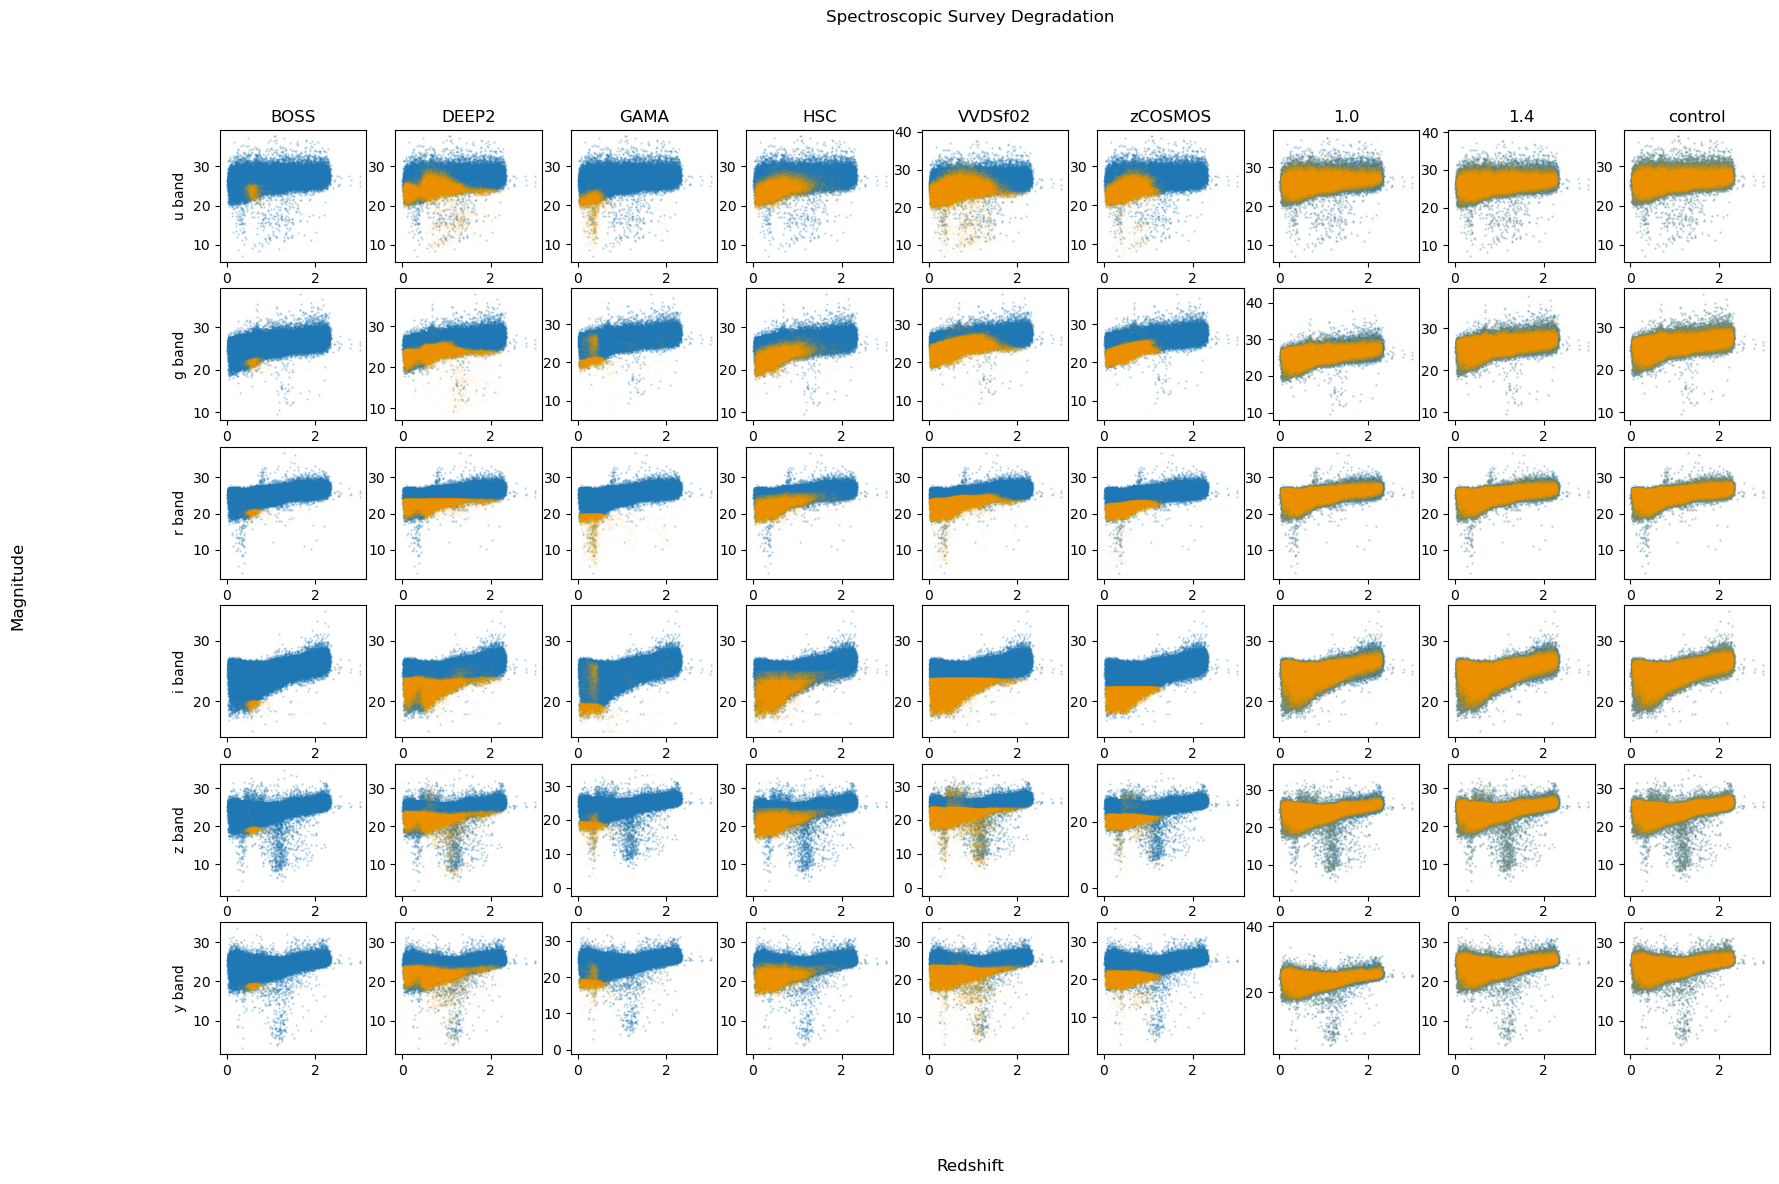

In [435]:
degs = [[BOSS, 0], [DEEP2,1], [GAMA,2], [HSC,3], [VVDSf02,4], [zCOSMOS,5], [_10, 6], [_14, 7], [control, 8]]
bands = [['mag_u_lsst',0], ['mag_g_lsst',1], ['mag_r_lsst',2], ['mag_i_lsst',3], ['mag_z_lsst',4], ['mag_y_lsst',5]]

fig, axes = plt.subplots(nrows = len(bands),  ncols = len(degs), figsize = (20, 12)) 

for i in bands:
    for j in degs:
        #axes[i[1]][j[1]].hist2d(orig['redshift'], orig[i[0]], bins = 100)
       # axes[i[1]][j[1]].contour(j[0]['redshift'], j[0][i[0]], s=0.5, alpha=0.25, color = 'orange')
        axes[i[1]][j[1]].scatter(orig['redshift'], orig[i[0]], s=0.5, alpha = 0.25)
        axes[i[1]][j[1]].scatter(j[0]['redshift'], j[0][i[0]], s=0.5, alpha=0.05, color = 'orange')
        #axes[i[1]][j[1]].scatter(test['redshift'], test[i[0]], s=0.5, color = 'lightgreen', alpha = 0.1)
        
axes[0][0].set_ylabel("u band")
axes[1][0].set_ylabel("g band")
axes[2][0].set_ylabel("r band")
axes[3][0].set_ylabel("i band")
axes[4][0].set_ylabel("z band")
axes[5][0].set_ylabel("y band")

axes[0][0].set_title("BOSS")
axes[0][1].set_title("DEEP2")
axes[0][2].set_title("GAMA")
axes[0][3].set_title("HSC")
axes[0][4].set_title("VVDSf02")
axes[0][5].set_title("zCOSMOS")
axes[0][6].set_title("1.0")
axes[0][7].set_title("1.4")
axes[0][8].set_title("control")

fig.supxlabel("Redshift")
fig.supylabel("Magnitude")
fig.suptitle("Spectroscopic Survey Degradation")

print("Magnitude vs. redshift for spectroscopic survey degraders")

In [424]:
help(plt.contour)

Help on function contour in module matplotlib.pyplot:

contour(*args, data=None, **kwargs) -> 'QuadContourSet'
    Plot contour lines.
    
    Call signature::
    
        contour([X, Y,] Z, [levels], **kwargs)
    
    `.contour` and `.contourf` draw contour lines and filled contours,
    respectively.  Except as noted, function signatures and return values
    are the same for both versions.
    
    Parameters
    ----------
    X, Y : array-like, optional
        The coordinates of the values in *Z*.
    
        *X* and *Y* must both be 2D with the same shape as *Z* (e.g.
        created via `numpy.meshgrid`), or they must both be 1-D such
        that ``len(X) == N`` is the number of columns in *Z* and
        ``len(Y) == M`` is the number of rows in *Z*.
    
        *X* and *Y* must both be ordered monotonically.
    
        If not given, they are assumed to be integer indices, i.e.
        ``X = range(N)``, ``Y = range(M)``.
    
    Z : (M, N) array-like
        The height